In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.simbad import Simbad
from photutils import DAOStarFinder, CircularAperture, SkyCircularAperture, CircularAnnulus, aperture_photometry, Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, Column, hstack
import numpy
import os
import pylab
import glob
import seaborn as sns
from dateutil.parser import parse
from scipy.stats import sigmaclip
from astropy.stats import median_absolute_deviation, SigmaClip
import traceback
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import coordinates as coord


Bad key "text.kerning_factor" on line 4 in
/home/utsumi/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Some definitions

In [2]:
# expected number of photos / sec
coef={
    "FLUX_R": 1.42e9,
    "FLUX_I": 1.00e9,
    "FLUX_u": 4.46e8,
    "FLUX_U": 4.46e8
}

AB = {
    "FLUX_R": 0.21,
    "FLUX_I": 0.45,
    "FLUX_u": 0.91,
    "FLUX_U": 0.91
}

glassbanketc = {
    "u": 0.59,   # take out a mirror because DM installed
    "Rc": 0.61,  # take out a mirror because DM installed
    "Ic": 0.55   # 0.72**2*0.99**4
}

# atmospheric transmission at arimass of 1.2
extinction = {
    "u": 0.70,
    "Rc": 0.95,
    "Ic": 0.98
}

### Okita et al., 2019 Mirror degradation model (achromatic and scattering model)
def R(lam,t):
    alpha = numpy.exp(-2.3/100*t)
#    alpha = numpy.exp(-2.7/100*t)
    theta = 0./180*numpy.pi
    sigma = 10+40*t
#    sigma = 10+30*t
    return alpha*numpy.exp(-(4*numpy.pi*sigma*numpy.cos(theta)/lam)**2)

# mean wavelength for convenience
lam = {
    "u": 3500.,
    "Rc": 6600.,
    "Ic": 8000.
}

In [3]:
def preprocess(path):
    """ Do preprocess by debias, trimming, and sky subtraction """
    # load fits file
    fh = fits.open(path)

    # reduce data
    header = fh[0].header
    data = fh[0].data[:header["MaxImgRows"], :header["MaxImgCols"]]
#    data = fh[0].data
    bias = numpy.outer(
        numpy.median(fh[0].data[:,header["MaxImgCols"]+10:],axis=1),
        numpy.ones(data.shape[1]))  # avoiding first 10 cols, row-by-row operation
    data = data - bias

    # sky subtraction
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()

    # dividing the whole image by 4 in row
    for i in range(4):
        subsection = data[512*i:512*(i+1)]
        bkg = Background2D( subsection, (30, 30), filter_size=(3, 3),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        data[512*i:512*(i+1)] = subsection - bkg.background
    
    new=fits.PrimaryHDU(data=data,header=header)
    new.writeto("{}".format("/".join(
        [os.path.dirname(os.path.abspath(path)),"bg"+os.path.basename(path)]
    )), overwrite=True)
    
    return data, header
    

In [4]:
def getrefcatalog( wcs ):
    """ retrieve reference catalog according to wcs """
    c = SkyCoord(wcs.wcs.crval[0]*u.deg,wcs.wcs.crval[1]*u.deg)
    r = 15 * u.arcminute
    customSimbad = Simbad()
    customSimbad.add_votable_fields(
        "flux(u)",
        "flux_error(U)",
        "flux_system(U)",
        "flux_unit(U)",
        "flux(U)",
        "flux_error(U)",
        "flux_system(U)",
        "flux_unit(U)",
        "flux(R)",
        "flux_error(R)",
        "flux_system(R)",
        "flux_unit(R)",
        "flux(I)",
        "flux_error(I)",
        "flux_system(I)",
        "flux_unit(I)"
        )
    reference = customSimbad.query_region(c, radius=r)
    refcoord=SkyCoord(reference["RA"],reference["DEC"],unit=(u.hourangle, u.deg))
    return reference, refcoord

In [5]:
def checkstarsused( wcs, data ):
    ### PLOT IMAGE
    fig = pylab.figure(figsize=(5,5),dpi=200)
    pylab.subplot(projection=wcs)
    sky=numpy.median(data)
    std=median_absolute_deviation(data)
    aperture.plot(color='white', lw=0.1)
    annulus_aperture.plot(color='red', lw=0.1)

    pylab.imshow(data,origin="lower left",vmin=sky-3*std,vmax=sky+10*std,cmap="gray")

    refaperture = SkyCircularAperture(
        refcoord[(reference[filterkey]>0)&(reference[filterkey]<25)], r=2.*u.arcsec
    ).to_pixel(wcs)
    refaperture.plot(color="green", lw=2, alpha=0.5)
    pylab.show()
    pylab.clf()


In [6]:
def checkTmag( merged, filterkey, x, med, err ):
    ### CHECK PLOT
    sns.set(style="darkgrid")
    tips = sns.load_dataset("tips")

    g = sns.JointGrid( merged[filterkey], x, ylim=(-0.05,1.05))
    g.plot_joint(sns.scatterplot)
    g.ax_marg_x.hist(
        merged[filterkey],
        bins=numpy.arange(11,20,0.5)
    )
    g.ax_marg_y.hist(
        x,
        orientation="horizontal",
        bins=numpy.arange(0,1,0.05)
    )
    g.set_axis_labels(xlabel="mag", ylabel="Throughput")

    pylab.axhline(med)    
    pylab.axhspan(med-err, med+err, alpha=0.5)
    pylab.suptitle(filterkey)


The code below tries to do aperture photometry on a given image. There are etwo options that allow to show some diagnostic plots.

In [7]:
def getthroughput(path,data=None,header=None,reference=None,refcoord=None,wcs=None,plot=False,tol=1*u.arcsec):
    if header is None:
        data, header=preprocess(path)
    if wcs is None:
        wcs = WCS(header)
    filterkey = "FLUX_{}".format(header["FILTER"][0].upper())
#    filterkey = "FLUX_{}".format(header["FILTER"][0])
    print(filterkey)
    if reference is None:
        reference, refcoord = getrefcatalog(wcs)
    #    data = fh[0].data
    # detect objectcoef, need to optmize FWHM size
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
    sources=daofind(data-median)
    # define positions where we measure
    positions = numpy.transpose([sources["xcentroid"], sources["ycentroid"]])
    aperture = CircularAperture(positions, r=5)
    annulus_aperture = CircularAnnulus(positions, r_in=8, r_out=10)
    # do photometry
    table = aperture_photometry(data,[aperture,annulus_aperture],wcs=wcs)
    table["flux"] = table["aperture_sum_0"]-table["aperture_sum_1"]*aperture.area/annulus_aperture.area    
#    idx, d2d, d3d = SkyCoord(wcs.all_pix2world((positions+xyoff),0),unit=("deg","deg")).match_to_catalog_sky(refcoord)    
    idx, d2d, d3d = aperture.to_sky(wcs).positions.match_to_catalog_sky(refcoord)
    table["d2d"] = d2d.to("arcsec")
    merged = hstack([Table(table), reference[idx]])[d2d<tol]

    obs = merged["flux"]*header["GAIN"]/header["EXPTIME"] # e-/sec
    expected = coef[filterkey]*10**(-0.4*(merged[filterkey]+AB[filterkey]))

    # limiting magnitude NEEDS VERIFICATION
#    aperturesize = 2.94  # in pixel
    aperturesize = 2.55*1.4  # in pixel
    area = numpy.pi*(aperturesize/2)**2
    fluctuation_mad = median_absolute_deviation(data)*numpy.sqrt(area)
    fluctuation_sig = numpy.std(data)*numpy.sqrt(area)
    nsigma = 10
    limitmag = -2.5*numpy.log10( nsigma*fluctuation_mad*header["GAIN"]/header["EXPTIME"]/(coef[filterkey]*glassbanketc[header["FILTER"]]) )
    limitmag_sig = -2.5*numpy.log10( nsigma*fluctuation_sig*header["GAIN"]/header["EXPTIME"]/(coef[filterkey]*glassbanketc[header["FILTER"]]) )    
    print ("2\" ap {} sigma limiting magnitude in {} = {} {} ".format( nsigma, header["FILTER"], limitmag, limitmag_sig ))
    
    x = obs/expected
    c, low, upp = sigmaclip(x[numpy.where((x>0.1)&(x<1))])
    med = numpy.nanmedian(c)
    err = median_absolute_deviation(c)
    
    if plot == True:
        checkstarsused( wcs, data )
        checkTmag( merged, filterkey, x, med, err )

    return { "median": med, "std": err, "limitmag": limitmag }, header

The code assumes there are fits files for Ic and Rc which have correct astrometry in appropriate subdirectory. For u-band it ignores the WCS file, and uses the one for Ic with tweaking CRVAL to make coarse adjustment.
Using Ic for the reference is easier than using Rc because Ic has the same parity to u.

In [8]:
def loopover( target, offset ):
    files = glob.glob(target)
    order = [2,1,0]
    result = {}
    for i, afile in enumerate(files):
        data, header, wcs, reference, refcoord = None, None, None, None, None
        for j in order:
            try:
                path = afile.replace("-2","-{}".format(j))
                if j == order[0]:
                    data, header = preprocess(afile)
                    wcs = WCS(header)
                    reference, refcoord=getrefcatalog(wcs)
                if j == order[1]:
                    wcs = None
                if j == order[2]:
                    a=WCS(header).wcs
                    a.crpix = a.crpix-numpy.array(offset)
                    wcs = WCS(a.to_header())
                    path = "/".join(
                        os.path.dirname(path).split("/")[:-1]+[os.path.basename(path).replace(".new",".fits")]
                    )
                print ("{}/{}".format(i,len(files)))
                print (wcs,offset)
                try:
                    print (path)
                    if j==order[2]:
                        plot = False
                        tol = 8*u.arcsec ### tolearance for u-band 
                    else:
                        plot = False
                        tol = 1*u.arcsec
                    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
                    print (res)
                    dt = parse("{}T{}".format(header["DATE-OBS"],header["UT"]))
                    try:
                        result[resheader["FILTER"]]["dt"].append( dt )
                        result[resheader["FILTER"]]["median"].append( res["median"] )
                        result[resheader["FILTER"]]["std"].append( res["std"] )
                        result[resheader["FILTER"]]["header"].append( resheader )
                    except:
                        result[resheader["FILTER"]] = {
                            "dt": [ dt ],
                            "median": [ res["median"] ],
                            "std": [ res["std"] ],
                            "header": [ resheader ]
                        }
                except:
                    traceback.print_exc()
            except:
                traceback.print_exc()
    return result

We assume atmospheric extinction can be calculated from the model using the following formula
\begin{eqnarray}
T_{\rm atm}(z)=\exp\left(\frac{\ln(T_{\rm atm, 1.2})}{1.2}\sec z\right)
\end{eqnarray}

|                    |  $u$ | $Rc$ | $Ic$ | Notes   |
|--------------------|------|------|------|---------|
| $\lambda$          |   350|   660|   800|         |
| $T_{\rm atm, 1.2}$ |  0.68|  0.95|  0.98| Taken from the MODRAN simluation where $\sec z=1.2$            |
|  $\alpha$          |  0.32|  0.04| 0.017| extinction coefficient in flux $I=I_0 \exp(-\alpha \sec z)$     |
|       $k$           |  0.34|  0.04| 0.018| extinction coefficient in magnitude $k=1.08\alpha$ |

This $k$ is comparable if we use the numbers for zero meter but not for the above numbers.
Because we have already included the contribution of $T_{\rm atm, 1.2}$, it has to be taken out from the fraction.

In [9]:
def mkplot( result, site, target, year, corr={"u": 1., "Rc": 1., "Ic": 1.} ):
    fig = pylab.figure(figsize=(5,5),dpi=200)
    for key in ["u","Rc","Ic"]:
        alt = []
        time = []
        try:
            sub=pylab.subplot(211)
            pylab.subplots_adjust(top=1.3,hspace=0)
            for aheader in result[key]["header"]:
                obstime = parse("{}T{} UT ".format(aheader["DATE-OBS"],aheader["UT"]))
                aa_frame = coord.AltAz(
                    obstime=obstime,
                    location=site)
                ret = SkyCoord(aheader["CRVAL1"],aheader["CRVAL2"],unit=("deg","deg")).transform_to(aa_frame)            
                alt.append(ret.alt.degree)
                time.append(ret.obstime.value)
            secz = 1./numpy.cos((90-numpy.array(alt))/180.*numpy.pi)
            air = numpy.exp(numpy.log(extinction[key])/1.2*secz)/numpy.exp(numpy.log(extinction[key]))
            x = numpy.array(result[key]["dt"])
            y = numpy.array(result[key]["median"])/air*corr[key]
            yerr = numpy.array(result[key]["std"])/air*corr[key]
            cond = numpy.where(((yerr/y)<.3)&(y>0.1))
            data = pylab.errorbar(
                x[cond],
                (y/glassbanketc[key])[cond],
                yerr=(yerr/glassbanketc[key])[cond],
                fmt="o",label=key)
            pylab.axhline(1,color="k")
            pylab.axhline(0,color="k")
            pylab.axhline(R(lam[key],year),color=data[0].get_color())    
            pylab.axhspan(R(lam[key],year-1),R(lam[key],year+1),alpha=0.2,color=data[0].get_color())    

            
            pylab.ylim(-0.1,1.1)
            pylab.legend()
            pylab.ylabel("Relative Transparency to the Expectation")        
            pylab.subplot(212,sharex=sub)
            pylab.plot_date(time, alt,color=data[0].get_color())
            pylab.ylabel("Altitude")
            pylab.xlabel("UT")
            pylab.ylim(0,90)
            fig.autofmt_xdate()
            
        except:
            traceback.print_exc()

#pylab.tight_layout()

(0, 1)

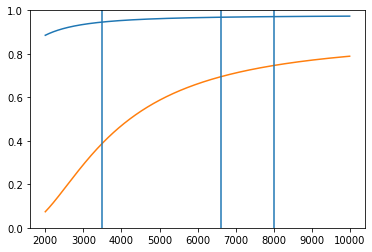

In [10]:
x = numpy.arange(2000,10000,10)
for t in [1,6]:
    pylab.plot(x,R(x,t))
for x in lam.keys():
    pylab.axvline(lam[x])
pylab.ylim(0,1)

# Ali data analysis

In [11]:
target = "fwhm/HT*-2/HT*.new"
offset = [-5,14] # for u-band coase alignment

In [12]:
result = loopover(target,offset)

0/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8773333895  13.4350131563  
CRPIX : 810.778289795  554.337314606  
CD1_1 CD1_2  : 0.000188040296777  7.24863329823e-07  
CD2_1 CD2_2  : -6.51681946937e-07  0.000186515411922  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000159-2/HT0000159-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.834515907948553 16.830660104493898 
{'median': 0.3808659126254945, 'std': 0.004089454057105202, 'limitmag': 19.834515907948553}
0/95
None [-5, 14]
fwhm/HT0000159-1/HT0000159-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.996684427972045 17.16019382670745 
{'median': 0.4288161939333917, 'std': 0.003765446505406056, 'limitmag': 19.996684427972045}
0/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8773333895  13.4350131563  
CRPIX : 815.778289795  540.337314606  
PC1_1 PC1_2  : 0.000188040296777  7.24863329823e-07  
PC2_1 PC2_2  : -6.51681946937e-07  0.000186515411922  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000159-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.214771224230024 15.716248387257911 
{'median': nan, 'std': nan, 'limitmag': 16.214771224230024}
1/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251163634  -0.0230606331836  
CRPIX : 922.60568428  606.656505585  
CD1_1 CD1_2  : 0.000188035529337  6.29457993905e-07  
CD2_1 CD2_2  : -6.57684807731e-07  0.000186461160315  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000165-2/HT0000165-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.891426190330318 16.788609052462228 
{'median': 0.36769224044769827, 'std': 0.010719541238306401, 'limitmag': 19.891426190330318}
1/95
None [-5, 14]
fwhm/HT0000165-1/HT0000165-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 20.0985265586762 17.056581811301072 
{'median': 0.4514569960512169, 'std': 0.03457778854939819, 'limitmag': 20.0985265586762}
1/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251163634  -0.0230606331836  
CRPIX : 927.60568428  592.656505585  
PC1_1 PC1_2  : 0.000188035529337  6.29457993905e-07  
PC2_1 PC2_2  : -6.57684807731e-07  0.000186461160315  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000165-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.21827129008311 15.715528906972837 
{'median': 0.266536337644407, 'std': 0.010080071085921016, 'limitmag': 16.21827129008311}
2/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732206932  85.3077506809  
CRPIX : 868.372879028  962.380828857  
CD1_1 CD1_2  : 0.000188089156595  -3.3177381176e-06  
CD2_1 CD2_2  : 3.35361226268e-06  0.000186398664922  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000250-2/HT0000250-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.17922740897613 15.427598367841362 
{'median': 0.37432343605703156, 'std': 0.011210249607311096, 'limitmag': 19.17922740897613}
2/95
None [-5, 14]
fwhm/HT0000250-1/HT0000250-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.469636590208108 15.794995194145361 
{'median': 0.4569860709319945, 'std': 0.013536188440475494, 'limitmag': 19.469636590208108}
2/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732206932  85.3077506809  
CRPIX : 873.372879028  948.380828857  
PC1_1 PC1_2  : 0.000188089156595  -3.3177381176e-06  
PC2_1 PC2_2  : 3.35361226268e-06  0.000186398664922  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000250-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.171794729746125 15.455615035742412 
{'median': 0.27334142265807765, 'std': 0.0, 'limitmag': 16.171794729746125}
3/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732346742  85.3077811158  
CRPIX : 870.849960327  971.664432526  
CD1_1 CD1_2  : 0.000188082396996  -3.29311680679e-06  
CD2_1 CD2_2  : 3.34296863636e-06  0.000186423855946  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000290-2/HT0000290-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.131413960055948 15.341120171949644 
{'median': 0.38309871386439476, 'std': 0.014340613726357115, 'limitmag': 19.131413960055948}
3/95
None [-5, 14]
fwhm/HT0000290-1/HT0000290-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.452440750266895 15.765310887398243 
{'median': 0.46098469210259324, 'std': 0.015894969118655566, 'limitmag': 19.452440750266895}
3/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732346742  85.3077811158  
CRPIX : 875.849960327  957.664432526  
PC1_1 PC1_2  : 0.000188082396996  -3.29311680679e-06  
PC2_1 PC2_2  : 3.34296863636e-06  0.000186423855946  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000290-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.183682010017108 15.46138170590105 
{'median': 0.3271444292263118, 'std': 0.06647511175267554, 'limitmag': 16.183682010017108}
4/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733139914  85.30777294  
CRPIX : 875.772537231  1018.69539642  
CD1_1 CD1_2  : 0.000188133148915  -3.17332087191e-06  
CD2_1 CD2_2  : 3.29839965237e-06  0.000186414719738  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000454-2/HT0000454-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.07183788313525 15.37821795446985 
{'median': 0.37168017663506425, 'std': 0.013639146513522493, 'limitmag': 19.07183788313525}
4/95
None [-5, 14]
fwhm/HT0000454-1/HT0000454-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.468855047158502 15.824379902545298 
{'median': 0.44337781369807516, 'std': 0.013625461384521337, 'limitmag': 19.468855047158502}
4/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733139914  85.30777294  
CRPIX : 880.77253723  1004.69539642  
PC1_1 PC1_2  : 0.000188133148915  -3.17332087191e-06  
PC2_1 PC2_2  : 3.29839965237e-06  0.000186414719738  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000454-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17178894417512 15.453764827533094 
{'median': 0.4641365949386983, 'std': 0.20275312108484844, 'limitmag': 16.17178894417512}
5/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733232425  85.3077707876  
CRPIX : 874.648864746  981.566307068  
CD1_1 CD1_2  : 0.000188084171972  -3.25953610862e-06  
CD2_1 CD2_2  : 3.3451242937e-06  0.00018640520013  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000331-2/HT0000331-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.122151429852877 15.364589491457405 
{'median': 0.37835438383392617, 'std': 0.013070105237206864, 'limitmag': 19.122151429852877}
5/95
None [-5, 14]
fwhm/HT0000331-1/HT0000331-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.448356309832747 15.800589989095569 
{'median': 0.4545871543527943, 'std': 0.014698864837516812, 'limitmag': 19.448356309832747}
5/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733232425  85.3077707876  
CRPIX : 879.648864746  967.566307068  
PC1_1 PC1_2  : 0.000188084171972  -3.25953610862e-06  
PC2_1 PC2_2  : 3.3451242937e-06  0.00018640520013  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000331-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.170053188955556 15.45906559897998 
{'median': 0.2699068166839244, 'std': 0.008313101260930322, 'limitmag': 16.170053188955556}
6/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733133928  85.3077537405  
CRPIX : 876.264587402  987.568511963  
CD1_1 CD1_2  : 0.000188127829012  -3.25195521606e-06  
CD2_1 CD2_2  : 3.32563518452e-06  0.000186429252042  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000350-2/HT0000350-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.0919423217787 15.442917406900847 
{'median': 0.37041600407355363, 'std': 0.010974427837504186, 'limitmag': 19.0919423217787}
6/95
None [-5, 14]
fwhm/HT0000350-1/HT0000350-1.new
6/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733133928  85.3077537405  
CRPIX : 881.264587402  973.568511963  
PC1_1 PC1_2  : 0.000188127829012  -3.25195521606e-06  
PC2_1 PC2_2  : 3.32563518452e-06  0.000186429252042  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000350-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.177083830419193 15.454984322442131 
{'median': 0.6305439916347189, 'std': 0.06991280813177647, 'limitmag': 16.177083830419193}
7/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.55365283  5.85239140653  
CRPIX : 1546.16574097  1139.90052414  
CD1_1 CD1_2  : 0.000187888940219  8.83265280018e-07  
CD2_1 CD2_2  : -1.10396532958e-06  0.000186285451558  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000126-2/HT0000126-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.31282603169968 15.986033818241248 
{'median': 0.3756187860609388, 'std': 0.006401040001647207, 'limitmag': 19.31282603169968}
7/95
None [-5, 14]
fwhm/HT0000126-1/HT0000126-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.54823994426964 16.41282004206398 
{'median': 0.44102905855331537, 'std': 0.0076543696483949986, 'limitmag': 19.54823994426964}
7/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.55365283  5.85239140653  
CRPIX : 1551.16574097  1125.90052414  
PC1_1 PC1_2  : 0.000187888940219  8.83265280018e-07  
PC2_1 PC2_2  : -1.10396532958e-06  0.000186285451558  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000126-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.211561275198267 15.706424259653906 
{'median': nan, 'std': nan, 'limitmag': 16.211561275198267}
8/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732134593  85.307772622  
CRPIX : 872.846618652  976.38123703  
CD1_1 CD1_2  : 0.000188121607804  -3.28100715529e-06  
CD2_1 CD2_2  : 3.34551841981e-06  0.00018641663734  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000310-2/HT0000310-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.118974837763005 15.357800538512215 
{'median': 0.3798538340835462, 'std': 0.013378817268114962, 'limitmag': 19.118974837763005}
8/95
None [-5, 14]
fwhm/HT0000310-1/HT0000310-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.446323638538395 15.806588947198696 
{'median': 0.4539084483659712, 'std': 0.014238886188259109, 'limitmag': 19.446323638538395}
8/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732134593  85.307772622  
CRPIX : 877.846618652  962.38123703  
PC1_1 PC1_2  : 0.000188121607804  -3.28100715529e-06  
PC2_1 PC2_2  : 3.34551841981e-06  0.00018641663734  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000310-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.173691104120177 15.455994974194773 
{'median': 0.40759794950671613, 'std': 0.1271324147870575, 'limitmag': 16.173691104120177}
9/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1735285198  85.3077363786  
CRPIX : 813.712600708  889.326057434  
CD1_1 CD1_2  : 0.000188022736273  -3.28443126603e-06  
CD2_1 CD2_2  : 3.36207336174e-06  0.000186377158373  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000142-2/HT0000142-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.20132479283404 15.217245950988328 
{'median': 0.35069212655985665, 'std': 0.010053036980165991, 'limitmag': 19.20132479283404}
9/95
None [-5, 14]
fwhm/HT0000142-1/HT0000142-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.476655052419513 15.83336502800706 
{'median': 0.4311457633904309, 'std': 0.013585140799169088, 'limitmag': 19.476655052419513}
9/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1735285198  85.3077363786  
CRPIX : 818.712600708  875.326057434  
PC1_1 PC1_2  : 0.000188022736273  -3.28443126603e-06  
PC2_1 PC2_2  : 3.36207336174e-06  0.000186377158373  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000142-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.175437469732024 15.429425818181778 
{'median': 0.5732041935324514, 'std': 0.09727675063858054, 'limitmag': 16.175437469732024}
10/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732718781  85.3077691064  
CRPIX : 868.41418457  961.909606934  
CD1_1 CD1_2  : 0.000188091008067  -3.3261104545e-06  
CD2_1 CD2_2  : 3.36799391003e-06  0.000186425887178  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000248-2/HT0000248-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.17803583013423 15.344299034634158 
{'median': 0.3808263107644523, 'std': 0.013708202166544503, 'limitmag': 19.17803583013423}
10/95
None [-5, 14]
fwhm/HT0000248-1/HT0000248-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.467984269170124 15.798350621426462 
{'median': 0.45395390041697103, 'std': 0.014731295528743749, 'limitmag': 19.467984269170124}
10/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732718781  85.3077691064  
CRPIX : 873.41418457  947.909606934  
PC1_1 PC1_2  : 0.000188091008067  -3.3261104545e-06  
PC2_1 PC2_2  : 3.36799391003e-06  0.000186425887178  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000248-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17285648613568 15.455111283407872 
{'median': 0.2811443704630711, 'std': 0.04438812601911685, 'limitmag': 16.17285648613568}
11/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731842198  85.3077731324  
CRPIX : 870.218963623  966.019226074  
CD1_1 CD1_2  : 0.000188083139515  -3.3113860586e-06  
CD2_1 CD2_2  : 3.36435800646e-06  0.000186420681383  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000269-2/HT0000269-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.14319598470546 15.355260794972796 
{'median': 0.37930459230161845, 'std': 0.013586924754880547, 'limitmag': 19.14319598470546}
11/95
None [-5, 14]
fwhm/HT0000269-1/HT0000269-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.456177638890676 15.789060037092487 
{'median': 0.4564505261920075, 'std': 0.013845863126298513, 'limitmag': 19.456177638890676}
11/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731842198  85.3077731324  
CRPIX : 875.218963623  952.019226074  
PC1_1 PC1_2  : 0.000188083139515  -3.3113860586e-06  
PC2_1 PC2_2  : 3.36435800646e-06  0.000186420681383  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000269-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17157635207404 15.45206710363381 
{'median': 0.26165868750190513, 'std': 0.009967297219701576, 'limitmag': 16.17157635207404}
12/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732434173  85.3077471286  
CRPIX : 874.631652832  1024.15116882  
CD1_1 CD1_2  : 0.000188138511595  -3.16467236099e-06  
CD2_1 CD2_2  : 3.27677796292e-06  0.00018642398259  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000473-2/HT0000473-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.057547428472116 15.488801832029079 
{'median': 0.3575859671970404, 'std': 0.010457200990845905, 'limitmag': 19.057547428472116}
12/95
None [-5, 14]
fwhm/HT0000473-1/HT0000473-1.new
12/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732434173  85.3077471286  
CRPIX : 879.63165283  1010.15116882  
PC1_1 PC1_2  : 0.000188138511595  -3.16467236099e-06  
PC2_1 PC2_2  : 3.27677796292e-06  0.00018642398259  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000473-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17359361164243 15.453882467137483 
{'median': 0.24042324396265005, 'std': 0.03124622115992065, 'limitmag': 16.17359361164243}
13/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173242741  85.3077613756  
CRPIX : 867.724533081  1039.01070786  
CD1_1 CD1_2  : 0.000188152682136  -3.11625415402e-06  
CD2_1 CD2_2  : 3.28143406042e-06  0.000186425804556  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000515-2/HT0000515-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.075544948582227 15.409634983081018 
{'median': 0.36869920318427224, 'std': 0.011926174100615028, 'limitmag': 19.075544948582227}
13/95
None [-5, 14]
fwhm/HT0000515-1/HT0000515-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.576974431873705 15.86942556210297 
{'median': 0.43624441297527133, 'std': 0.0119371017408883, 'limitmag': 19.576974431873705}
13/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173242741  85.3077613756  
CRPIX : 872.72453308  1025.01070786  
PC1_1 PC1_2  : 0.000188152682136  -3.11625415402e-06  
PC2_1 PC2_2  : 3.28143406042e-06  0.000186425804556  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000515-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.175159378753012 15.456919355144372 
{'median': 0.2521299649240518, 'std': 0.0, 'limitmag': 16.175159378753012}
14/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553654449  5.85238360827  
CRPIX : 1566.55923462  1141.03749084  
CD1_1 CD1_2  : 0.000187881838943  8.70547642685e-07  
CD2_1 CD2_2  : -1.10383609219e-06  0.000186270165517  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000125-2/HT0000125-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.313852533628456 15.981528752277743 
{'median': 0.38664806473185814, 'std': 0.0013706774880324346, 'limitmag': 19.313852533628456}
14/95
None [-5, 14]
fwhm/HT0000125-1/HT0000125-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.54843075994494 16.41847119214559 
{'median': 0.45434190231212523, 'std': 0.0019914317403281756, 'limitmag': 19.54843075994494}
14/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553654449  5.85238360827  
CRPIX : 1571.55923462  1127.03749084  
PC1_1 PC1_2  : 0.000187881838943  8.70547642685e-07  
PC2_1 PC2_2  : -1.10383609219e-06  0.000186270165517  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000125-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.21824447687053 15.71267932301502 
{'median': nan, 'std': nan, 'limitmag': 16.21824447687053}
15/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251117637  -0.0230662372278  
CRPIX : 904.013536453  613.340744019  
CD1_1 CD1_2  : 0.000188099732372  5.92503770739e-07  
CD2_1 CD2_2  : -7.1395500236e-07  0.0001864850212  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000157-2/HT0000157-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.740232042696412 16.938732885911755 
{'median': 0.3332840996054654, 'std': 0.007758122480471641, 'limitmag': 19.740232042696412}
15/95
None [-5, 14]
fwhm/HT0000157-1/HT0000157-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.954118827311742 17.149692829075953 
{'median': 0.40064022923650977, 'std': 0.014717385516840875, 'limitmag': 19.954118827311742}
15/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251117637  -0.0230662372278  
CRPIX : 909.013536453  599.340744019  
PC1_1 PC1_2  : 0.000188099732372  5.92503770739e-07  
PC2_1 PC2_2  : -7.1395500236e-07  0.0001864850212  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000157-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.22252741266264 15.722967074966277 
{'median': 0.17827912675465626, 'std': 0.0, 'limitmag': 16.22252741266264}
16/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732608078  85.3077474756  
CRPIX : 865.612640381  943.306774139  
CD1_1 CD1_2  : 0.000188084568022  -3.3490978357e-06  
CD2_1 CD2_2  : 3.41851159104e-06  0.000186441467309  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000206-2/HT0000206-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.213786453442125 15.447527192985183 
{'median': 0.3655461018751266, 'std': 0.011604209517715847, 'limitmag': 19.213786453442125}
16/95
None [-5, 14]
fwhm/HT0000206-1/HT0000206-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.48085053170236 15.889473755055564 
{'median': 0.4302852792902911, 'std': 0.011677819065475936, 'limitmag': 19.48085053170236}
16/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732608078  85.3077474756  
CRPIX : 870.612640381  929.306774139  
PC1_1 PC1_2  : 0.000188084568022  -3.3490978357e-06  
PC2_1 PC2_2  : 3.41851159104e-06  0.000186441467309  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000206-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.182381439764832 15.459714915799923 
{'median': nan, 'std': nan, 'limitmag': 16.182381439764832}
17/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.5195765036  85.2984006267  
CRPIX : 1360.07688141  826.838890076  
CD1_1 CD1_2  : 0.000188135167105  1.14044812973e-06  
CD2_1 CD2_2  : -1.11518783782e-06  0.000186384857343  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000112-2/HT0000112-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.17399463534979 15.04053144094332 
{'median': 0.3560609998710404, 'std': 0.012199686374728513, 'limitmag': 19.17399463534979}
17/95
None [-5, 14]
fwhm/HT0000112-1/HT0000112-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.492249495745337 15.602394838844951 
{'median': 0.4221275326593416, 'std': 0.012595724198647684, 'limitmag': 19.492249495745337}
17/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.5195765036  85.2984006267  
CRPIX : 1365.07688141  812.83889008  
PC1_1 PC1_2  : 0.000188135167105  1.14044812973e-06  
PC2_1 PC2_2  : -1.11518783782e-06  0.000186384857343  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000112-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17468926153775 15.427564408897673 
{'median': 0.21832784994694618, 'std': 0.0013523140446885518, 'limitmag': 16.17468926153775}
18/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733051363  85.3077717128  
CRPIX : 876.747009277  993.82125473  
CD1_1 CD1_2  : 0.000188084967073  -3.23859427244e-06  
CD2_1 CD2_2  : 3.3244009104e-06  0.000186409951346  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000372-2/HT0000372-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.085346808703562 15.359330005769543 
{'median': 0.3788747362218298, 'std': 0.014051049745543609, 'limitmag': 19.085346808703562}
18/95
None [-5, 14]
fwhm/HT0000372-1/HT0000372-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.44138839022556 15.798920624674269 
{'median': 0.4511186783114578, 'std': 0.015065372849252023, 'limitmag': 19.44138839022556}
18/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733051363  85.3077717128  
CRPIX : 881.747009277  979.82125473  
PC1_1 PC1_2  : 0.000188084967073  -3.23859427244e-06  
PC2_1 PC2_2  : 3.3244009104e-06  0.000186409951346  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000372-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.173807247468442 15.45460884690488 
{'median': 0.2722359683751707, 'std': 0.002523213785978473, 'limitmag': 16.173807247468442}
19/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8773337394  13.4350112884  
CRPIX : 801.824737549  533.616855621  
CD1_1 CD1_2  : 0.000188062446986  7.02563294709e-07  
CD2_1 CD2_2  : -6.77050159756e-07  0.000186526866447  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000132-2/HT0000132-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.726358812288847 16.849905375564084 
{'median': 0.3960610042648576, 'std': 0.007138283651251132, 'limitmag': 19.726358812288847}
19/95
None [-5, 14]
fwhm/HT0000132-1/HT0000132-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.905598969284046 17.127486500479293 
{'median': 0.44728680631429646, 'std': 0.000975093572120056, 'limitmag': 19.905598969284046}
19/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8773337394  13.4350112884  
CRPIX : 806.824737549  519.616855621  
PC1_1 PC1_2  : 0.000188062446986  7.02563294709e-07  
PC2_1 PC2_2  : -6.77050159756e-07  0.000186526866447  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000132-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.21846127908113 15.716410305838604 
{'median': nan, 'std': nan, 'limitmag': 16.21846127908113}
20/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733020615  85.3077465251  
CRPIX : 874.376815796  982.59122467  
CD1_1 CD1_2  : 0.000188076417785  -3.26122691271e-06  
CD2_1 CD2_2  : 3.33017880626e-06  0.000186384986537  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000333-2/HT0000333-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.1136055225016 15.480194883495347 
{'median': 0.36721598433136277, 'std': 0.010754978841053142, 'limitmag': 19.1136055225016}
20/95
None [-5, 14]
fwhm/HT0000333-1/HT0000333-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.44524556530818 15.823251514873458 
{'median': 0.4523167901155951, 'std': 0.012623704088631726, 'limitmag': 19.44524556530818}
20/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733020615  85.3077465251  
CRPIX : 879.376815796  968.59122467  
PC1_1 PC1_2  : 0.000188076417785  -3.26122691271e-06  
PC2_1 PC2_2  : 3.33017880626e-06  0.000186384986537  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000333-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.16952556054195 15.449604179502991 
{'median': 0.2717633183283663, 'std': 0.039211628671656035, 'limitmag': 16.16952556054195}
21/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553656232  5.85234791482  
CRPIX : 1568.22003174  1145.48963165  
CD1_1 CD1_2  : 0.000187883223872  9.15548123083e-07  
CD2_1 CD2_2  : -1.1263956068e-06  0.000186286589236  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000164-2/HT0000164-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.345854371163917 15.977146694161494 
{'median': 0.3880098589702712, 'std': 0.005291814907247561, 'limitmag': 19.345854371163917}
21/95
None [-5, 14]
fwhm/HT0000164-1/HT0000164-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.55483141549232 16.41048131427308 
{'median': 0.45250844239645965, 'std': 0.0008968477654832108, 'limitmag': 19.55483141549232}
21/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553656232  5.85234791482  
CRPIX : 1573.22003174  1131.48963165  
PC1_1 PC1_2  : 0.000187883223872  9.15548123083e-07  
PC2_1 PC2_2  : -1.1263956068e-06  0.000186286589236  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000164-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.21330109287184 15.70911794508163 
{'median': nan, 'std': nan, 'limitmag': 16.21330109287184}
22/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732731672  85.3077581919  
CRPIX : 877.001220703  993.290611267  
CD1_1 CD1_2  : 0.00018812513026  -3.23871852728e-06  
CD2_1 CD2_2  : 3.31995270832e-06  0.000186418473576  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000371-2/HT0000371-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.080583544841723 15.42033287270732 
{'median': 0.37229965741311777, 'std': 0.012768779202820935, 'limitmag': 19.080583544841723}
22/95
None [-5, 14]
fwhm/HT0000371-1/HT0000371-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.43704217290226 15.880791182289444 
{'median': 0.4361052435433872, 'std': 0.01105215893368483, 'limitmag': 19.43704217290226}
22/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732731672  85.3077581919  
CRPIX : 882.001220703  979.290611267  
PC1_1 PC1_2  : 0.00018812513026  -3.23871852728e-06  
PC2_1 PC2_2  : 3.31995270832e-06  0.000186418473576  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000371-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17393509371459 15.45548092241094 
{'median': 0.4284922896008309, 'std': 0.16841480633717915, 'limitmag': 16.17393509371459}
23/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733167907  85.3077472985  
CRPIX : 861.368759155  1052.3468132  
CD1_1 CD1_2  : 0.000188144719618  -3.0901280159e-06  
CD2_1 CD2_2  : 3.24397187904e-06  0.000186430040452  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000555-2/HT0000555-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.105351731401715 15.506599029769317 
{'median': 0.3568446224485762, 'std': 0.009387690801947124, 'limitmag': 19.105351731401715}
23/95
None [-5, 14]
fwhm/HT0000555-1/HT0000555-1.new
23/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733167907  85.3077472985  
CRPIX : 866.36875916  1038.3468132  
PC1_1 PC1_2  : 0.000188144719618  -3.0901280159e-06  
PC2_1 PC2_2  : 3.24397187904e-06  0.000186430040452  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000555-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.181913357760344 15.461086794293479 
{'median': 0.22816072447882949, 'std': 0.0, 'limitmag': 16.181913357760344}
24/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731735952  85.3077550214  
CRPIX : 861.927963257  941.194225311  
CD1_1 CD1_2  : 0.000188071582593  -3.36659809957e-06  
CD2_1 CD2_2  : 3.40310137452e-06  0.000186454714784  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000186-2/HT0000186-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.21418212065332 15.405186458200347 
{'median': 0.3709025304972454, 'std': 0.011003357280431975, 'limitmag': 19.21418212065332}
24/95
None [-5, 14]
fwhm/HT0000186-1/HT0000186-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.482007279498017 15.849328371782434 
{'median': 0.44018108099717385, 'std': 0.012810461304588738, 'limitmag': 19.482007279498017}
24/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731735952  85.3077550214  
CRPIX : 866.927963257  927.194225311  
PC1_1 PC1_2  : 0.000188071582593  -3.36659809957e-06  
PC2_1 PC2_2  : 3.40310137452e-06  0.000186454714784  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000186-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17191917880213 15.45398949064333 
{'median': 0.26543620260439466, 'std': 0.004596185608577497, 'limitmag': 16.17191917880213}
25/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173288689  85.3077463743  
CRPIX : 865.261642456  943.453250885  
CD1_1 CD1_2  : 0.000188053186937  -3.35546496605e-06  
CD2_1 CD2_2  : 3.40917624332e-06  0.000186439910762  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000207-2/HT0000207-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.212965067840805 15.459640274952239 
{'median': 0.362071171598479, 'std': 0.011811585001366531, 'limitmag': 19.212965067840805}
25/95
None [-5, 14]
fwhm/HT0000207-1/HT0000207-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.48267194511822 15.880735433352386 
{'median': 0.43154213274679654, 'std': 0.012795458108659064, 'limitmag': 19.48267194511822}
25/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173288689  85.3077463743  
CRPIX : 870.261642456  929.453250885  
PC1_1 PC1_2  : 0.000188053186937  -3.35546496605e-06  
PC2_1 PC2_2  : 3.40917624332e-06  0.000186439910762  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000207-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.18233724433029 15.462676731264471 
{'median': 0.14941450381837887, 'std': 0.0, 'limitmag': 16.18233724433029}
26/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732111732  85.3077546783  
CRPIX : 867.570541382  946.688266754  
CD1_1 CD1_2  : 0.000188083656165  -3.34861161907e-06  
CD2_1 CD2_2  : 3.39564546767e-06  0.000186439373608  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000227-2/HT0000227-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.21185288969712 15.416032121278775 
{'median': 0.37104099501109344, 'std': 0.012799713120033418, 'limitmag': 19.21185288969712}
26/95
None [-5, 14]
fwhm/HT0000227-1/HT0000227-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.480846926760826 15.868902644305539 
{'median': 0.4373855203763268, 'std': 0.012462405701841317, 'limitmag': 19.480846926760826}
26/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732111732  85.3077546783  
CRPIX : 872.570541382  932.688266754  
PC1_1 PC1_2  : 0.000188083656165  -3.34861161907e-06  
PC2_1 PC2_2  : 3.39564546767e-06  0.000186439373608  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000227-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.183609802639946 15.459120535907434 
{'median': 0.27450604389675926, 'std': 0.0018098576220759444, 'limitmag': 16.183609802639946}
27/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732071178  85.3077547107  
CRPIX : 870.523178101  965.830192566  
CD1_1 CD1_2  : 0.000188145441512  -3.30798834856e-06  
CD2_1 CD2_2  : 3.35335387023e-06  0.000186455822455  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000267-2/HT0000267-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.143055524746288 15.420891094771566 
{'median': 0.3756959590876928, 'std': 0.011193790371270884, 'limitmag': 19.143055524746288}
27/95
None [-5, 14]
fwhm/HT0000267-1/HT0000267-1.new
27/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732071178  85.3077547107  
CRPIX : 875.523178101  951.830192566  
PC1_1 PC1_2  : 0.000188145441512  -3.30798834856e-06  
PC2_1 PC2_2  : 3.35335387023e-06  0.000186455822455  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000267-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.170083446186386 15.45407419667158 
{'median': 0.26448544908787935, 'std': 0.0, 'limitmag': 16.170083446186386}
28/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732393649  85.3077544402  
CRPIX : 876.28302002  1007.18850327  
CD1_1 CD1_2  : 0.000188079033197  -3.20100850022e-06  
CD2_1 CD2_2  : 3.3091775406e-06  0.000186380964244  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000415-2/HT0000415-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.065693364951578 15.439252573090162 
{'median': 0.367959469562388, 'std': 0.012396842889504711, 'limitmag': 19.065693364951578}
28/95
None [-5, 14]
fwhm/HT0000415-1/HT0000415-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.444802659429893 15.799306056450376 
{'median': 0.45258290024500714, 'std': 0.014645919452510703, 'limitmag': 19.444802659429893}
28/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732393649  85.3077544402  
CRPIX : 881.28302002  993.18850327  
PC1_1 PC1_2  : 0.000188079033197  -3.20100850022e-06  
PC2_1 PC2_2  : 3.3091775406e-06  0.000186380964244  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000415-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.173351060070797 15.453981279533085 
{'median': 0.23998251991130404, 'std': 0.03297878645254709, 'limitmag': 16.173351060070797}
29/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732328258  85.3077578272  
CRPIX : 875.783233643  1018.33320618  
CD1_1 CD1_2  : 0.000188073401186  -3.18270902545e-06  
CD2_1 CD2_2  : 3.28335625027e-06  0.00018638960318  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000455-2/HT0000455-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.071758614223366 15.436645762162078 
{'median': 0.36470609423222844, 'std': 0.011872277908217044, 'limitmag': 19.071758614223366}
29/95
None [-5, 14]
fwhm/HT0000455-1/HT0000455-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.469094047094735 15.846221845586527 
{'median': 0.4362733030981901, 'std': 0.012759376341426154, 'limitmag': 19.469094047094735}
29/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732328258  85.3077578272  
CRPIX : 880.78323364  1004.33320618  
PC1_1 PC1_2  : 0.000188073401186  -3.18270902545e-06  
PC2_1 PC2_2  : 3.28335625027e-06  0.00018638960318  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000455-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.172938962969035 15.456446471882348 
{'median': 0.25568385349989947, 'std': 0.0, 'limitmag': 16.172938962969035}
30/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732657056  85.3077721356  
CRPIX : 872.478973389  976.867458344  
CD1_1 CD1_2  : 0.000188090424164  -3.28129278663e-06  
CD2_1 CD2_2  : 3.33723703782e-06  0.000186406378688  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000311-2/HT0000311-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.126069382570762 15.35187885595428 
{'median': 0.3816141846091561, 'std': 0.013709740332064319, 'limitmag': 19.126069382570762}
30/95
None [-5, 14]
fwhm/HT0000311-1/HT0000311-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.45174261376752 15.76178816576737 
{'median': 0.45983302886162025, 'std': 0.015592538561614966, 'limitmag': 19.45174261376752}
30/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732657056  85.3077721356  
CRPIX : 877.478973389  962.867458344  
PC1_1 PC1_2  : 0.000188090424164  -3.28129278663e-06  
PC2_1 PC2_2  : 3.33723703782e-06  0.000186406378688  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000311-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.174883377058684 15.454623328247965 
{'median': 0.2733019251796257, 'std': 0.022672110217417704, 'limitmag': 16.174883377058684}
31/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733333656  85.3077644257  
CRPIX : 876.206939697  987.691455841  
CD1_1 CD1_2  : 0.000188110793154  -3.25925700656e-06  
CD2_1 CD2_2  : 3.3285594344e-06  0.000186424207641  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000351-2/HT0000351-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.09146139600984 15.380255613387215 
{'median': 0.3765223759897513, 'std': 0.012535459478420719, 'limitmag': 19.09146139600984}
31/95
None [-5, 14]
fwhm/HT0000351-1/HT0000351-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.438764610816467 15.834556478772939 
{'median': 0.44572067930322024, 'std': 0.013101426656677073, 'limitmag': 19.438764610816467}
31/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733333656  85.3077644257  
CRPIX : 881.206939697  973.691455841  
PC1_1 PC1_2  : 0.000188110793154  -3.25925700656e-06  
PC2_1 PC2_2  : 3.3285594344e-06  0.000186424207641  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000351-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17731864888225 15.457685383235063 
{'median': 0.26421970262107486, 'std': 0.054786751800059735, 'limitmag': 16.17731864888225}
32/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733199983  85.3077536538  
CRPIX : 876.434234619  994.665359497  
CD1_1 CD1_2  : 0.000188117373419  -3.23525850609e-06  
CD2_1 CD2_2  : 3.31814939069e-06  0.000186378312761  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000374-2/HT0000374-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.08034972048117 15.43374009426471 
{'median': 0.3739263440509599, 'std': 0.011316925024143998, 'limitmag': 19.08034972048117}
32/95
None [-5, 14]
fwhm/HT0000374-1/HT0000374-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.440888211683205 15.788309372405747 
{'median': 0.45589791347508113, 'std': 0.014342152342066011, 'limitmag': 19.440888211683205}
32/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733199983  85.3077536538  
CRPIX : 881.434234619  980.665359497  
PC1_1 PC1_2  : 0.000188117373419  -3.23525850609e-06  
PC2_1 PC2_2  : 3.31814939069e-06  0.000186378312761  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000374-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.173004013243506 15.45271663641098 
{'median': 0.36559623440427513, 'std': 0.09911241967536752, 'limitmag': 16.173004013243506}
33/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733056446  85.3077609352  
CRPIX : 874.613143921  1024.28010559  
CD1_1 CD1_2  : 0.000188142221321  -3.1617562221e-06  
CD2_1 CD2_2  : 3.28369981609e-06  0.000186409008212  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000474-2/HT0000474-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.060863607500742 15.419446954894859 
{'median': 0.3656491334110086, 'std': 0.011802227860426256, 'limitmag': 19.060863607500742}
33/95
None [-5, 14]
fwhm/HT0000474-1/HT0000474-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.481448943337593 15.878326945089945 
{'median': 0.42723312793565127, 'std': 0.011702003161216223, 'limitmag': 19.481448943337593}
33/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733056446  85.3077609352  
CRPIX : 879.61314392  1010.28010559  
PC1_1 PC1_2  : 0.000188142221321  -3.1617562221e-06  
PC2_1 PC2_2  : 3.28369981609e-06  0.000186409008212  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000474-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17578789539711 15.455396987842429 
{'median': 0.25722796391303265, 'std': 0.005819636583550669, 'limitmag': 16.17578789539711}
34/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 10.6154385777  85.2601303937  
CRPIX : 615.219688416  796.619739532  
CD1_1 CD1_2  : 0.00018821774131  -4.90890560728e-06  
CD2_1 CD2_2  : 5.0945429989e-06  0.000186397940703  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000535-2/HT0000535-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.04095274289938 15.517187259955161 
{'median': 0.33550586574991464, 'std': 0.011528098803434417, 'limitmag': 19.04095274289938}
34/95
None [-5, 14]
fwhm/HT0000535-1/HT0000535-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.61119092475894 15.900813918137517 
{'median': 0.4246153065469397, 'std': 0.01112418743162788, 'limitmag': 19.61119092475894}
34/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 10.6154385777  85.2601303937  
CRPIX : 620.219688416  782.619739532  
PC1_1 PC1_2  : 0.00018821774131  -4.90890560728e-06  
PC2_1 PC2_2  : 5.0945429989e-06  0.000186397940703  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000535-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.18032148605179 15.462077162202775 
{'median': 0.538182372595151, 'std': 0.29747728803184625, 'limitmag': 16.18032148605179}
35/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251035834  -0.0230509771003  
CRPIX : 861.675671577  592.676486969  
CD1_1 CD1_2  : 0.000188028016326  6.30295882412e-07  
CD2_1 CD2_2  : -6.58222813199e-07  0.00018644348854  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000167-2/HT0000167-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.91906343111033 16.758685494644876 
{'median': 0.3740927981851628, 'std': 0.022277056049430533, 'limitmag': 19.91906343111033}
35/95
None [-5, 14]
fwhm/HT0000167-1/HT0000167-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 20.11702118434387 17.05293934597922 
{'median': 0.4607869174324999, 'std': 0.029615373560201885, 'limitmag': 20.11702118434387}
35/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251035834  -0.0230509771003  
CRPIX : 866.675671577  578.676486969  
PC1_1 PC1_2  : 0.000188028016326  6.30295882412e-07  
PC2_1 PC2_2  : -6.58222813199e-07  0.00018644348854  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000167-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.217208259737014 15.71517116404584 
{'median': 0.26532213675500227, 'std': 0.002096302483673179, 'limitmag': 16.217208259737014}
36/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732126533  85.3077660995  
CRPIX : 871.245193481  971.382556915  
CD1_1 CD1_2  : 0.000188123378243  -3.30533808247e-06  
CD2_1 CD2_2  : 3.33242110018e-06  0.000186461995323  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000288-2/HT0000288-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.13755716980477 15.396076019417713 
{'median': 0.3776471135046815, 'std': 0.012229738263243223, 'limitmag': 19.13755716980477}
36/95
None [-5, 14]
fwhm/HT0000288-1/HT0000288-1.new
36/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732126533  85.3077660995  
CRPIX : 876.245193481  957.382556915  
PC1_1 PC1_2  : 0.000188123378243  -3.30533808247e-06  
PC2_1 PC2_2  : 3.33242110018e-06  0.000186461995323  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000288-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.184006690429896 15.46358370172019 
{'median': 0.28345645667840424, 'std': 0.010720282261358488, 'limitmag': 16.184006690429896}
37/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732717872  85.3077746708  
CRPIX : 876.220291138  988.54567337  
CD1_1 CD1_2  : 0.000188095241665  -3.26184776178e-06  
CD2_1 CD2_2  : 3.32816791355e-06  0.000186401893534  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000352-2/HT0000352-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.085124350691522 15.350342831281473 
{'median': 0.38021307702285695, 'std': 0.014393668462425707, 'limitmag': 19.085124350691522}
37/95
None [-5, 14]
fwhm/HT0000352-1/HT0000352-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.437441381146424 15.776059427552411 
{'median': 0.45697302418228475, 'std': 0.014000120175214903, 'limitmag': 19.437441381146424}
37/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732717872  85.3077746708  
CRPIX : 881.220291138  974.54567337  
PC1_1 PC1_2  : 0.000188095241665  -3.26184776178e-06  
PC2_1 PC2_2  : 3.32816791355e-06  0.000186401893534  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000352-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.176258088589723 15.456164461908084 
{'median': 0.2656736030411276, 'std': 0.010920050276249205, 'limitmag': 16.176258088589723}
38/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732107131  85.3077633345  
CRPIX : 876.67791748  1011.85421753  
CD1_1 CD1_2  : 0.000188132720322  -3.19185398372e-06  
CD2_1 CD2_2  : 3.30484021939e-06  0.000186406894557  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000434-2/HT0000434-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.065589631793834 15.421780974917073 
{'median': 0.3643840506451314, 'std': 0.012444006180824918, 'limitmag': 19.065589631793834}
38/95
None [-5, 14]
fwhm/HT0000434-1/HT0000434-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.452597978912415 15.784806009913828 
{'median': 0.43485611721657225, 'std': 0.013279303109690388, 'limitmag': 19.452597978912415}
38/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732107131  85.3077633345  
CRPIX : 881.67791748  997.85421753  
PC1_1 PC1_2  : 0.000188132720322  -3.19185398372e-06  
PC2_1 PC2_2  : 3.30484021939e-06  0.000186406894557  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000434-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17570296442019 15.45743929943287 
{'median': 0.2578716933878774, 'std': 0.0, 'limitmag': 16.17570296442019}
39/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.5197626822  85.2984046653  
CRPIX : 1359.21456146  827.549964905  
CD1_1 CD1_2  : 0.000188169868894  1.15900494956e-06  
CD2_1 CD2_2  : -1.11127956052e-06  0.000186427313802  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000111-2/HT0000111-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.177043582630887 15.026835834120991 
{'median': 0.35913014767032453, 'std': 0.010738615701559373, 'limitmag': 19.177043582630887}
39/95
None [-5, 14]
fwhm/HT0000111-1/HT0000111-1.new
39/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.5197626822  85.2984046653  
CRPIX : 1364.21456146  813.54996491  
PC1_1 PC1_2  : 0.000188169868894  1.15900494956e-06  
PC2_1 PC2_2  : -1.11127956052e-06  0.000186427313802  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000111-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.1747689009484 15.437719794297934 
{'median': 0.24929090871176746, 'std': 0.007124134335652843, 'limitmag': 16.1747689009484}
40/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.508146337  5.73562356261  
CRPIX : 1376.43501282  536.490384102  
CD1_1 CD1_2  : 0.000187974550226  1.06846782636e-06  
CD2_1 CD2_2  : -1.01949048032e-06  0.000186377240825  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000162-2/HT0000162-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.344374488578506 15.98981480790207 
{'median': 0.38548887222981065, 'std': 0.0006548189751582334, 'limitmag': 19.344374488578506}
40/95
None [-5, 14]
fwhm/HT0000162-1/HT0000162-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.55746119628899 16.43119397080718 
{'median': 0.4524437690281095, 'std': 0.003293222868901824, 'limitmag': 19.55746119628899}
40/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.508146337  5.73562356261  
CRPIX : 1381.43501282  522.4903841  
PC1_1 PC1_2  : 0.000187974550226  1.06846782636e-06  
PC2_1 PC2_2  : -1.01949048032e-06  0.000186377240825  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000162-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.224455120850518 15.714762976526677 
{'median': nan, 'std': nan, 'limitmag': 16.224455120850518}
41/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732000862  85.3077589258  
CRPIX : 868.846740723  961.845336914  
CD1_1 CD1_2  : 0.000188102459471  -3.32004287236e-06  
CD2_1 CD2_2  : 3.36850461336e-06  0.000186449170978  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000247-2/HT0000247-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.18369240800663 15.398282200247452 
{'median': 0.3766113662223506, 'std': 0.012984555443527446, 'limitmag': 19.18369240800663}
41/95
None [-5, 14]
fwhm/HT0000247-1/HT0000247-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.463308012550545 15.861760103212148 
{'median': 0.44121038460452133, 'std': 0.012371549794357839, 'limitmag': 19.463308012550545}
41/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732000862  85.3077589258  
CRPIX : 873.846740723  947.845336914  
PC1_1 PC1_2  : 0.000188102459471  -3.32004287236e-06  
PC2_1 PC2_2  : 3.36850461336e-06  0.000186449170978  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000247-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.171620200949995 15.454638167553075 
{'median': 0.4032544091007827, 'std': 0.1397846813811575, 'limitmag': 16.171620200949995}
42/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732683712  85.3077566575  
CRPIX : 877.259353638  1006.04292297  
CD1_1 CD1_2  : 0.00018815143268  -3.2113196359e-06  
CD2_1 CD2_2  : 3.30624864526e-06  0.000186421950869  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000412-2/HT0000412-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.065666383296197 15.43436450843184 
{'median': 0.36570097169467203, 'std': 0.01237414583506305, 'limitmag': 19.065666383296197}
42/95
None [-5, 14]
fwhm/HT0000412-1/HT0000412-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.441132407656966 15.89179457129699 
{'median': 0.42804665961094135, 'std': 0.012486730212590336, 'limitmag': 19.441132407656966}
42/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732683712  85.3077566575  
CRPIX : 882.259353638  992.04292297  
PC1_1 PC1_2  : 0.00018815143268  -3.2113196359e-06  
PC2_1 PC2_2  : 3.30624864526e-06  0.000186421950869  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000412-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17203636880243 15.455463851135312 
{'median': 0.2610849047050369, 'std': 0.0, 'limitmag': 16.17203636880243}
43/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733419081  85.3077472337  
CRPIX : 867.74848938  1038.40867615  
CD1_1 CD1_2  : 0.000188172950868  -3.1183190292e-06  
CD2_1 CD2_2  : 3.2684301063e-06  0.00018643565686  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000514-2/HT0000514-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.071078600230877 15.4981066753973 
{'median': 0.35564628248467844, 'std': 0.010948685161733085, 'limitmag': 19.071078600230877}
43/95
None [-5, 14]
fwhm/HT0000514-1/HT0000514-1.new
43/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733419081  85.3077472337  
CRPIX : 872.74848938  1024.40867615  
PC1_1 PC1_2  : 0.000188172950868  -3.1183190292e-06  
PC2_1 PC2_2  : 3.2684301063e-06  0.00018643565686  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000514-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17544852658088 15.452983234094509 
{'median': 0.2320226692899464, 'std': 0.0, 'limitmag': 16.17544852658088}
44/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553650518  5.8524130872  
CRPIX : 1523.70150757  1129.8718071  
CD1_1 CD1_2  : 0.00018790527916  8.72998230634e-07  
CD2_1 CD2_2  : -1.12292399893e-06  0.000186300849675  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000127-2/HT0000127-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.312489166955938 15.97822913261993 
{'median': 0.3855791168466239, 'std': 0.00198201368017642, 'limitmag': 19.312489166955938}
44/95
None [-5, 14]
fwhm/HT0000127-1/HT0000127-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.547722888175702 16.41544407784448 
{'median': 0.4491965624168667, 'std': 0.004806972002071197, 'limitmag': 19.547722888175702}
44/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553650518  5.8524130872  
CRPIX : 1528.70150757  1115.8718071  
PC1_1 PC1_2  : 0.00018790527916  8.72998230634e-07  
PC2_1 PC2_2  : -1.12292399893e-06  0.000186300849675  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000127-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.216773515766846 15.709690807856564 
{'median': nan, 'std': nan, 'limitmag': 16.216773515766846}
45/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173226022  85.307740328  
CRPIX : 861.66519165  941.319164276  
CD1_1 CD1_2  : 0.00018810570292  -3.3527651798e-06  
CD2_1 CD2_2  : 3.40793301921e-06  0.000186460748158  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000184-2/HT0000184-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.213432944448975 15.515521678037699 
{'median': 0.35935303782412936, 'std': 0.009615006945723537, 'limitmag': 19.213432944448975}
45/95
None [-5, 14]
fwhm/HT0000184-1/HT0000184-1.new
45/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173226022  85.307740328  
CRPIX : 866.66519165  927.319164276  
PC1_1 PC1_2  : 0.00018810570292  -3.3527651798e-06  
PC2_1 PC2_2  : 3.40793301921e-06  0.000186460748158  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000184-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.173688845702298 15.456792194048422 
{'median': 0.24120629284174153, 'std': 0.0009733302630052787, 'limitmag': 16.173688845702298}
46/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173215586  85.3077450966  
CRPIX : 869.981613159  966.934013367  
CD1_1 CD1_2  : 0.000188062081466  -3.31062902518e-06  
CD2_1 CD2_2  : 3.34576701594e-06  0.000186385023301  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000271-2/HT0000271-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.13946543454471 15.450713520840491 
{'median': 0.37180975581124115, 'std': 0.011484823634101748, 'limitmag': 19.13946543454471}
46/95
None [-5, 14]
fwhm/HT0000271-1/HT0000271-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.454901750825066 15.801035414698374 
{'median': 0.45855487001790457, 'std': 0.01327268984055513, 'limitmag': 19.454901750825066}
46/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173215586  85.3077450966  
CRPIX : 874.981613159  952.934013367  
PC1_1 PC1_2  : 0.000188062081466  -3.31062902518e-06  
PC2_1 PC2_2  : 3.34576701594e-06  0.000186385023301  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000271-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17559120132516 15.453196508119023 
{'median': 0.25987660269760154, 'std': 0.02135121632483719, 'limitmag': 16.17559120132516}
47/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733204129  85.3077590036  
CRPIX : 876.801300049  999.642784119  
CD1_1 CD1_2  : 0.000188129286123  -3.22804014863e-06  
CD2_1 CD2_2  : 3.31246580224e-06  0.00018643113958  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000391-2/HT0000391-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.076044182019956 15.433879039797269 
{'median': 0.3686799110951302, 'std': 0.011777047567195748, 'limitmag': 19.076044182019956}
47/95
None [-5, 14]
fwhm/HT0000391-1/HT0000391-1.new
47/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733204129  85.3077590036  
CRPIX : 881.801300049  985.642784119  
PC1_1 PC1_2  : 0.000188129286123  -3.22804014863e-06  
PC2_1 PC2_2  : 3.31246580224e-06  0.00018643113958  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000391-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17657102282951 15.428252685744045 
{'median': 0.2565902428748999, 'std': 0.0, 'limitmag': 16.17657102282951}
48/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732493189  85.3077582525  
CRPIX : 876.581619263  1012.70602417  
CD1_1 CD1_2  : 0.000188089311574  -3.18629331861e-06  
CD2_1 CD2_2  : 3.30193240046e-06  0.000186389936266  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000435-2/HT0000435-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.066176827916873 15.428197107990162 
{'median': 0.3689842172521012, 'std': 0.012259030762102913, 'limitmag': 19.066176827916873}
48/95
None [-5, 14]
fwhm/HT0000435-1/HT0000435-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.457800515700676 15.802732328914704 
{'median': 0.4465434853182706, 'std': 0.014593851411182301, 'limitmag': 19.457800515700676}
48/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732493189  85.3077582525  
CRPIX : 881.581619263  998.70602417  
PC1_1 PC1_2  : 0.000188089311574  -3.18629331861e-06  
PC2_1 PC2_2  : 3.30193240046e-06  0.000186389936266  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000435-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17578116756911 15.456006773227093 
{'median': 0.24778507287553553, 'std': 0.018149860383147448, 'limitmag': 16.17578116756911}
49/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732361428  85.3077603313  
CRPIX : 872.64151001  976.216178894  
CD1_1 CD1_2  : 0.000188125038966  -3.28563259462e-06  
CD2_1 CD2_2  : 3.33794991786e-06  0.000186430945629  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000309-2/HT0000309-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.115634535247693 15.40398342088016 
{'median': 0.3752724106985996, 'std': 0.012259426687879604, 'limitmag': 19.115634535247693}
49/95
None [-5, 14]
fwhm/HT0000309-1/HT0000309-1.new
49/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732361428  85.3077603313  
CRPIX : 877.64151001  962.216178894  
PC1_1 PC1_2  : 0.000188125038966  -3.28563259462e-06  
PC2_1 PC2_2  : 3.33794991786e-06  0.000186430945629  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000309-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17256274384356 15.455635752100711 
{'median': 0.26704112977266664, 'std': 0.0, 'limitmag': 16.17256274384356}
50/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732907407  85.3077543355  
CRPIX : 876.321090698  988.110340118  
CD1_1 CD1_2  : 0.000188080850477  -3.25266967127e-06  
CD2_1 CD2_2  : 3.32430208408e-06  0.000186385989983  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000353-2/HT0000353-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.083627725707103 15.431540569071668 
{'median': 0.3724089968976886, 'std': 0.011721038410982126, 'limitmag': 19.083627725707103}
50/95
None [-5, 14]
fwhm/HT0000353-1/HT0000353-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.435499241552908 15.8042039907288 
{'median': 0.45271551235170815, 'std': 0.015080953898352845, 'limitmag': 19.435499241552908}
50/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732907407  85.3077543355  
CRPIX : 881.321090698  974.110340118  
PC1_1 PC1_2  : 0.000188080850477  -3.25266967127e-06  
PC2_1 PC2_2  : 3.32430208408e-06  0.000186385989983  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000353-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.175971220752455 15.451986311468943 
{'median': 0.24710381005739773, 'std': 0.021732857382858642, 'limitmag': 16.175971220752455}
51/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732462079  85.3077712552  
CRPIX : 876.785430908  999.951141357  
CD1_1 CD1_2  : 0.00018814133028  -3.22623017641e-06  
CD2_1 CD2_2  : 3.3190443327e-06  0.000186418697386  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000392-2/HT0000392-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.07877864075372 15.355793186281556 
{'median': 0.37636398824446315, 'std': 0.01255051711629046, 'limitmag': 19.07877864075372}
51/95
None [-5, 14]
fwhm/HT0000392-1/HT0000392-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.440717297906918 15.822734946924433 
{'median': 0.4475165227133514, 'std': 0.013913649004317186, 'limitmag': 19.440717297906918}
51/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732462079  85.3077712552  
CRPIX : 881.785430908  985.951141357  
PC1_1 PC1_2  : 0.00018814133028  -3.22623017641e-06  
PC2_1 PC2_2  : 3.3190443327e-06  0.000186418697386  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000392-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.178605783712648 15.454677453168308 
{'median': 0.2673768530080753, 'std': 0.0, 'limitmag': 16.178605783712648}
52/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731975389  85.3077662087  
CRPIX : 877.218078613  1011.72316742  
CD1_1 CD1_2  : 0.000188157910615  -3.18831539986e-06  
CD2_1 CD2_2  : 3.30567205146e-06  0.000186420931287  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000433-2/HT0000433-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.06567911836237 15.388127396044089 
{'median': 0.37106432912062737, 'std': 0.014490538786084417, 'limitmag': 19.06567911836237}
52/95
None [-5, 14]
fwhm/HT0000433-1/HT0000433-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.45271443414683 15.839796867865793 
{'median': 0.439695544415064, 'std': 0.0128879423252386, 'limitmag': 19.45271443414683}
52/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731975389  85.3077662087  
CRPIX : 882.218078613  997.72316742  
PC1_1 PC1_2  : 0.000188157910615  -3.18831539986e-06  
PC2_1 PC2_2  : 3.30567205146e-06  0.000186420931287  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000433-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17685060582345 15.456651675277895 
{'median': 0.3159249260459207, 'std': 0.050892171758416066, 'limitmag': 16.17685060582345}
53/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732765635  85.3077440839  
CRPIX : 861.77961731  941.256820679  
CD1_1 CD1_2  : 0.000188059712035  -3.36794923597e-06  
CD2_1 CD2_2  : 3.40475240129e-06  0.000186423019922  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000187-2/HT0000187-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.21524910690094 15.431400856488944 
{'median': 0.3687796471422991, 'std': 0.0114767084917205, 'limitmag': 19.21524910690094}
53/95
None [-5, 14]
fwhm/HT0000187-1/HT0000187-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.48100308345324 15.836401686946928 
{'median': 0.4430192501772521, 'std': 0.013488357684695085, 'limitmag': 19.48100308345324}
53/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732765635  85.3077440839  
CRPIX : 866.77961731  927.256820679  
PC1_1 PC1_2  : 0.000188059712035  -3.36794923597e-06  
PC2_1 PC2_2  : 3.40475240129e-06  0.000186423019922  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000187-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17120092306465 15.453176930708539 
{'median': 0.2665525219693301, 'std': 0.006283161912533308, 'limitmag': 16.17120092306465}
54/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732147191  85.3077752871  
CRPIX : 871.372375488  971.43813324  
CD1_1 CD1_2  : 0.000188105154633  -3.29578218492e-06  
CD2_1 CD2_2  : 3.33599913126e-06  0.000186436499942  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000289-2/HT0000289-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.135810192462138 15.236204535760283 
{'median': 0.3807786186074317, 'std': 0.013492404891134707, 'limitmag': 19.135810192462138}
54/95
None [-5, 14]
fwhm/HT0000289-1/HT0000289-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.44999957007067 15.822866964302339 
{'median': 0.45208358310829827, 'std': 0.01298149069034471, 'limitmag': 19.44999957007067}
54/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732147191  85.3077752871  
CRPIX : 876.372375488  957.43813324  
PC1_1 PC1_2  : 0.000188105154633  -3.29578218492e-06  
PC2_1 PC2_2  : 3.33599913126e-06  0.000186436499942  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000289-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.183425573174166 15.46249325312058 
{'median': 0.31246305939164953, 'std': 0.05302236429768668, 'limitmag': 16.183425573174166}
55/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732027893  85.3077732765  
CRPIX : 876.451889038  1006.49636459  
CD1_1 CD1_2  : 0.000188114550541  -3.21039334325e-06  
CD2_1 CD2_2  : 3.30935713724e-06  0.000186405885884  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000413-2/HT0000413-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.068736588394838 15.362586385882398 
{'median': 0.37432323890354147, 'std': 0.013082503078628155, 'limitmag': 19.068736588394838}
55/95
None [-5, 14]
fwhm/HT0000413-1/HT0000413-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.440744681410663 15.808410118253502 
{'median': 0.44768163577784953, 'std': 0.013275072630398677, 'limitmag': 19.440744681410663}
55/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732027893  85.3077732765  
CRPIX : 881.451889038  992.49636459  
PC1_1 PC1_2  : 0.000188114550541  -3.21039334325e-06  
PC2_1 PC2_2  : 3.30935713724e-06  0.000186405885884  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000413-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17263252602607 15.452383981589204 
{'median': 0.2538323733258085, 'std': 0.019582705558295513, 'limitmag': 16.17263252602607}
56/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732059967  85.3077676793  
CRPIX : 874.184036255  1024.81911087  
CD1_1 CD1_2  : 0.000188102657056  -3.16548675068e-06  
CD2_1 CD2_2  : 3.27723941236e-06  0.000186393515521  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000475-2/HT0000475-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.06379714733576 15.39263031652602 
{'median': 0.36915780776993495, 'std': 0.012694203379253838, 'limitmag': 19.06379714733576}
56/95
None [-5, 14]
fwhm/HT0000475-1/HT0000475-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.48350215261715 15.824145538381696 
{'median': 0.4405706928498766, 'std': 0.013642056707177802, 'limitmag': 19.48350215261715}
56/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732059967  85.3077676793  
CRPIX : 879.18403626  1010.81911087  
PC1_1 PC1_2  : 0.000188102657056  -3.16548675068e-06  
PC2_1 PC2_2  : 3.27723941236e-06  0.000186393515521  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000475-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17647099817428 15.456977693670504 
{'median': 0.2549052692718366, 'std': 0.0, 'limitmag': 16.17647099817428}
57/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.519464511  85.2983934752  
CRPIX : 1360.52755737  826.238182068  
CD1_1 CD1_2  : 0.000188137767442  1.16382075341e-06  
CD2_1 CD2_2  : -1.09180023046e-06  0.000186398194671  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000113-2/HT0000113-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.173257237338788 15.047916899482061 
{'median': 0.35630975077238924, 'std': 0.011927948207819394, 'limitmag': 19.173257237338788}
57/95
None [-5, 14]
fwhm/HT0000113-1/HT0000113-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.490440481906766 15.593072615825005 
{'median': 0.4273916669271137, 'std': 0.013011716687890196, 'limitmag': 19.490440481906766}
57/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.519464511  85.2983934752  
CRPIX : 1365.52755737  812.23818207  
PC1_1 PC1_2  : 0.000188137767442  1.16382075341e-06  
PC2_1 PC2_2  : -1.09180023046e-06  0.000186398194671  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000113-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17441711734105 15.428541970092802 
{'median': 0.24447946910190088, 'std': 0.02312339692637448, 'limitmag': 16.17441711734105}
58/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251133095  -0.0230422767441  
CRPIX : 960.59113121  629.050064087  
CD1_1 CD1_2  : 0.000188104112843  6.03180979766e-07  
CD2_1 CD2_2  : -7.01262073976e-07  0.000186453958919  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000155-2/HT0000155-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.700838471877677 16.89616392789826 
{'median': 0.34233649770711844, 'std': 0.009843381499336251, 'limitmag': 19.700838471877677}
58/95
None [-5, 14]
fwhm/HT0000155-1/HT0000155-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.92515662285269 17.121836362932616 
{'median': 0.40552861951431574, 'std': 0.027194131329141946, 'limitmag': 19.92515662285269}
58/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251133095  -0.0230422767441  
CRPIX : 965.59113121  615.050064087  
PC1_1 PC1_2  : 0.000188104112843  6.03180979766e-07  
PC2_1 PC2_2  : -7.01262073976e-07  0.000186453958919  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000155-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.229224158399933 15.721787333254092 
{'median': 0.16895499828214677, 'std': 0.0019985964442935378, 'limitmag': 16.229224158399933}
59/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835851825  13.4448504023  
CRPIX : 796.177536011  578.955127716  
CD1_1 CD1_2  : 0.000188112128731  7.67597898949e-07  
CD2_1 CD2_2  : -6.28173083588e-07  0.000186491757873  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000161-2/HT0000161-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.842948735148912 16.805932732806113 
{'median': 0.39013071542656547, 'std': 0.00463619137727006, 'limitmag': 19.842948735148912}
59/95
None [-5, 14]
fwhm/HT0000161-1/HT0000161-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 20.004762555474784 17.13905496934092 
{'median': 0.4459712403873614, 'std': 0.0093505859236514, 'limitmag': 20.004762555474784}
59/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835851825  13.4448504023  
CRPIX : 801.177536011  564.955127716  
PC1_1 PC1_2  : 0.000188112128731  7.67597898949e-07  
PC2_1 PC2_2  : -6.28173083588e-07  0.000186491757873  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000161-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.225810688950126 15.72597893742023 
{'median': nan, 'std': nan, 'limitmag': 16.225810688950126}
60/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732744794  85.3077703498  
CRPIX : 876.804367065  993.711204529  
CD1_1 CD1_2  : 0.000188086905399  -3.23854010669e-06  
CD2_1 CD2_2  : 3.32396766462e-06  0.000186389131749  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000373-2/HT0000373-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.085910177140402 15.37788886397982 
{'median': 0.3763475759155537, 'std': 0.01268235893580491, 'limitmag': 19.085910177140402}
60/95
None [-5, 14]
fwhm/HT0000373-1/HT0000373-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.44485559301934 15.784485259987534 
{'median': 0.4534810559097688, 'std': 0.015018399356098444, 'limitmag': 19.44485559301934}
60/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732744794  85.3077703498  
CRPIX : 881.804367065  979.711204529  
PC1_1 PC1_2  : 0.000188086905399  -3.23854010669e-06  
PC2_1 PC2_2  : 3.32396766462e-06  0.000186389131749  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000373-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17252533642465 15.452847152758928 
{'median': 0.2728128863273476, 'std': 0.006113366544172938, 'limitmag': 16.17252533642465}
61/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553658854  5.85230369182  
CRPIX : 1590.23867798  1158.27597427  
CD1_1 CD1_2  : 0.00018788380526  9.10035211325e-07  
CD2_1 CD2_2  : -1.15487341862e-06  0.000186310029569  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000163-2/HT0000163-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.34418284916853 16.001422035033904 
{'median': 0.35439764967879056, 'std': 0.009204535236429945, 'limitmag': 19.34418284916853}
61/95
None [-5, 14]
fwhm/HT0000163-1/HT0000163-1.new
61/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553658854  5.85230369182  
CRPIX : 1595.23867798  1144.27597427  
PC1_1 PC1_2  : 0.00018788380526  9.10035211325e-07  
PC2_1 PC2_2  : -1.15487341862e-06  0.000186310029569  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000163-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.21548865240632 15.711110499036662 
{'median': nan, 'std': nan, 'limitmag': 16.21548865240632}
62/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731257256  85.3077565698  
CRPIX : 852.498779297  940.16714859  
CD1_1 CD1_2  : 0.000188053849397  -3.36831360606e-06  
CD2_1 CD2_2  : 3.41539490616e-06  0.000186425526521  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000170-2/HT0000170-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.213941055281442 15.44728979062988 
{'median': 0.3667294129029277, 'std': 0.010475621345992364, 'limitmag': 19.213941055281442}
62/95
None [-5, 14]
fwhm/HT0000170-1/HT0000170-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.4950634834932 15.847554022666383 
{'median': 0.4448511745918176, 'std': 0.012292993618089942, 'limitmag': 19.4950634834932}
62/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731257256  85.3077565698  
CRPIX : 857.498779297  926.16714859  
PC1_1 PC1_2  : 0.000188053849397  -3.36831360606e-06  
PC2_1 PC2_2  : 3.41539490616e-06  0.000186425526521  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000170-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.346672209594818 15.561972945390533 
{'median': 0.2715357168931205, 'std': 0.003918067270998193, 'limitmag': 16.346672209594818}
63/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732613614  85.3077543017  
CRPIX : 867.248138428  946.897613525  
CD1_1 CD1_2  : 0.000188090821046  -3.35101405719e-06  
CD2_1 CD2_2  : 3.3877261413e-06  0.000186413463173  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000228-2/HT0000228-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.21030499457882 15.419262466708394 
{'median': 0.37077871384814953, 'std': 0.0119877374942014, 'limitmag': 19.21030499457882}
63/95
None [-5, 14]
fwhm/HT0000228-1/HT0000228-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.480614314265186 15.83769568195073 
{'median': 0.4447333043098053, 'std': 0.014639045346524937, 'limitmag': 19.480614314265186}
63/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732613614  85.3077543017  
CRPIX : 872.248138428  932.897613525  
PC1_1 PC1_2  : 0.000188090821046  -3.35101405719e-06  
PC2_1 PC2_2  : 3.3877261413e-06  0.000186413463173  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000228-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.184470967528284 15.462767949645729 
{'median': 0.29925719027331116, 'std': 0.019304834312042385, 'limitmag': 16.184470967528284}
64/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732575233  85.3077673445  
CRPIX : 876.70866394  1006.90331268  
CD1_1 CD1_2  : 0.000188102436568  -3.20578219676e-06  
CD2_1 CD2_2  : 3.31085878238e-06  0.000186386910593  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000414-2/HT0000414-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.06743852222491 15.383344466915608 
{'median': 0.3725288135824667, 'std': 0.012685354600405763, 'limitmag': 19.06743852222491}
64/95
None [-5, 14]
fwhm/HT0000414-1/HT0000414-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.44355591424075 15.792049546050082 
{'median': 0.45114714324228666, 'std': 0.015532424069020667, 'limitmag': 19.44355591424075}
64/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732575233  85.3077673445  
CRPIX : 881.70866394  992.90331268  
PC1_1 PC1_2  : 0.000188102436568  -3.20578219676e-06  
PC2_1 PC2_2  : 3.31085878238e-06  0.000186386910593  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000414-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.173847865767648 15.455944889714168 
{'median': 0.2556001065942546, 'std': 0.01786244817575651, 'limitmag': 16.173847865767648}
65/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732392108  85.3077584802  
CRPIX : 876.126724243  1018.16044235  
CD1_1 CD1_2  : 0.000188119114362  -3.18338642429e-06  
CD2_1 CD2_2  : 3.28599864667e-06  0.000186418822154  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000453-2/HT0000453-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.064941467379082 15.427504435490782 
{'median': 0.367793830298554, 'std': 0.011844099822378384, 'limitmag': 19.064941467379082}
65/95
None [-5, 14]
fwhm/HT0000453-1/HT0000453-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.462249702660056 15.885023369516212 
{'median': 0.4306904606803012, 'std': 0.011911084160707242, 'limitmag': 19.462249702660056}
65/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732392108  85.3077584802  
CRPIX : 881.12672424  1004.16044235  
PC1_1 PC1_2  : 0.000188119114362  -3.18338642429e-06  
PC2_1 PC2_2  : 3.28599864667e-06  0.000186418822154  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000453-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.170532490296036 15.452712531718184 
{'median': 0.25140057030218144, 'std': 0.0, 'limitmag': 16.170532490296036}
66/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1735247321  85.3077585157  
CRPIX : 814.650558472  888.915655136  
CD1_1 CD1_2  : 0.000188062270975  -3.2810342532e-06  
CD2_1 CD2_2  : 3.38088470474e-06  0.000186410304836  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000144-2/HT0000144-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.201889425840754 15.16947274479177 
{'median': 0.36536389348007264, 'std': 0.012514697143795106, 'limitmag': 19.201889425840754}
66/95
None [-5, 14]
fwhm/HT0000144-1/HT0000144-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.473407591858752 15.849749128545895 
{'median': 0.4317869475291639, 'std': 0.013900999455255358, 'limitmag': 19.473407591858752}
66/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1735247321  85.3077585157  
CRPIX : 819.650558472  874.915655136  
PC1_1 PC1_2  : 0.000188062270975  -3.2810342532e-06  
PC2_1 PC2_2  : 3.38088470474e-06  0.000186410304836  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000144-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17574057729517 15.431005658583643 
{'median': 0.2784885146805824, 'std': 0.11046376507208164, 'limitmag': 16.17574057729517}
67/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731935121  85.3077469601  
CRPIX : 859.271362305  939.871547699  
CD1_1 CD1_2  : 0.000188090233549  -3.36580558407e-06  
CD2_1 CD2_2  : 3.40635375779e-06  0.000186453590218  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000175-2/HT0000175-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.207703247876605 15.468662990117819 
{'median': 0.3625141512257144, 'std': 0.011478164705565536, 'limitmag': 19.207703247876605}
67/95
None [-5, 14]
fwhm/HT0000175-1/HT0000175-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.477489611045623 15.864828277738356 
{'median': 0.4255082513640327, 'std': 0.011926060393143145, 'limitmag': 19.477489611045623}
67/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731935121  85.3077469601  
CRPIX : 864.271362305  925.871547699  
PC1_1 PC1_2  : 0.000188090233549  -3.36580558407e-06  
PC2_1 PC2_2  : 3.40635375779e-06  0.000186453590218  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000175-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.182568838418828 15.46316626118794 
{'median': 0.24739053969594454, 'std': 0.0036604703107905867, 'limitmag': 16.182568838418828}
68/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732195835  85.3077456125  
CRPIX : 861.966827393  942.00636673  
CD1_1 CD1_2  : 0.000188018889719  -3.35587339597e-06  
CD2_1 CD2_2  : 3.41502893574e-06  0.000186404673021  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000188-2/HT0000188-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.215193939083598 15.460087476899712 
{'median': 0.36681948037985806, 'std': 0.010779394962804001, 'limitmag': 19.215193939083598}
68/95
None [-5, 14]
fwhm/HT0000188-1/HT0000188-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.483604600999623 15.82135278113743 
{'median': 0.449124156877089, 'std': 0.014600975963671492, 'limitmag': 19.483604600999623}
68/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732195835  85.3077456125  
CRPIX : 866.966827393  928.00636673  
PC1_1 PC1_2  : 0.000188018889719  -3.35587339597e-06  
PC2_1 PC2_2  : 3.41502893574e-06  0.000186404673021  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000188-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.169535285161405 15.451849226331959 
{'median': 0.27437468381041347, 'std': 0.0, 'limitmag': 16.169535285161405}
69/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732350596  85.3077567756  
CRPIX : 877.500305176  1011.50607681  
CD1_1 CD1_2  : 0.00018818324226  -3.19063775237e-06  
CD2_1 CD2_2  : 3.30220244882e-06  0.000186442615613  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000432-2/HT0000432-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.05896910062889 15.441040006084041 
{'median': 0.368212322159701, 'std': 0.01130243083430435, 'limitmag': 19.05896910062889}
69/95
None [-5, 14]
fwhm/HT0000432-1/HT0000432-1.new
69/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732350596  85.3077567756  
CRPIX : 882.500305176  997.50607681  
PC1_1 PC1_2  : 0.00018818324226  -3.19063775237e-06  
PC2_1 PC2_2  : 3.30220244882e-06  0.000186442615613  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000432-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17816136458537 15.461100834187992 
{'median': 0.2591705846474199, 'std': 0.0, 'limitmag': 16.17816136458537}
70/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835727935  13.4448531679  
CRPIX : 858.335277557  601.674037933  
CD1_1 CD1_2  : 0.000188111141589  7.45965917007e-07  
CD2_1 CD2_2  : -6.72624333482e-07  0.000186516768932  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000131-2/HT0000131-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.713225129301875 16.857707439719086 
{'median': 0.3921371063775809, 'std': 0.00198022347424498, 'limitmag': 19.713225129301875}
70/95
None [-5, 14]
fwhm/HT0000131-1/HT0000131-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.899048168216762 17.146099037986403 
{'median': 0.4537001796643895, 'std': 0.00010819521938282284, 'limitmag': 19.899048168216762}
70/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835727935  13.4448531679  
CRPIX : 863.335277557  587.674037933  
PC1_1 PC1_2  : 0.000188111141589  7.45965917007e-07  
PC2_1 PC2_2  : -6.72624333482e-07  0.000186516768932  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000131-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.214103681947982 15.716052597452144 
{'median': 0.4487040842817946, 'std': 0.0, 'limitmag': 16.214103681947982}
71/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732699118  85.3077366751  
CRPIX : 865.620605469  942.919273376  
CD1_1 CD1_2  : 0.000188062284579  -3.35254981193e-06  
CD2_1 CD2_2  : 3.41202571258e-06  0.000186425152581  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000208-2/HT0000208-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.206571612509716 15.490694380965099 
{'median': 0.35762237410794095, 'std': 0.011695787383264433, 'limitmag': 19.206571612509716}
71/95
None [-5, 14]
fwhm/HT0000208-1/HT0000208-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.478788172901467 15.90116908466916 
{'median': 0.4250439477646856, 'std': 0.012338712189977785, 'limitmag': 19.478788172901467}
71/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732699118  85.3077366751  
CRPIX : 870.620605469  928.919273376  
PC1_1 PC1_2  : 0.000188062284579  -3.35254981193e-06  
PC2_1 PC2_2  : 3.41202571258e-06  0.000186425152581  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000208-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.181308070703054 15.460905430972458 
{'median': 0.26491553244258376, 'std': 0.0, 'limitmag': 16.181308070703054}
72/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732397655  85.3077403457  
CRPIX : 867.886398315  946.565341949  
CD1_1 CD1_2  : 0.000188060827455  -3.338463131e-06  
CD2_1 CD2_2  : 3.40653688623e-06  0.000186399437688  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000229-2/HT0000229-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.202869458348108 15.47772051657862 
{'median': 0.3628991288052756, 'std': 0.010049610446877855, 'limitmag': 19.202869458348108}
72/95
None [-5, 14]
fwhm/HT0000229-1/HT0000229-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.47658785206182 15.84997355382481 
{'median': 0.4402734437004451, 'std': 0.012675333335749384, 'limitmag': 19.47658785206182}
72/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732397655  85.3077403457  
CRPIX : 872.886398315  932.565341949  
PC1_1 PC1_2  : 0.000188060827455  -3.338463131e-06  
PC2_1 PC2_2  : 3.40653688623e-06  0.000186399437688  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000229-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.182987696257737 15.462228290910158 
{'median': 0.2805091561578893, 'std': 0.00016853934554372785, 'limitmag': 16.182987696257737}
73/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732683968  85.30775896  
CRPIX : 875.022857666  981.624568939  
CD1_1 CD1_2  : 0.000188141718819  -3.27152948966e-06  
CD2_1 CD2_2  : 3.33348051446e-06  0.000186427753451  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000330-2/HT0000330-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.12278011575078 15.393105473550659 
{'median': 0.37498730640645495, 'std': 0.012501400299293614, 'limitmag': 19.12278011575078}
73/95
None [-5, 14]
fwhm/HT0000330-1/HT0000330-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.447045217528288 15.859110714305555 
{'median': 0.4437600214388784, 'std': 0.012851546906594347, 'limitmag': 19.447045217528288}
73/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732683968  85.30775896  
CRPIX : 880.022857666  967.624568939  
PC1_1 PC1_2  : 0.000188141718819  -3.27152948966e-06  
PC2_1 PC2_2  : 3.33348051446e-06  0.000186427753451  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000330-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.171616014652436 15.45948062523687 
{'median': 0.5187850954632658, 'std': 0.25708164625337065, 'limitmag': 16.171616014652436}
74/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733027567  85.3077619079  
CRPIX : 871.803405762  1030.90077972  
CD1_1 CD1_2  : 0.000188142655908  -3.14771958117e-06  
CD2_1 CD2_2  : 3.276019423e-06  0.000186430856298  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000494-2/HT0000494-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.056552875357184 15.439315989395526 
{'median': 0.3660281847342678, 'std': 0.011403502676755717, 'limitmag': 19.056552875357184}
74/95
None [-5, 14]
fwhm/HT0000494-1/HT0000494-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.512757172879503 15.901852616546213 
{'median': 0.4276066240880897, 'std': 0.01187879007581244, 'limitmag': 19.512757172879503}
74/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733027567  85.3077619079  
CRPIX : 876.80340576  1016.90077972  
PC1_1 PC1_2  : 0.000188142655908  -3.14771958117e-06  
PC2_1 PC2_2  : 3.276019423e-06  0.000186430856298  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000494-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.177421255048053 15.459117472249105 
{'median': 0.6036326640811126, 'std': 0.35733817324048317, 'limitmag': 16.177421255048053}
75/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173479277  85.3077515289  
CRPIX : 814.329101562  889.284534454  
CD1_1 CD1_2  : 0.000188046213036  -3.28751839911e-06  
CD2_1 CD2_2  : 3.36410527476e-06  0.000186392959318  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000143-2/HT0000143-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.201990764363913 15.178974326656538 
{'median': 0.3619852602240231, 'std': 0.012473065729069005, 'limitmag': 19.201990764363913}
75/95
None [-5, 14]
fwhm/HT0000143-1/HT0000143-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.47576774083069 15.81644088282834 
{'median': 0.4379962091301086, 'std': 0.014140106056211105, 'limitmag': 19.47576774083069}
75/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173479277  85.3077515289  
CRPIX : 819.329101562  875.284534454  
PC1_1 PC1_2  : 0.000188046213036  -3.28751839911e-06  
PC2_1 PC2_2  : 3.36410527476e-06  0.000186392959318  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000143-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17465833878803 15.42306134199865 
{'median': 0.731634476730581, 'std': 0.03071443081792813, 'limitmag': 16.17465833878803}
76/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733223719  85.3077644209  
CRPIX : 870.807312012  971.786209106  
CD1_1 CD1_2  : 0.000188082847024  -3.29187453517e-06  
CD2_1 CD2_2  : 3.33240976031e-06  0.000186406604917  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000291-2/HT0000291-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.14132224026154 15.400600318824223 
{'median': 0.3767273478940898, 'std': 0.01267286110431054, 'limitmag': 19.14132224026154}
76/95
None [-5, 14]
fwhm/HT0000291-1/HT0000291-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.458040267901463 15.779911233210527 
{'median': 0.4574033865518606, 'std': 0.014473443588445156, 'limitmag': 19.458040267901463}
76/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733223719  85.3077644209  
CRPIX : 875.807312012  957.786209106  
PC1_1 PC1_2  : 0.000188082847024  -3.29187453517e-06  
PC2_1 PC2_2  : 3.33240976031e-06  0.000186406604917  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000291-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.182406891639005 15.456285337786186 
{'median': 0.28441306337761724, 'std': 0.024715627747815216, 'limitmag': 16.182406891639005}
77/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732306505  85.3077649896  
CRPIX : 876.308654785  1000.82843781  
CD1_1 CD1_2  : 0.000188069575668  -3.22584032004e-06  
CD2_1 CD2_2  : 3.31398917719e-06  0.000186382364241  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000394-2/HT0000394-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.07933126626309 15.399959896681114 
{'median': 0.37237101150002544, 'std': 0.013581850025465525, 'limitmag': 19.07933126626309}
77/95
None [-5, 14]
fwhm/HT0000394-1/HT0000394-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.44490148465437 15.784913733007988 
{'median': 0.45384877529207923, 'std': 0.015225842303409426, 'limitmag': 19.44490148465437}
77/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732306505  85.3077649896  
CRPIX : 881.308654785  986.82843781  
PC1_1 PC1_2  : 0.000188069575668  -3.22584032004e-06  
PC2_1 PC2_2  : 3.31398917719e-06  0.000186382364241  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000394-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.182110206949197 15.456012525635476 
{'median': 0.27372498557429026, 'std': 0.02293391951732099, 'limitmag': 16.182110206949197}
78/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251081702  -0.0230563764129  
CRPIX : 904.061410904  599.599178314  
CD1_1 CD1_2  : 0.000188068363761  6.08685695778e-07  
CD2_1 CD2_2  : -6.92633694541e-07  0.000186462163152  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000158-2/HT0000158-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.750980009828424 16.91781108582741 
{'median': 0.34352484619572105, 'std': 0.008208516896782814, 'limitmag': 19.750980009828424}
78/95
None [-5, 14]
fwhm/HT0000158-1/HT0000158-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.96961139518828 17.140156570827838 
{'median': 0.40991423157486007, 'std': 0.015942028381104534, 'limitmag': 19.96961139518828}
78/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251081702  -0.0230563764129  
CRPIX : 909.061410904  585.599178314  
PC1_1 PC1_2  : 0.000188068363761  6.08685695778e-07  
PC2_1 PC2_2  : -6.92633694541e-07  0.000186462163152  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000158-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.222635684851095 15.722127359321203 
{'median': 0.19162985498476826, 'std': 0.0037572666942709693, 'limitmag': 16.222635684851095}
79/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 13.2548757935  85.3144463166  
CRPIX : 1680.26222229  916.207555771  
CD1_1 CD1_2  : 0.000187950131414  3.49699988805e-06  
CD2_1 CD2_2  : -3.45794698798e-06  0.000186317000671  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000114-2/HT0000114-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.164895180573986 15.122700288870403 
{'median': 0.33419987248813426, 'std': 0.0097700280063866, 'limitmag': 19.164895180573986}
79/95
None [-5, 14]
fwhm/HT0000114-1/HT0000114-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.488829028494788 15.628576821099804 
{'median': 0.40773174969330434, 'std': 0.010429203698188227, 'limitmag': 19.488829028494788}
79/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 13.2548757935  85.3144463166  
CRPIX : 1685.26222229  902.20755577  
PC1_1 PC1_2  : 0.000187950131414  3.49699988805e-06  
PC2_1 PC2_2  : -3.45794698798e-06  0.000186317000671  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000114-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.175017453674958 15.429194287660188 
{'median': 0.22997875568112763, 'std': 0.02107781737523877, 'limitmag': 16.175017453674958}
80/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251102941  -0.0230513388395  
CRPIX : 885.661558151  603.380710602  
CD1_1 CD1_2  : 0.000188031435013  6.29573838277e-07  
CD2_1 CD2_2  : -6.60145787985e-07  0.000186457860878  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000166-2/HT0000166-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.90786485320641 16.760148497952 
{'median': 0.3715443011196726, 'std': 0.01657569365863218, 'limitmag': 19.90786485320641}
80/95
None [-5, 14]
fwhm/HT0000166-1/HT0000166-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 20.110416684352032 17.06211584000951 
{'median': 0.45227614937879024, 'std': 0.03378558752829108, 'limitmag': 20.110416684352032}
80/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251102941  -0.0230513388395  
CRPIX : 890.661558151  589.380710602  
PC1_1 PC1_2  : 0.000188031435013  6.29573838277e-07  
PC2_1 PC2_2  : -6.60145787985e-07  0.000186457860878  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000166-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.21868840913757 15.716476520672513 
{'median': 0.27162471983153486, 'std': 0.006025672199795329, 'limitmag': 16.21868840913757}
81/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732451175  85.3077617397  
CRPIX : 874.440917969  982.341377258  
CD1_1 CD1_2  : 0.000188085697421  -3.27512949977e-06  
CD2_1 CD2_2  : 3.32589064976e-06  0.000186400379385  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000332-2/HT0000332-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.11853220761583 15.386254106882522 
{'median': 0.37651459567225587, 'std': 0.012832246454058227, 'limitmag': 19.11853220761583}
81/95
None [-5, 14]
fwhm/HT0000332-1/HT0000332-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.44927631629993 15.782568867956012 
{'median': 0.4576757627003936, 'std': 0.014226944524726087, 'limitmag': 19.44927631629993}
81/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732451175  85.3077617397  
CRPIX : 879.440917969  968.341377258  
PC1_1 PC1_2  : 0.000188085697421  -3.27512949977e-06  
PC2_1 PC2_2  : 3.32589064976e-06  0.000186400379385  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000332-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.16987449972579 15.455625596125873 
{'median': 0.26812945980721575, 'std': 0.018270062635830628, 'limitmag': 16.16987449972579}
82/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835720043  13.4448561809  
CRPIX : 884.221160889  616.501731873  
CD1_1 CD1_2  : 0.000188083592796  7.60366346733e-07  
CD2_1 CD2_2  : -6.79805004996e-07  0.000186506879024  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000130-2/HT0000130-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.69496094946868 16.880936617164977 
{'median': 0.38115991440530206, 'std': 0.005631216224714519, 'limitmag': 19.69496094946868}
82/95
None [-5, 14]
fwhm/HT0000130-1/HT0000130-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.885183017049087 17.09777957131202 
{'median': 0.44426259883825203, 'std': 0.0008437099357874178, 'limitmag': 19.885183017049087}
82/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835720043  13.4448561809  
CRPIX : 889.221160889  602.501731873  
PC1_1 PC1_2  : 0.000188083592796  7.60366346733e-07  
PC2_1 PC2_2  : -6.79805004996e-07  0.000186506879024  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000130-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.224503942707578 15.726005550806988 
{'median': nan, 'std': nan, 'limitmag': 16.224503942707578}
83/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732394866  85.3077693549  
CRPIX : 870.486419678  965.923725128  
CD1_1 CD1_2  : 0.000188123942997  -3.32088064838e-06  
CD2_1 CD2_2  : 3.35345257505e-06  0.000186455114416  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000268-2/HT0000268-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.147351071743472 15.366943476060502 
{'median': 0.3792224075790955, 'std': 0.012957079375665148, 'limitmag': 19.147351071743472}
83/95
None [-5, 14]
fwhm/HT0000268-1/HT0000268-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.455941995758955 15.828925611436468 
{'median': 0.45236047037654026, 'std': 0.013537085145274075, 'limitmag': 19.455941995758955}
83/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732394866  85.3077693549  
CRPIX : 875.486419678  951.923725128  
PC1_1 PC1_2  : 0.000188123942997  -3.32088064838e-06  
PC2_1 PC2_2  : 3.35345257505e-06  0.000186455114416  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000268-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17151591921467 15.456053423900473 
{'median': 0.2763950029847146, 'std': 0.0, 'limitmag': 16.17151591921467}
84/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731962276  85.307762748  
CRPIX : 870.303344727  966.35717392  
CD1_1 CD1_2  : 0.00018809038747  -3.30551228783e-06  
CD2_1 CD2_2  : 3.35719079843e-06  0.00018641157579  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000270-2/HT0000270-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.142593277835847 15.37541239029565 
{'median': 0.3792637543402355, 'std': 0.01399744362726435, 'limitmag': 19.142593277835847}
84/95
None [-5, 14]
fwhm/HT0000270-1/HT0000270-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.457901405709084 15.778890633236589 
{'median': 0.4606111178274416, 'std': 0.014361400755203813, 'limitmag': 19.457901405709084}
84/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731962276  85.307762748  
CRPIX : 875.303344727  952.35717392  
PC1_1 PC1_2  : 0.00018809038747  -3.30551228783e-06  
PC2_1 PC2_2  : 3.35719079843e-06  0.00018641157579  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000270-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17408147677752 15.24268056280892 
{'median': 0.2602602085642919, 'std': 0.014402320509957711, 'limitmag': 16.17408147677752}
85/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731824254  85.3077556833  
CRPIX : 872.148468018  977.137512207  
CD1_1 CD1_2  : 0.000188027718807  -3.2784338775e-06  
CD2_1 CD2_2  : 3.34108521704e-06  0.000186392254673  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000312-2/HT0000312-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.117119373142028 15.421056995585163 
{'median': 0.37504552540817176, 'std': 0.011561591560118323, 'limitmag': 19.117119373142028}
85/95
None [-5, 14]
fwhm/HT0000312-1/HT0000312-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.445975604654834 15.783789528665546 
{'median': 0.4573076765366046, 'std': 0.014951726624383432, 'limitmag': 19.445975604654834}
85/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731824254  85.3077556833  
CRPIX : 877.148468018  963.137512207  
PC1_1 PC1_2  : 0.000188027718807  -3.2784338775e-06  
PC2_1 PC2_2  : 3.34108521704e-06  0.000186392254673  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000312-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.175026504665805 15.45532944290865 
{'median': 0.276339769247307, 'std': 0.03541055219530598, 'limitmag': 16.175026504665805}
86/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732812484  85.3077722207  
CRPIX : 871.072982788  1031.33363724  
CD1_1 CD1_2  : 0.000188143946363  -3.13321763752e-06  
CD2_1 CD2_2  : 3.28909961377e-06  0.000186415198733  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000495-2/HT0000495-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.061753620689213 15.382791407534882 
{'median': 0.3725784491028762, 'std': 0.013490606938423466, 'limitmag': 19.061753620689213}
86/95
None [-5, 14]
fwhm/HT0000495-1/HT0000495-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.52285166001299 15.830414464506582 
{'median': 0.4434849845497265, 'std': 0.01376043345565997, 'limitmag': 19.52285166001299}
86/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732812484  85.3077722207  
CRPIX : 876.07298279  1017.33363724  
PC1_1 PC1_2  : 0.000188143946363  -3.13321763752e-06  
PC2_1 PC2_2  : 3.28909961377e-06  0.000186415198733  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000495-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.175466791724585 15.458308160463387 
{'median': 0.25356564416098826, 'std': 0.0, 'limitmag': 16.175466791724585}
87/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732003871  85.3077466635  
CRPIX : 868.163131714  946.444446564  
CD1_1 CD1_2  : 0.000188101201521  -3.35091348144e-06  
CD2_1 CD2_2  : 3.39143660383e-06  0.000186456964453  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000226-2/HT0000226-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.208816258234883 15.476443252539717 
{'median': 0.36409444383341033, 'std': 0.01015969461214622, 'limitmag': 19.208816258234883}
87/95
None [-5, 14]
fwhm/HT0000226-1/HT0000226-1.new
87/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732003871  85.3077466635  
CRPIX : 873.163131714  932.444446564  
PC1_1 PC1_2  : 0.000188101201521  -3.35091348144e-06  
PC2_1 PC2_2  : 3.39143660383e-06  0.000186456964453  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000226-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.182482105902224 15.461181840536351 
{'median': 0.25947044416047327, 'std': 0.002473228264900651, 'limitmag': 16.182482105902224}
88/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731633729  85.3077376742  
CRPIX : 865.278091431  944.112857819  
CD1_1 CD1_2  : 0.000188028222567  -3.36700603015e-06  
CD2_1 CD2_2  : 3.38483490514e-06  0.000186407756003  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000209-2/HT0000209-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.201680319476097 15.521347646566667 
{'median': 0.35587990409961334, 'std': 0.009993879124022331, 'limitmag': 19.201680319476097}
88/95
None [-5, 14]
fwhm/HT0000209-1/HT0000209-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.47771735632518 15.863860140717792 
{'median': 0.4390884670219295, 'std': 0.011345981931328353, 'limitmag': 19.47771735632518}
88/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731633729  85.3077376742  
CRPIX : 870.278091431  930.112857819  
PC1_1 PC1_2  : 0.000188028222567  -3.36700603015e-06  
PC2_1 PC2_2  : 3.38483490514e-06  0.000186407756003  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000209-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.179362405067607 15.45958484040062 
{'median': 0.2808522328667309, 'std': 0.0, 'limitmag': 16.179362405067607}
89/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732371343  85.3077412837  
CRPIX : 865.417266846  943.21049881  
CD1_1 CD1_2  : 0.000188104618844  -3.36091159199e-06  
CD2_1 CD2_2  : 3.39268963906e-06  0.000186462934766  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000205-2/HT0000205-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.20867857498194 15.523148590560682 
{'median': 0.3567673046310789, 'std': 0.009397394160426953, 'limitmag': 19.20867857498194}
89/95
None [-5, 14]
fwhm/HT0000205-1/HT0000205-1.new
89/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732371343  85.3077412837  
CRPIX : 870.417266846  929.21049881  
PC1_1 PC1_2  : 0.000188104618844  -3.36091159199e-06  
PC2_1 PC2_2  : 3.39268963906e-06  0.000186462934766  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000205-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.18045540315221 15.458174245682962 
{'median': 0.25491772474907315, 'std': 0.0, 'limitmag': 16.18045540315221}
90/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173155822  85.3077512511  
CRPIX : 861.756408691  941.433971405  
CD1_1 CD1_2  : 0.000188079249611  -3.35638965517e-06  
CD2_1 CD2_2  : 3.40688122744e-06  0.000186439849966  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000185-2/HT0000185-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.215818402640824 15.473878293637513 
{'median': 0.36130282942065617, 'std': 0.011850947207169282, 'limitmag': 19.215818402640824}
90/95
None [-5, 14]
fwhm/HT0000185-1/HT0000185-1.new
90/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173155822  85.3077512511  
CRPIX : 866.756408691  927.433971405  
PC1_1 PC1_2  : 0.000188079249611  -3.35638965517e-06  
PC2_1 PC2_2  : 3.40688122744e-06  0.000186439849966  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000185-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.17314844606355 15.456287950810594 
{'median': 0.2543154029364856, 'std': 0.0, 'limitmag': 16.17314844606355}
91/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732496984  85.3077668361  
CRPIX : 876.414627075  1000.35271072  
CD1_1 CD1_2  : 0.000188134034435  -3.22784975671e-06  
CD2_1 CD2_2  : 3.31157442112e-06  0.000186402524645  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000393-2/HT0000393-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.0784198898138 15.387399068763163 
{'median': 0.37220443061695946, 'std': 0.012632266682448934, 'limitmag': 19.0784198898138}
91/95
None [-5, 14]
fwhm/HT0000393-1/HT0000393-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.443783088405297 15.804799351787809 
{'median': 0.449105617594908, 'std': 0.01339234745129686, 'limitmag': 19.443783088405297}
91/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732496984  85.3077668361  
CRPIX : 881.414627075  986.35271072  
PC1_1 PC1_2  : 0.000188134034435  -3.22784975671e-06  
PC2_1 PC2_2  : 3.31157442112e-06  0.000186402524645  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000393-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.180501211794574 15.45925212256218 
{'median': 0.28243138508092597, 'std': 0.016168708765493922, 'limitmag': 16.180501211794574}
92/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732520778  85.3077613667  
CRPIX : 868.543457031  961.918617249  
CD1_1 CD1_2  : 0.000188062187091  -3.32352465097e-06  
CD2_1 CD2_2  : 3.36445438329e-06  0.000186411598043  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000249-2/HT0000249-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.173067527683397 15.379853563539852 
{'median': 0.37842737264410675, 'std': 0.015126126554142444, 'limitmag': 19.173067527683397}
92/95
None [-5, 14]
fwhm/HT0000249-1/HT0000249-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.467911393109038 15.781102284627044 
{'median': 0.457613100642639, 'std': 0.014555912350263989, 'limitmag': 19.467911393109038}
92/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732520778  85.3077613667  
CRPIX : 873.543457031  947.918617249  
PC1_1 PC1_2  : 0.000188062187091  -3.32352465097e-06  
PC2_1 PC2_2  : 3.36445438329e-06  0.000186411598043  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000249-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 16.172779257685594 15.455417061872183 
{'median': 0.245074162681525, 'std': 0.03482906400616394, 'limitmag': 16.172779257685594}
93/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.883589036  13.4448444874  
CRPIX : 818.523025513  593.685745239  
CD1_1 CD1_2  : 0.000188110694552  7.69612614837e-07  
CD2_1 CD2_2  : -6.33675357538e-07  0.000186482727333  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000160-2/HT0000160-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.831651914215136 16.88276213257143 
{'median': 0.3833009320577588, 'std': 0.004861609251460841, 'limitmag': 19.831651914215136}
93/95
None [-5, 14]
fwhm/HT0000160-1/HT0000160-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.996464800412124 17.153583068407542 
{'median': 0.4348176016272745, 'std': 0.004721064215821913, 'limitmag': 19.996464800412124}
93/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.883589036  13.4448444874  
CRPIX : 823.523025513  579.685745239  
PC1_1 PC1_2  : 0.000188110694552  7.69612614837e-07  
PC2_1 PC2_2  : -6.33675357538e-07  0.000186482727333  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000160-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.219266395895318 15.71988285201514 
{'median': nan, 'std': nan, 'limitmag': 16.219266395895318}
94/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1734815013  85.3077608263  
CRPIX : 815.182617188  889.249485016  
CD1_1 CD1_2  : 0.000188077879391  -3.28238927396e-06  
CD2_1 CD2_2  : 3.37938964287e-06  0.000186424688213  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000145-2/HT0000145-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Ic = 19.20116543996853 15.190083703879678 
{'median': 0.3632242527856693, 'std': 0.011887646093754006, 'limitmag': 19.20116543996853}
94/95
None [-5, 14]
fwhm/HT0000145-1/HT0000145-1.new
94/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1734815013  85.3077608263  
CRPIX : 820.182617188  875.249485016  
PC1_1 PC1_2  : 0.000188077879391  -3.28238927396e-06  
PC2_1 PC2_2  : 3.37938964287e-06  0.000186424688213  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000145-0.fits
FLUX_U
2" ap 10 sigma limiting magnitude in u = 16.176139979055 15.439578188592131 
{'median': 0.46707686232039086, 'std': 0.18412020898532228, 'limitmag': 16.176139979055}


/home/utsumi/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname UT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/uts

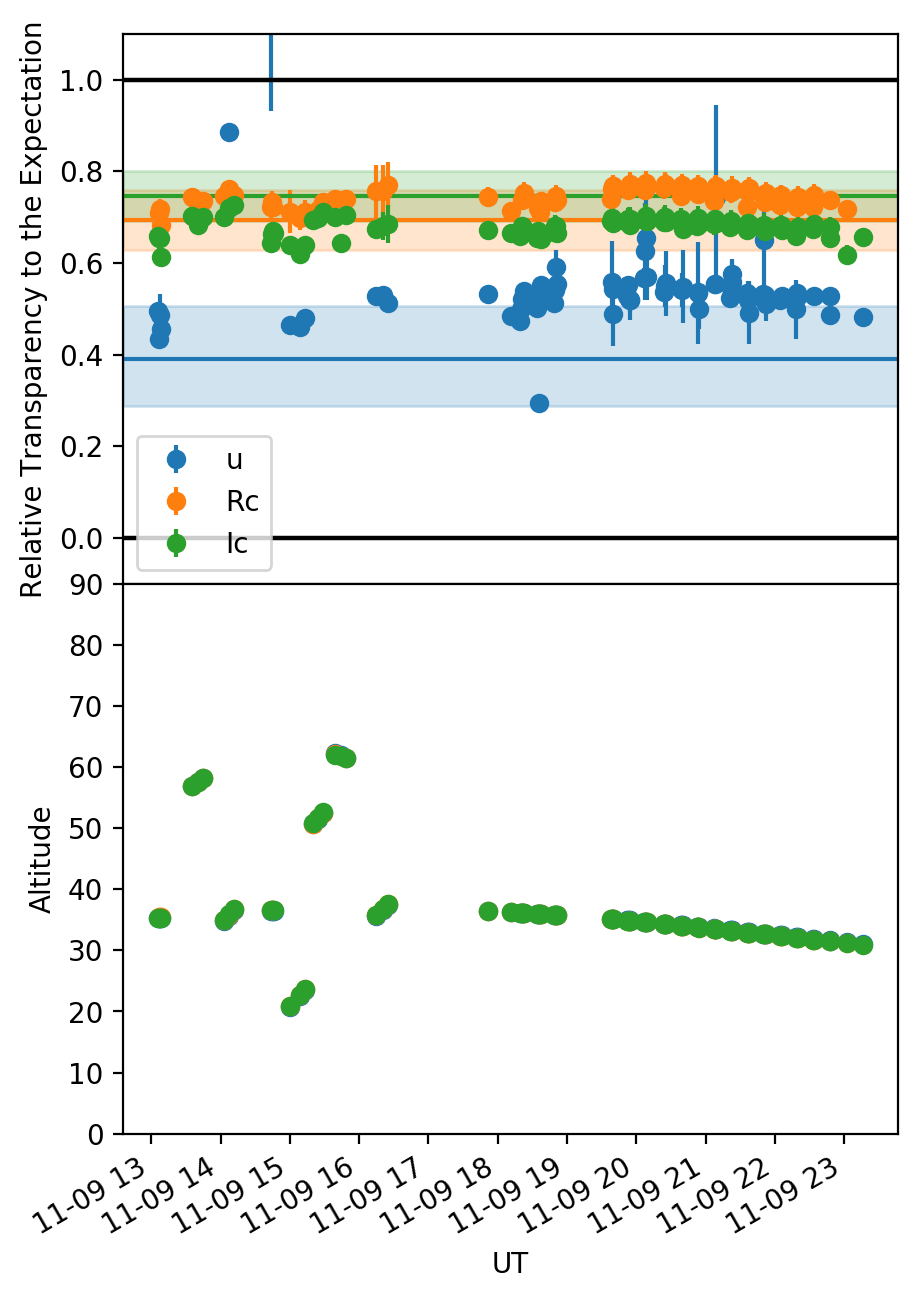

In [13]:
Ali = EarthLocation.from_geodetic(lat=32.31373, lon=80.030018, height=5100)
mkplot(result, Ali, target, 6 )

In [14]:
target = "20181017/*object*-2/object*.new"
offset = [-5,14] # for u-band coase alignment

In [15]:
result20181017 = loopover(target,offset)

0/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82949250722  34.2917662783  
CRPIX : 1346.56982422  747.871246338  
CD1_1 CD1_2  : 0.000188211140326  1.50618858037e-06  
CD2_1 CD2_2  : -1.62255650515e-06  0.000186499510004  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017140725-2/object20181017140725-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.15513234209326 13.696888827993446 
{'median': nan, 'std': nan, 'limitmag': 16.15513234209326}
0/61
None [-5, 14]
20181017/object20181017140725-1/object20181017140725-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.353377331386888 14.059979266287502 
{'median': nan, 'std': nan, 'limitmag': 16.353377331386888}
0/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82949250722  34.2917662783  
CRPIX : 1351.56982422  733.87124634  
PC1_1 PC1_2  : 0.000188211140326  1.50618858037e-06  
PC2_1 PC2_2  : -1.62255650515e-06  0.000186499510004  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017140725-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.362015383909384 14.670597142396936 
{'median': nan, 'std': nan, 'limitmag': 16.362015383909384}
1/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72207596977  34.3691458988  
CRPIX : 849.025421143  1167.52171326  
CD1_1 CD1_2  : 0.000188215103777  1.35805073166e-06  
CD2_1 CD2_2  : -1.29767636774e-06  0.000186406311584  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142824-2/object20181017142824-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.15509117382342 14.339961471108492 
{'median': nan, 'std': nan, 'limitmag': 16.15509117382342}
1/61
None [-5, 14]
20181017/object20181017142824-1/object20181017142824-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.3225975412544 14.59255907097473 
{'median': nan, 'std': nan, 'limitmag': 16.3225975412544}
1/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72207596977  34.3691458988  
CRPIX : 854.02542114  1153.52171326  
PC1_1 PC1_2  : 0.000188215103777  1.35805073166e-06  
PC2_1 PC2_2  : -1.29767636774e-06  0.000186406311584  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142824-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.36199621480881 14.664539734194904 
{'median': nan, 'std': nan, 'limitmag': 16.36199621480881}
2/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82937765529  34.2916638025  
CRPIX : 1296.20539856  764.921920776  
CD1_1 CD1_2  : 0.000188169194304  1.65580165825e-06  
CD2_1 CD2_2  : -1.97667242567e-06  0.000186961103353  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017145552-2/object20181017145552-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.15515878466457 14.57787458116208 
{'median': nan, 'std': nan, 'limitmag': 16.15515878466457}
2/61
None [-5, 14]
20181017/object20181017145552-1/object20181017145552-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.35772014065054 14.840541161703042 
{'median': nan, 'std': nan, 'limitmag': 16.35772014065054}
2/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82937765529  34.2916638025  
CRPIX : 1301.20539856  750.92192078  
PC1_1 PC1_2  : 0.000188169194304  1.65580165825e-06  
PC2_1 PC2_2  : -1.97667242567e-06  0.000186961103353  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017145552-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.36151697200591 14.660413890644213 
{'median': nan, 'std': nan, 'limitmag': 16.36151697200591}
3/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82926886565  34.2918834092  
CRPIX : 1283.75979614  769.632675171  
CD1_1 CD1_2  : 0.000188301372399  1.46588310729e-06  
CD2_1 CD2_2  : -1.9506083119e-06  0.000186751868099  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017150934-2/object20181017150934-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.1557669412542 14.49863855059808 
{'median': nan, 'std': nan, 'limitmag': 16.1557669412542}
3/61
None [-5, 14]
20181017/object20181017150934-1/object20181017150934-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.349905748442957 14.761123232687662 
{'median': nan, 'std': nan, 'limitmag': 16.349905748442957}
3/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82926886565  34.2918834092  
CRPIX : 1288.75979614  755.63267517  
PC1_1 PC1_2  : 0.000188301372399  1.46588310729e-06  
PC2_1 PC2_2  : -1.9506083119e-06  0.000186751868099  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017150934-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.360714602344377 14.67041122737482 
{'median': nan, 'std': nan, 'limitmag': 16.360714602344377}
4/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72201299933  34.3689477065  
CRPIX : 809.3387146  1181.58253479  
CD1_1 CD1_2  : 0.00018805453476  1.48381883791e-06  
CD2_1 CD2_2  : -1.512739526e-06  0.000187098869344  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017151056-2/object20181017151056-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.156904199662947 14.56044405313989 
{'median': nan, 'std': nan, 'limitmag': 16.156904199662947}
4/61
None [-5, 14]
20181017/object20181017151056-1/object20181017151056-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.347046396948212 14.820699088236783 
{'median': nan, 'std': nan, 'limitmag': 16.347046396948212}
4/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72201299933  34.3689477065  
CRPIX : 814.3387146  1167.58253479  
PC1_1 PC1_2  : 0.00018805453476  1.48381883791e-06  
PC2_1 PC2_2  : -1.512739526e-06  0.000187098869344  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017151056-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361346360476205 14.392231741045352 
{'median': nan, 'std': nan, 'limitmag': 16.361346360476205}
5/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82949348831  34.2917822262  
CRPIX : 1284.07809448  768.772476196  
CD1_1 CD1_2  : 0.000188179133703  1.50239903188e-06  
CD2_1 CD2_2  : -1.56005427064e-06  0.000186461116893  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017151251-2/object20181017151251-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155678167392836 13.845544582734863 
{'median': nan, 'std': nan, 'limitmag': 16.155678167392836}
5/61
None [-5, 14]
20181017/object20181017151251-1/object20181017151251-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 16.342964589746508 14.163936895502653 
{'median': 0.7151309819018302, 'std': 0.0, 'limitmag': 16.342964589746508}
5/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82949348831  34.2917822262  
CRPIX : 1289.07809448  754.7724762  
PC1_1 PC1_2  : 0.000188179133703  1.50239903188e-06  
PC2_1 PC2_2  : -1.56005427064e-06  0.000186461116893  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017151251-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.362279353501727 14.671844466924426 
{'median': nan, 'std': nan, 'limitmag': 16.362279353501727}
6/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.4857754273  -0.0636351740826  
CRPIX : 1546.95983887  646.473629951  
CD1_1 CD1_2  : 0.000188360802569  1.23957515073e-06  
CD2_1 CD2_2  : -1.26639910755e-06  0.000186541211762  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017172025-2/object20181017172025-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.48061640344584 16.41294404327119 
{'median': 0.34017007017518075, 'std': 0.019187084174624003, 'limitmag': 19.48061640344584}
6/61
None [-5, 14]
20181017/object20181017172025-1/object20181017172025-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.92578674046017 16.489329255955006 
{'median': 0.4033890920508853, 'std': 0.008306737611602999, 'limitmag': 19.92578674046017}
6/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.4857754273  -0.0636351740826  
CRPIX : 1551.95983887  632.47362995  
PC1_1 PC1_2  : 0.000188360802569  1.23957515073e-06  
PC2_1 PC2_2  : -1.26639910755e-06  0.000186541211762  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017172025-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.845367031470715 16.019753157875307 
{'median': nan, 'std': nan, 'limitmag': 16.845367031470715}
7/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 13.6441757349  0.671879382727  
CRPIX : 1145.01066589  1010.82325745  
CD1_1 CD1_2  : 0.000188232125758  1.59420517344e-06  
CD2_1 CD2_2  : -1.55284159973e-06  0.000186463302865  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017172828-2/object20181017172828-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.653961365946145 15.434901391391861 
{'median': 0.3735431882843535, 'std': 0.006121292818936308, 'limitmag': 19.653961365946145}
7/61
None [-5, 14]
20181017/object20181017172828-1/object20181017172828-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 20.011262182149334 15.907210093581043 
{'median': 0.43487426301509846, 'std': 0.005291787425978078, 'limitmag': 20.011262182149334}
7/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 13.6441757349  0.671879382727  
CRPIX : 1150.01066589  996.82325745  
PC1_1 PC1_2  : 0.000188232125758  1.59420517344e-06  
PC2_1 PC2_2  : -1.55284159973e-06  0.000186463302865  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017172828-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.864799722748828 16.02569922736592 
{'median': nan, 'std': nan, 'limitmag': 16.864799722748828}
8/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 13.6441753994  0.671880257721  
CRPIX : 1146.39713287  1010.15740967  
CD1_1 CD1_2  : 0.000188237456983  1.58818383773e-06  
CD2_1 CD2_2  : -1.57245364259e-06  0.000186479016568  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017173010-2/object20181017173010-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.66261914700064 15.435179029052254 
{'median': 0.3519177610733605, 'std': 0.005059286952662251, 'limitmag': 19.66261914700064}
8/61
None [-5, 14]
20181017/object20181017173010-1/object20181017173010-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 20.017439428990052 15.903219817758721 
{'median': 0.4045821058740243, 'std': 0.004997983554421215, 'limitmag': 20.017439428990052}
8/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 13.6441753994  0.671880257721  
CRPIX : 1151.39713287  996.15740967  
PC1_1 PC1_2  : 0.000188237456983  1.58818383773e-06  
PC2_1 PC2_2  : -1.57245364259e-06  0.000186479016568  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017173010-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.861205435014067 16.023381734642996 
{'median': nan, 'std': nan, 'limitmag': 16.861205435014067}
9/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 0.590771919153  -2.9300005107  
CRPIX : 1333.93202209  895.497077942  
CD1_1 CD1_2  : 0.000188329243538  1.91761618889e-06  
CD2_1 CD2_2  : -1.47072183531e-06  0.0001865615745  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017174946-2/object20181017174946-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 19.86962150355326 14.49744770487664 
{'median': nan, 'std': nan, 'limitmag': 19.86962150355326}
9/61
None [-5, 14]
20181017/object20181017174946-1/object20181017174946-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 20.269601705483787 14.848019219739442 
{'median': nan, 'std': nan, 'limitmag': 20.269601705483787}
9/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 0.590771919153  -2.9300005107  
CRPIX : 1338.93202209  881.49707794  
PC1_1 PC1_2  : 0.000188329243538  1.91761618889e-06  
PC2_1 PC2_2  : -1.47072183531e-06  0.0001865615745  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017174946-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.86873086750027 14.370953308075507 
{'median': nan, 'std': nan, 'limitmag': 16.86873086750027}
10/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 297.738597885  8.80442979767  
CRPIX : 1029.90638733  1590.02706909  
CD1_1 CD1_2  : 0.00018824010532  2.09834420605e-06  
CD2_1 CD2_2  : -1.89458436161e-06  0.00018648474503  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017131838-2/object20181017131838-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 13.660959988110681 8.934283426252504 
{'median': nan, 'std': nan, 'limitmag': 13.660959988110681}
10/61
None [-5, 14]
20181017/object20181017131838-1/object20181017131838-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 13.901973089978465 9.06606006106897 
{'median': 0.7791439957911772, 'std': 0.0, 'limitmag': 13.901973089978465}
10/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 297.738597885  8.80442979767  
CRPIX : 1034.90638733  1576.02706909  
PC1_1 PC1_2  : 0.00018824010532  2.09834420605e-06  
PC2_1 PC2_2  : -1.89458436161e-06  0.00018648474503  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017131838-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 12.722366667011084 9.074815296260905 
{'median': nan, 'std': nan, 'limitmag': 12.722366667011084}
11/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 297.738612249  8.80442463588  
CRPIX : 1142.9250946  606.807132721  
CD1_1 CD1_2  : 0.00018815604669  1.9875560711e-06  
CD2_1 CD2_2  : -1.93107015046e-06  0.000186561536579  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017132226-2/object20181017132226-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 13.65946202108951 8.656193166943662 
{'median': nan, 'std': nan, 'limitmag': 13.65946202108951}
11/61
None [-5, 14]
20181017/object20181017132226-1/object20181017132226-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 13.914950701743955 8.795363886325031 
{'median': 0.8519897756805352, 'std': 0.0, 'limitmag': 13.914950701743955}
11/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 297.738612249  8.80442463588  
CRPIX : 1147.9250946  592.80713272  
PC1_1 PC1_2  : 0.00018815604669  1.9875560711e-06  
PC2_1 PC2_2  : -1.93107015046e-06  0.000186561536579  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017132226-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 12.721309917115548 8.925356150463049 
{'median': nan, 'std': nan, 'limitmag': 12.721309917115548}
12/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.415814175  36.5140378533  
CRPIX : 949.020061493  990.173171997  
CD1_1 CD1_2  : 0.000188145822817  2.02314814759e-06  
CD2_1 CD2_2  : -1.94077488743e-06  0.000186395778971  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017132651-2/object20181017132651-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.15317056518194 15.527930888535465 
{'median': 0.3829763840392403, 'std': 0.03020268274481147, 'limitmag': 19.15317056518194}
12/61
None [-5, 14]
20181017/object20181017132651-1/object20181017132651-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.605608712488984 15.781778099587878 
{'median': 0.3130756286135268, 'std': 0.049977402013607564, 'limitmag': 19.605608712488984}
12/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.415814175  36.5140378533  
CRPIX : 954.020061493  976.173171997  
PC1_1 PC1_2  : 0.000188145822817  2.02314814759e-06  
PC2_1 PC2_2  : -1.94077488743e-06  0.000186395778971  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017132651-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.818950236509412 15.776447679930037 
{'median': nan, 'std': nan, 'limitmag': 16.818950236509412}
13/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72221670258  34.3689468646  
CRPIX : 855.114639282  1166.59532166  
CD1_1 CD1_2  : 0.000188510411636  1.75304241507e-06  
CD2_1 CD2_2  : -1.23702715494e-06  0.000186888117443  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142014-2/object20181017142014-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155265926642596 14.615457647633608 
{'median': nan, 'std': nan, 'limitmag': 16.155265926642596}
13/61
None [-5, 14]
20181017/object20181017142014-1/object20181017142014-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.331861252678106 14.971202368896746 
{'median': nan, 'std': nan, 'limitmag': 16.331861252678106}
13/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72221670258  34.3689468646  
CRPIX : 860.11463928  1152.59532166  
PC1_1 PC1_2  : 0.000188510411636  1.75304241507e-06  
PC2_1 PC2_2  : -1.23702715494e-06  0.000186888117443  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142014-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.363528159782753 14.666567533664827 
{'median': nan, 'std': nan, 'limitmag': 16.363528159782753}
14/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72211400173  34.369119489  
CRPIX : 858.496795654  1164.87336731  
CD1_1 CD1_2  : 0.000188548083274  1.14403421512e-06  
CD2_1 CD2_2  : -1.25598107245e-06  0.000187333810212  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142034-2/object20181017142034-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155081389944957 14.65583362036213 
{'median': nan, 'std': nan, 'limitmag': 16.155081389944957}
14/61
None [-5, 14]
20181017/object20181017142034-1/object20181017142034-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.333378673407196 15.008833781435591 
{'median': nan, 'std': nan, 'limitmag': 16.333378673407196}
14/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72211400173  34.369119489  
CRPIX : 863.49679565  1150.87336731  
PC1_1 PC1_2  : 0.000188548083274  1.14403421512e-06  
PC2_1 PC2_2  : -1.25598107245e-06  0.000187333810212  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142034-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.36289089886909 14.662299889438358 
{'median': nan, 'std': nan, 'limitmag': 16.36289089886909}
15/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72227083783  34.3691068197  
CRPIX : 857.387390137  1165.55274963  
CD1_1 CD1_2  : 0.000188559646682  1.4095686504e-06  
CD2_1 CD2_2  : -1.48946692398e-06  0.00018671454198  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142150-2/object20181017142150-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155029853877355 14.454386567494534 
{'median': nan, 'std': nan, 'limitmag': 16.155029853877355}
15/61
None [-5, 14]
20181017/object20181017142150-1/object20181017142150-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.331865214927817 14.816140251267356 
{'median': nan, 'std': nan, 'limitmag': 16.331865214927817}
15/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72227083783  34.3691068197  
CRPIX : 862.38739014  1151.55274963  
PC1_1 PC1_2  : 0.000188559646682  1.4095686504e-06  
PC2_1 PC2_2  : -1.48946692398e-06  0.00018671454198  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142150-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.362773111250494 14.669413618252715 
{'median': nan, 'std': nan, 'limitmag': 16.362773111250494}
16/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82957160219  34.2917209167  
CRPIX : 1280.01899719  769.777084351  
CD1_1 CD1_2  : 0.000188367321901  1.09143700476e-06  
CD2_1 CD2_2  : -1.44107833941e-06  0.000187383188177  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017151431-2/object20181017151431-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155814817425213 14.45672468560585 
{'median': nan, 'std': nan, 'limitmag': 16.155814817425213}
16/61
None [-5, 14]
20181017/object20181017151431-1/object20181017151431-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.34033721916087 14.818026569269735 
{'median': nan, 'std': nan, 'limitmag': 16.34033721916087}
16/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82957160219  34.2917209167  
CRPIX : 1285.01899719  755.77708435  
PC1_1 PC1_2  : 0.000188367321901  1.09143700476e-06  
PC2_1 PC2_2  : -1.44107833941e-06  0.000187383188177  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017151431-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361634470233604 14.669102921590174 
{'median': nan, 'std': nan, 'limitmag': 16.361634470233604}
17/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.485784881  -0.0635967004942  
CRPIX : 1546.29727173  648.208585739  
CD1_1 CD1_2  : 0.000188288137594  1.27479339736e-06  
CD2_1 CD2_2  : -1.26309032677e-06  0.000186569088756  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017172200-2/object20181017172200-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.485986107170476 16.450321765187223 
{'median': 0.3358854219865922, 'std': 0.011038065613037662, 'limitmag': 19.485986107170476}
17/61
None [-5, 14]
20181017/object20181017172200-1/object20181017172200-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.928025722018685 16.51123515730758 
{'median': 0.3980757777849847, 'std': 0.015098894547577069, 'limitmag': 19.928025722018685}
17/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.485784881  -0.0635967004942  
CRPIX : 1551.29727173  634.20858574  
PC1_1 PC1_2  : 0.000188288137594  1.27479339736e-06  
PC2_1 PC2_2  : -1.26309032677e-06  0.000186569088756  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017172200-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.850248642923614 16.02219859983371 
{'median': nan, 'std': nan, 'limitmag': 16.850248642923614}
18/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 214.103273604  19.1789617962  
CRPIX : 3.38757503033  1100.68981171  
CD1_1 CD1_2  : 1.25283501619e-06  5.18857059332e-05  
CD2_1 CD2_2  : 5.18857059332e-05  -1.25283501619e-06  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017125821-2/object20181017125821-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.60392645011966 16.194526437234032 
{'median': nan, 'std': nan, 'limitmag': 16.60392645011966}
18/61
None [-5, 14]
20181017/object20181017125821-1/object20181017125821-1.new
18/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 214.103273604  19.1789617962  
CRPIX : 8.38757503  1086.68981171  
PC1_1 PC1_2  : 1.25283501619e-06  5.18857059332e-05  
PC2_1 PC2_2  : 5.18857059332e-05  -1.25283501619e-06  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017125821-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.654767363855076 15.348800413761346 
{'median': nan, 'std': nan, 'limitmag': 16.654767363855076}
19/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 247.488191848  -26.4340746501  
CRPIX : 3.43955558538  1162.24821472  
CD1_1 CD1_2  : -1.09146987365e-06  -6.53493787732e-05  
CD2_1 CD2_2  : -6.53493787732e-05  1.09146987365e-06  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017130256-2/object20181017130256-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.16011191152646 15.782559440742487 
{'median': nan, 'std': nan, 'limitmag': 16.16011191152646}
19/61
None [-5, 14]
20181017/object20181017130256-1/object20181017130256-1.new
19/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 247.488191848  -26.4340746501  
CRPIX : 8.43955559  1148.24821472  
PC1_1 PC1_2  : -1.09146987365e-06  -6.53493787732e-05  
PC2_1 PC2_2  : -6.53493787732e-05  1.09146987365e-06  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017130256-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.260357928008663 14.432819771861958 
{'median': nan, 'std': nan, 'limitmag': 16.260357928008663}
20/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 297.738559693  8.80445002769  
CRPIX : 1031.09516907  1518.21017456  
CD1_1 CD1_2  : 0.000188160315239  1.9556017576e-06  
CD2_1 CD2_2  : -1.91469698904e-06  0.000186361993381  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017132010-2/object20181017132010-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 13.65979935566125 8.95450506392341 
{'median': nan, 'std': nan, 'limitmag': 13.65979935566125}
20/61
None [-5, 14]
20181017/object20181017132010-1/object20181017132010-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 13.916027928214472 9.084229234393487 
{'median': 0.7451217488259817, 'std': 0.0, 'limitmag': 13.916027928214472}
20/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 297.738559693  8.80445002769  
CRPIX : 1036.09516907  1504.21017456  
PC1_1 PC1_2  : 0.000188160315239  1.9556017576e-06  
PC2_1 PC2_2  : -1.91469698904e-06  0.000186361993381  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017132010-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 12.721705136497404 9.195502522790198 
{'median': nan, 'std': nan, 'limitmag': 12.721705136497404}
21/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72202118154  34.369115544  
CRPIX : 882.552032471  1151.99516296  
CD1_1 CD1_2  : 0.000188083823883  1.36282958089e-06  
CD2_1 CD2_2  : -1.30188616605e-06  0.000186376446921  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017134938-2/object20181017134938-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.154995648745693 14.033319817026893 
{'median': nan, 'std': nan, 'limitmag': 16.154995648745693}
21/61
None [-5, 14]
20181017/object20181017134938-1/object20181017134938-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.363280613106145 14.399622801277186 
{'median': nan, 'std': nan, 'limitmag': 16.363280613106145}
21/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72202118154  34.369115544  
CRPIX : 887.55203247  1137.99516296  
PC1_1 PC1_2  : 0.000188083823883  1.36282958089e-06  
PC2_1 PC2_2  : -1.30188616605e-06  0.000186376446921  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017134938-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 15.127558473558887 14.102701460747378 
{'median': nan, 'std': nan, 'limitmag': 15.127558473558887}
22/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72205276025  34.3691154397  
CRPIX : 856.304534912  1165.84413147  
CD1_1 CD1_2  : 0.000188213667833  1.33393938594e-06  
CD2_1 CD2_2  : -1.31931645256e-06  0.000186505515917  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142344-2/object20181017142344-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.15502284714219 14.037304819347735 
{'median': nan, 'std': nan, 'limitmag': 16.15502284714219}
22/61
None [-5, 14]
20181017/object20181017142344-1/object20181017142344-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.330113168519233 14.44388877947215 
{'median': nan, 'std': nan, 'limitmag': 16.330113168519233}
22/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72205276025  34.3691154397  
CRPIX : 861.30453491  1151.84413147  
PC1_1 PC1_2  : 0.000188213667833  1.33393938594e-06  
PC2_1 PC2_2  : -1.31931645256e-06  0.000186505515917  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142344-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.362290772785165 14.670002477656308 
{'median': nan, 'std': nan, 'limitmag': 16.362290772785165}
23/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.8294985203  34.2917036832  
CRPIX : 1326.85417175  753.672897339  
CD1_1 CD1_2  : 0.000188108763273  1.56209724492e-06  
CD2_1 CD2_2  : -1.5441003265e-06  0.000186362327665  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142641-2/object20181017142641-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.15505270163616 13.967763080769158 
{'median': nan, 'std': nan, 'limitmag': 16.15505270163616}
23/61
None [-5, 14]
20181017/object20181017142641-1/object20181017142641-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.32643371756626 14.262571981663966 
{'median': nan, 'std': nan, 'limitmag': 16.32643371756626}
23/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.8294985203  34.2917036832  
CRPIX : 1331.85417175  739.67289734  
PC1_1 PC1_2  : 0.000188108763273  1.56209724492e-06  
PC2_1 PC2_2  : -1.5441003265e-06  0.000186362327665  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142641-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.36214565107847 14.672416999577546 
{'median': nan, 'std': nan, 'limitmag': 16.36214565107847}
24/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82974099413  34.2915537774  
CRPIX : 1279.35992432  771.228408813  
CD1_1 CD1_2  : 0.000189185149998  1.05116205626e-06  
CD2_1 CD2_2  : -1.80056638644e-06  0.000186866942496  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017151500-2/object20181017151500-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155442770855256 14.71196242591294 
{'median': nan, 'std': nan, 'limitmag': 16.155442770855256}
24/61
None [-5, 14]
20181017/object20181017151500-1/object20181017151500-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.340627363047833 15.048338203233262 
{'median': nan, 'std': nan, 'limitmag': 16.340627363047833}
24/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82974099413  34.2915537774  
CRPIX : 1284.35992432  757.22840881  
PC1_1 PC1_2  : 0.000189185149998  1.05116205626e-06  
PC2_1 PC2_2  : -1.80056638644e-06  0.000186866942496  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017151500-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361031685234977 14.67015284878196 
{'median': nan, 'std': nan, 'limitmag': 16.361031685234977}
25/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553651145  5.85223734143  
CRPIX : 1477.37164307  1449.37033081  
CD1_1 CD1_2  : 0.000188193665412  1.65742973747e-06  
CD2_1 CD2_2  : -1.8619603984e-06  0.000186469968381  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017154116-2/object20181017154116-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.72714703441031 15.909809177282899 
{'median': 0.21025842399002476, 'std': 0.0032432466351027256, 'limitmag': 19.72714703441031}
25/61
None [-5, 14]
20181017/object20181017154116-1/object20181017154116-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.95910609388411 16.307980783374614 
{'median': 0.24240564016785604, 'std': 0.006629172526331412, 'limitmag': 19.95910609388411}
25/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553651145  5.85223734143  
CRPIX : 1482.37164307  1435.37033081  
PC1_1 PC1_2  : 0.000188193665412  1.65742973747e-06  
PC2_1 PC2_2  : -1.8619603984e-06  0.000186469968381  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017154116-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.84609326376363 16.019394951067262 
{'median': nan, 'std': nan, 'limitmag': 16.84609326376363}
26/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72217846223  34.3689878281  
CRPIX : 857.20954895  1165.00195312  
CD1_1 CD1_2  : 0.000188237667635  1.33579103083e-06  
CD2_1 CD2_2  : -9.53012188191e-07  0.00018675822101  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142132-2/object20181017142132-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155104616120695 14.520513044643447 
{'median': nan, 'std': nan, 'limitmag': 16.155104616120695}
26/61
None [-5, 14]
20181017/object20181017142132-1/object20181017142132-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.33195669108615 14.870030558921169 
{'median': nan, 'std': nan, 'limitmag': 16.33195669108615}
26/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72217846223  34.3689878281  
CRPIX : 862.20954895  1151.00195312  
PC1_1 PC1_2  : 0.000188237667635  1.33579103083e-06  
PC2_1 PC2_2  : -9.53012188191e-07  0.00018675822101  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142132-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.362615261452994 14.670108865621359 
{'median': nan, 'std': nan, 'limitmag': 16.362615261452994}
27/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72206223741  34.3691530391  
CRPIX : 854.054412842  1166.19473267  
CD1_1 CD1_2  : 0.000188209624311  1.30434625694e-06  
CD2_1 CD2_2  : -1.29315732186e-06  0.000186518916896  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142531-2/object20181017142531-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155020341025338 13.809769723139816 
{'median': nan, 'std': nan, 'limitmag': 16.155020341025338}
27/61
None [-5, 14]
20181017/object20181017142531-1/object20181017142531-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.328848733204083 14.18553166626271 
{'median': nan, 'std': nan, 'limitmag': 16.328848733204083}
27/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72206223741  34.3691530391  
CRPIX : 859.05441284  1152.19473267  
PC1_1 PC1_2  : 0.000188209624311  1.30434625694e-06  
PC2_1 PC2_2  : -1.29315732186e-06  0.000186518916896  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142531-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361373695727433 14.67115929356751 
{'median': nan, 'std': nan, 'limitmag': 16.361373695727433}
28/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82945732527  34.2917463064  
CRPIX : 1327.0483551  754.588928223  
CD1_1 CD1_2  : 0.000188200476309  1.42383933473e-06  
CD2_1 CD2_2  : -1.49644105951e-06  0.00018650520343  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142713-2/object20181017142713-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155036444427115 14.160012453685017 
{'median': nan, 'std': nan, 'limitmag': 16.155036444427115}
28/61
None [-5, 14]
20181017/object20181017142713-1/object20181017142713-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.326312133863784 14.435139103871602 
{'median': nan, 'std': nan, 'limitmag': 16.326312133863784}
28/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82945732527  34.2917463064  
CRPIX : 1332.0483551  740.58892822  
PC1_1 PC1_2  : 0.000188200476309  1.42383933473e-06  
PC2_1 PC2_2  : -1.49644105951e-06  0.00018650520343  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142713-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361575489877044 14.670953298361706 
{'median': nan, 'std': nan, 'limitmag': 16.361575489877044}
29/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82955794659  34.2917045549  
CRPIX : 1282.33256531  770.103302002  
CD1_1 CD1_2  : 0.00018818815438  1.52871988478e-06  
CD2_1 CD2_2  : -1.53923121519e-06  0.000186509617806  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017151402-2/object20181017151402-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155609595256823 14.214707723241935 
{'median': nan, 'std': nan, 'limitmag': 16.155609595256823}
29/61
None [-5, 14]
20181017/object20181017151402-1/object20181017151402-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.34045081179634 14.615201284111345 
{'median': nan, 'std': nan, 'limitmag': 16.34045081179634}
29/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82955794659  34.2917045549  
CRPIX : 1287.33256531  756.103302  
PC1_1 PC1_2  : 0.00018818815438  1.52871988478e-06  
PC2_1 PC2_2  : -1.53923121519e-06  0.000186509617806  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017151402-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361354371201283 14.671683871409066 
{'median': nan, 'std': nan, 'limitmag': 16.361354371201283}
30/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553654995  5.85221381899  
CRPIX : 1475.09828186  1450.22337341  
CD1_1 CD1_2  : 0.000188170209677  1.64960306877e-06  
CD2_1 CD2_2  : -1.85916807519e-06  0.000186482540505  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017153936-2/object20181017153936-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.721405516899072 15.894726064469584 
{'median': 0.2075298966436176, 'std': 0.0036016133773375536, 'limitmag': 19.721405516899072}
30/61
None [-5, 14]
20181017/object20181017153936-1/object20181017153936-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.96092545955137 16.314376943472936 
{'median': 0.24377469053394085, 'std': 0.0023909285832385274, 'limitmag': 19.96092545955137}
30/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553654995  5.85221381899  
CRPIX : 1480.09828186  1436.22337341  
PC1_1 PC1_2  : 0.000188170209677  1.64960306877e-06  
PC2_1 PC2_2  : -1.85916807519e-06  0.000186482540505  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017153936-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.85040972390678 16.023242722930192 
{'median': nan, 'std': nan, 'limitmag': 16.85040972390678}
31/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 38.3538414435  5.36458038193  
CRPIX : 676.10244751  1134.52693176  
CD1_1 CD1_2  : 0.000188195273035  1.30852869715e-06  
CD2_1 CD2_2  : -1.27156799748e-06  0.00018651040623  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017154835-2/object20181017154835-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.53890942759661 16.29742598468812 
{'median': 0.39183036554182255, 'std': 0.0009562960115821473, 'limitmag': 19.53890942759661}
31/61
None [-5, 14]
20181017/object20181017154835-1/object20181017154835-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.939046132925572 16.553772414601355 
{'median': 0.45864448377351874, 'std': 0.004591519860146831, 'limitmag': 19.939046132925572}
31/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 38.3538414435  5.36458038193  
CRPIX : 681.10244751  1120.52693176  
PC1_1 PC1_2  : 0.000188195273035  1.30852869715e-06  
PC2_1 PC2_2  : -1.27156799748e-06  0.00018651040623  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017154835-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.85306848745268 16.019965360463804 
{'median': nan, 'std': nan, 'limitmag': 16.85306848745268}
32/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8832647883  13.5444770478  
CRPIX : 847.451324463  1386.08270264  
CD1_1 CD1_2  : 0.000188171365929  1.37394134463e-06  
CD2_1 CD2_2  : -1.26184936853e-06  0.000186581192225  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017155554-2/object20181017155554-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.567548812391486 17.49735236526413 
{'median': 0.40313621697824076, 'std': 1.911264480647379e-05, 'limitmag': 19.567548812391486}
32/61
None [-5, 14]
20181017/object20181017155554-1/object20181017155554-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.981079869860427 17.600019725433892 
{'median': 0.45964605194964236, 'std': 0.005788270726725719, 'limitmag': 19.981079869860427}
32/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8832647883  13.5444770478  
CRPIX : 852.45132446  1372.08270264  
PC1_1 PC1_2  : 0.000188171365929  1.37394134463e-06  
PC2_1 PC2_2  : -1.26184936853e-06  0.000186581192225  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017155554-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.85365344461195 16.02697998712077 
{'median': nan, 'std': nan, 'limitmag': 16.85365344461195}
33/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 311.013010249  -10.8371781364  
CRPIX : 1327.16189575  570.108360291  
CD1_1 CD1_2  : 0.000188195007897  2.03145540406e-06  
CD2_1 CD2_2  : -1.88699833036e-06  0.000186507221923  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017170321-2/object20181017170321-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.569273297641224 15.298821746580145 
{'median': nan, 'std': nan, 'limitmag': 17.569273297641224}
33/61
None [-5, 14]
20181017/object20181017170321-1/object20181017170321-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.013198502916246 15.80147479950538 
{'median': 0.3852132422133672, 'std': 0.016409507379406385, 'limitmag': 18.013198502916246}
33/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 311.013010249  -10.8371781364  
CRPIX : 1332.16189575  556.10836029  
PC1_1 PC1_2  : 0.000188195007897  2.03145540406e-06  
PC2_1 PC2_2  : -1.88699833036e-06  0.000186507221923  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017170321-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.854158403093344 16.026098751324838 
{'median': nan, 'std': nan, 'limitmag': 16.854158403093344}
34/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.485783877  -0.0636183170718  
CRPIX : 1547.48001099  644.916015625  
CD1_1 CD1_2  : 0.000188325153027  1.24698072706e-06  
CD2_1 CD2_2  : -1.33101814841e-06  0.000186569637211  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017171734-2/object20181017171734-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.487906859538583 16.41220537755703 
{'median': 0.345464331895739, 'std': 0.016643986001823097, 'limitmag': 19.487906859538583}
34/61
None [-5, 14]
20181017/object20181017171734-1/object20181017171734-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.926848496639597 16.481507609849693 
{'median': 0.4130729112088892, 'std': 0.004373397497373588, 'limitmag': 19.926848496639597}
34/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.485783877  -0.0636183170718  
CRPIX : 1552.48001099  630.91601562  
PC1_1 PC1_2  : 0.000188325153027  1.24698072706e-06  
PC2_1 PC2_2  : -1.33101814841e-06  0.000186569637211  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017171734-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.84576464617745 16.017788339263074 
{'median': nan, 'std': nan, 'limitmag': 16.84576464617745}
35/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 0.496491466207  -2.92535702028  
CRPIX : 836.571182251  911.33946991  
CD1_1 CD1_2  : 0.000188163423434  1.78459638711e-06  
CD2_1 CD2_2  : -1.63268547897e-06  0.000186535016992  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017175234-2/object20181017175234-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 19.867880206848774 14.502482606522499 
{'median': nan, 'std': nan, 'limitmag': 19.867880206848774}
35/61
None [-5, 14]
20181017/object20181017175234-1/object20181017175234-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 20.267059896708233 14.833288430401382 
{'median': nan, 'std': nan, 'limitmag': 20.267059896708233}
35/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 0.496491466207  -2.92535702028  
CRPIX : 841.571182251  897.33946991  
PC1_1 PC1_2  : 0.000188163423434  1.78459638711e-06  
PC2_1 PC2_2  : -1.63268547897e-06  0.000186535016992  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017175234-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.863543923111262 14.364298957805646 
{'median': nan, 'std': nan, 'limitmag': 16.863543923111262}
36/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8832625074  13.5444828582  
CRPIX : 844.015518188  1389.51594543  
CD1_1 CD1_2  : 0.000188160827578  1.40869603294e-06  
CD2_1 CD2_2  : -1.24655184621e-06  0.0001864929749  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017160132-2/object20181017160132-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.580706323946405 17.496369719263985 
{'median': 0.4060259878973525, 'std': 0.002398525858678058, 'limitmag': 19.580706323946405}
36/61
None [-5, 14]
20181017/object20181017160132-1/object20181017160132-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.984510357141392 17.596063252467623 
{'median': 0.46478960988789747, 'std': 0.0025104149735412085, 'limitmag': 19.984510357141392}
36/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8832625074  13.5444828582  
CRPIX : 849.01551819  1375.51594543  
PC1_1 PC1_2  : 0.000188160827578  1.40869603294e-06  
PC2_1 PC2_2  : -1.24655184621e-06  0.0001864929749  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017160132-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.860929138311857 16.03096096342647 
{'median': nan, 'std': nan, 'limitmag': 16.860929138311857}
37/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.9428089068  13.5202882666  
CRPIX : 1150.87091064  1262.44721985  
CD1_1 CD1_2  : 0.000188059324302  1.42379015735e-06  
CD2_1 CD2_2  : -1.30853378093e-06  0.000186477890954  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017160414-2/object20181017160414-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.581925321482036 17.668925210214436 
{'median': 0.371784405232207, 'std': 0.0011191116284483549, 'limitmag': 19.581925321482036}
37/61
None [-5, 14]
20181017/object20181017160414-1/object20181017160414-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.983771399645814 17.75330407499957 
{'median': 0.4210686794882117, 'std': 0.00446945772612406, 'limitmag': 19.983771399645814}
37/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.9428089068  13.5202882666  
CRPIX : 1155.87091064  1248.44721985  
PC1_1 PC1_2  : 0.000188059324302  1.42379015735e-06  
PC2_1 PC2_2  : -1.30853378093e-06  0.000186477890954  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017160414-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.86111230647287 16.03035944502429 
{'median': nan, 'std': nan, 'limitmag': 16.86111230647287}
38/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 297.738684389  8.80442275517  
CRPIX : 1145.04136658  416.482073784  
CD1_1 CD1_2  : 0.000188313677211  2.10312133276e-06  
CD2_1 CD2_2  : -1.96961466879e-06  0.000186538213335  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017132140-2/object20181017132140-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 13.659713130141142 8.560313243883698 
{'median': nan, 'std': nan, 'limitmag': 13.659713130141142}
38/61
None [-5, 14]
20181017/object20181017132140-1/object20181017132140-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 13.922379554827005 8.824246685621137 
{'median': 0.874989771595055, 'std': 0.0, 'limitmag': 13.922379554827005}
38/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 297.738684389  8.80442275517  
CRPIX : 1150.04136658  402.48207378  
PC1_1 PC1_2  : 0.000188313677211  2.10312133276e-06  
PC2_1 PC2_2  : -1.96961466879e-06  0.000186538213335  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017132140-0.fits


FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 12.721213725404771 8.914482619610379 
{'median': nan, 'std': nan, 'limitmag': 12.721213725404771}
39/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72249783183  34.3694663069  
CRPIX : 857.703979492  1165.76046753  
CD1_1 CD1_2  : 0.00018849548157  1.72249448666e-06  
CD2_1 CD2_2  : -1.63065346698e-06  0.000186952834645  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017141955-2/object20181017141955-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155106148625478 14.642942206882212 
{'median': nan, 'std': nan, 'limitmag': 16.155106148625478}
39/61
None [-5, 14]
20181017/object20181017141955-1/object20181017141955-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.334028366495428 14.992903032755404 
{'median': nan, 'std': nan, 'limitmag': 16.334028366495428}
39/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72249783183  34.3694663069  
CRPIX : 862.70397949  1151.76046753  
PC1_1 PC1_2  : 0.00018849548157  1.72249448666e-06  
PC2_1 PC2_2  : -1.63065346698e-06  0.000186952834645  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017141955-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361631607429377 14.635551256614828 
{'median': nan, 'std': nan, 'limitmag': 16.361631607429377}
40/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72203759066  34.3691597929  
CRPIX : 852.448501587  1165.33486938  
CD1_1 CD1_2  : 0.000188136775462  1.28606988774e-06  
CD2_1 CD2_2  : -1.31167155993e-06  0.000186404658385  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142625-2/object20181017142625-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155045545137867 14.040781612460789 
{'median': nan, 'std': nan, 'limitmag': 16.155045545137867}
40/61
None [-5, 14]
20181017/object20181017142625-1/object20181017142625-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.32399772797793 14.345939443146767 
{'median': nan, 'std': nan, 'limitmag': 16.32399772797793}
40/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72203759066  34.3691597929  
CRPIX : 857.44850159  1151.33486938  
PC1_1 PC1_2  : 0.000188136775462  1.28606988774e-06  
PC2_1 PC2_2  : -1.31167155993e-06  0.000186404658385  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142625-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.36201539596585 14.668282662520083 
{'median': nan, 'std': nan, 'limitmag': 16.36201539596585}
41/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 101.185149145  44.821832876  
CRPIX : 1497.13092041  999.004272461  
CD1_1 CD1_2  : 0.000188330127277  1.18236964548e-06  
CD2_1 CD2_2  : -1.41348517062e-06  0.000186562971619  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017174241-2/object20181017174241-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.37909571819713 15.91343457579029 
{'median': 0.3681336253927622, 'std': 0.012281905967069406, 'limitmag': 19.37909571819713}
41/61
None [-5, 14]
20181017/object20181017174241-1/object20181017174241-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.836433674618867 16.343859586946742 
{'median': 0.4152235659678993, 'std': 0.011029724215895043, 'limitmag': 19.836433674618867}
41/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 101.185149145  44.821832876  
CRPIX : 1502.13092041  985.00427246  
PC1_1 PC1_2  : 0.000188330127277  1.18236964548e-06  
PC2_1 PC2_2  : -1.41348517062e-06  0.000186562971619  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017174241-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.849779691868804 16.030019982336675 
{'median': nan, 'std': nan, 'limitmag': 16.849779691868804}
42/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82953023866  34.2917214273  
CRPIX : 1330.36869812  753.961990356  
CD1_1 CD1_2  : 0.000188198164648  1.40807624151e-06  
CD2_1 CD2_2  : -1.49868726012e-06  0.000186468740617  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142408-2/object20181017142408-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.15500503199879 14.06197544990337 
{'median': nan, 'std': nan, 'limitmag': 16.15500503199879}
42/61
None [-5, 14]
20181017/object20181017142408-1/object20181017142408-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.331736642267437 14.4664182853838 
{'median': nan, 'std': nan, 'limitmag': 16.331736642267437}
42/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82953023866  34.2917214273  
CRPIX : 1335.36869812  739.96199036  
PC1_1 PC1_2  : 0.000188198164648  1.40807624151e-06  
PC2_1 PC2_2  : -1.49868726012e-06  0.000186468740617  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142408-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361991287644443 14.544207139094512 
{'median': nan, 'std': nan, 'limitmag': 16.361991287644443}
43/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.8294429739  34.2916928252  
CRPIX : 1325.18026733  755.721343994  
CD1_1 CD1_2  : 0.000188162428043  1.56299595103e-06  
CD2_1 CD2_2  : -1.56171987559e-06  0.000186479919348  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142758-2/object20181017142758-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155188565178758 14.311857157725749 
{'median': nan, 'std': nan, 'limitmag': 16.155188565178758}
43/61
None [-5, 14]
20181017/object20181017142758-1/object20181017142758-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.324160399384354 14.552741028444833 
{'median': nan, 'std': nan, 'limitmag': 16.324160399384354}
43/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.8294429739  34.2916928252  
CRPIX : 1330.18026733  741.72134399  
PC1_1 PC1_2  : 0.000188162428043  1.56299595103e-06  
PC2_1 PC2_2  : -1.56171987559e-06  0.000186479919348  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142758-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.36146146021952 14.671826781372319 
{'median': nan, 'std': nan, 'limitmag': 16.36146146021952}
44/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82944529968  34.29168382  
CRPIX : 1323.46134949  755.506530762  
CD1_1 CD1_2  : 0.000188183428322  1.52221469069e-06  
CD2_1 CD2_2  : -1.48788787849e-06  0.000186413685879  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142843-2/object20181017142843-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.15508017863725 14.22131056981798 
{'median': nan, 'std': nan, 'limitmag': 16.15508017863725}
44/61
None [-5, 14]
20181017/object20181017142843-1/object20181017142843-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.324791176366084 14.476195499206934 
{'median': nan, 'std': nan, 'limitmag': 16.324791176366084}
44/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82944529968  34.29168382  
CRPIX : 1328.46134949  741.50653076  
PC1_1 PC1_2  : 0.000188183428322  1.52221469069e-06  
PC2_1 PC2_2  : -1.48788787849e-06  0.000186413685879  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142843-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.362075559859505 14.672421697548408 
{'median': nan, 'std': nan, 'limitmag': 16.362075559859505}
45/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82945641767  34.2916973627  
CRPIX : 1284.08087158  768.97177124  
CD1_1 CD1_2  : 0.000188429720615  1.18934235776e-06  
CD2_1 CD2_2  : -1.6513529974e-06  0.00018647012183  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017150828-2/object20181017150828-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155652430642313 14.551775434152095 
{'median': nan, 'std': nan, 'limitmag': 16.155652430642313}
45/61
None [-5, 14]
20181017/object20181017150828-1/object20181017150828-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.35107808104465 14.803509446212907 
{'median': nan, 'std': nan, 'limitmag': 16.35107808104465}
45/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82945641767  34.2916973627  
CRPIX : 1289.08087158  754.97177124  
PC1_1 PC1_2  : 0.000188429720615  1.18934235776e-06  
PC2_1 PC2_2  : -1.6513529974e-06  0.00018647012183  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017150828-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361160542805035 14.671007456274264 
{'median': nan, 'std': nan, 'limitmag': 16.361160542805035}
46/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 0.496493358868  -2.92540310224  
CRPIX : 837.891830444  909.972038269  
CD1_1 CD1_2  : 0.000188163628101  1.80425386387e-06  
CD2_1 CD2_2  : -1.65761885371e-06  0.000186539891618  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017175441-2/object20181017175441-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 19.853524145650418 14.502398861233898 
{'median': nan, 'std': nan, 'limitmag': 19.853524145650418}
46/61
None [-5, 14]
20181017/object20181017175441-1/object20181017175441-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 20.26658272864953 14.829132446928755 
{'median': nan, 'std': nan, 'limitmag': 20.26658272864953}
46/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 0.496493358868  -2.92540310224  
CRPIX : 842.891830444  895.972038269  
PC1_1 PC1_2  : 0.000188163628101  1.80425386387e-06  
PC2_1 PC2_2  : -1.65761885371e-06  0.000186539891618  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017175441-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.854202894580624 14.354570362957235 
{'median': nan, 'std': nan, 'limitmag': 16.854202894580624}
47/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.3412236332  35.431442816  
CRPIX : 1035.63304901  1090.6645813  
CD1_1 CD1_2  : 0.000188126736866  1.39304751649e-06  
CD2_1 CD2_2  : -1.37041780254e-06  0.00018642311221  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017134607-2/object20181017134607-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155004309687868 12.120560589731948 
{'median': nan, 'std': nan, 'limitmag': 16.155004309687868}
47/61
None [-5, 14]
20181017/object20181017134607-1/object20181017134607-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.378649693126068 12.361590178999078 
{'median': nan, 'std': nan, 'limitmag': 16.378649693126068}
47/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.3412236332  35.431442816  
CRPIX : 1040.63304901  1076.6645813  
PC1_1 PC1_2  : 0.000188126736866  1.39304751649e-06  
PC2_1 PC2_2  : -1.37041780254e-06  0.00018642311221  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017134607-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 15.132917390134917 13.979903570546849 
{'median': nan, 'std': nan, 'limitmag': 15.132917390134917}
48/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.8294802357  34.2917293137  
CRPIX : 1283.65789795  769.046539307  
CD1_1 CD1_2  : 0.000188175258338  1.45898465081e-06  
CD2_1 CD2_2  : -1.49144450968e-06  0.000186465073682  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017151152-2/object20181017151152-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155771058607744 14.210049032051849 
{'median': nan, 'std': nan, 'limitmag': 16.155771058607744}
48/61
None [-5, 14]
20181017/object20181017151152-1/object20181017151152-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.34401811327046 14.459228191550501 
{'median': nan, 'std': nan, 'limitmag': 16.34401811327046}
48/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.8294802357  34.2917293137  
CRPIX : 1288.65789795  755.04653931  
PC1_1 PC1_2  : 0.000188175258338  1.45898465081e-06  
PC2_1 PC2_2  : -1.49144450968e-06  0.000186465073682  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017151152-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361463017902384 13.917894095843362 
{'median': nan, 'std': nan, 'limitmag': 16.361463017902384}
49/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82949886495  34.2917899772  
CRPIX : 1282.22973633  770.335128784  
CD1_1 CD1_2  : 0.000188296263182  1.51092541026e-06  
CD2_1 CD2_2  : -1.5421211741e-06  0.000186470405154  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017151333-2/object20181017151333-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155599883428817 13.869070615336375 
{'median': nan, 'std': nan, 'limitmag': 16.155599883428817}
49/61
None [-5, 14]
20181017/object20181017151333-1/object20181017151333-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.339751639167023 14.253432721431569 
{'median': nan, 'std': nan, 'limitmag': 16.339751639167023}
49/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82949886495  34.2917899772  
CRPIX : 1287.22973633  756.33512878  
PC1_1 PC1_2  : 0.000188296263182  1.51092541026e-06  
PC2_1 PC2_2  : -1.5421211741e-06  0.000186470405154  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017151333-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361757873465656 14.67194077347109 
{'median': nan, 'std': nan, 'limitmag': 16.361757873465656}
50/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553648659  5.85225986401  
CRPIX : 1476.1269989  1449.82373047  
CD1_1 CD1_2  : 0.00018818095415  1.63931670818e-06  
CD2_1 CD2_2  : -1.85307671309e-06  0.000186493207333  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017153626-2/object20181017153626-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.7192651066192 15.751156732619227 
{'median': 0.2335809356629204, 'std': 0.0006228652270143797, 'limitmag': 19.7192651066192}
50/61
None [-5, 14]
20181017/object20181017153626-1/object20181017153626-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.95910439650925 16.20899885421026 
{'median': 0.2758598723832601, 'std': 0.0038870931317201984, 'limitmag': 19.95910439650925}
50/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553648659  5.85225986401  
CRPIX : 1481.1269989  1435.82373047  
PC1_1 PC1_2  : 0.00018818095415  1.63931670818e-06  
PC2_1 PC2_2  : -1.85307671309e-06  0.000186493207333  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017153626-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.860867642497446 16.024457171699652 
{'median': nan, 'std': nan, 'limitmag': 16.860867642497446}
51/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 13.6441624679  0.671848422874  
CRPIX : 1142.75930023  1011.38263321  
CD1_1 CD1_2  : 0.00018820529819  1.616545551e-06  
CD2_1 CD2_2  : -1.56385471953e-06  0.000186477515612  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017172606-2/object20181017172606-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.64621365154587 15.438056548423358 
{'median': 0.3645345070517715, 'std': 0.0077346690948672525, 'limitmag': 19.64621365154587}
51/61
None [-5, 14]
20181017/object20181017172606-1/object20181017172606-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 20.015320280967007 15.904797337708128 
{'median': 0.4153366631642879, 'std': 0.008002947273827749, 'limitmag': 20.015320280967007}
51/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 13.6441624679  0.671848422874  
CRPIX : 1147.75930023  997.38263321  
PC1_1 PC1_2  : 0.00018820529819  1.616545551e-06  
PC2_1 PC2_2  : -1.56385471953e-06  0.000186477515612  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017172606-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.85253680691422 16.020277526068057 
{'median': nan, 'std': nan, 'limitmag': 16.85253680691422}
52/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72254333887  34.3686998718  
CRPIX : 859.448532104  1163.59106445  
CD1_1 CD1_2  : 0.000188633291821  9.50855073021e-07  
CD2_1 CD2_2  : -1.51931874301e-06  0.000187117050985  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142219-2/object20181017142219-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.15523376371689 14.337868698650116 
{'median': nan, 'std': nan, 'limitmag': 16.15523376371689}
52/61
None [-5, 14]
20181017/object20181017142219-1/object20181017142219-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.317310275594686 14.711104656099753 
{'median': nan, 'std': nan, 'limitmag': 16.317310275594686}
52/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72254333887  34.3686998718  
CRPIX : 864.4485321  1149.59106445  
PC1_1 PC1_2  : 0.000188633291821  9.50855073021e-07  
PC2_1 PC2_2  : -1.51931874301e-06  0.000187117050985  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142219-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361931209371082 14.66107044179778 
{'median': nan, 'std': nan, 'limitmag': 16.361931209371082}
53/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 38.3538375301  5.36458786678  
CRPIX : 673.745063782  1137.04624939  
CD1_1 CD1_2  : 0.000188202444929  1.2863714579e-06  
CD2_1 CD2_2  : -1.2946494024e-06  0.000186522096793  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017155253-2/object20181017155253-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.537282519176507 16.24106671974583 
{'median': 0.37022172881808996, 'std': 0.000651700041963521, 'limitmag': 19.537282519176507}
53/61
None [-5, 14]
20181017/object20181017155253-1/object20181017155253-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.93947591952384 16.660520889377526 
{'median': 0.4304353838049053, 'std': 0.0038993589797058914, 'limitmag': 19.93947591952384}
53/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 38.3538375301  5.36458786678  
CRPIX : 678.74506378  1123.04624939  
PC1_1 PC1_2  : 0.000188202444929  1.2863714579e-06  
PC2_1 PC2_2  : -1.2946494024e-06  0.000186522096793  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017155253-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.84622579172104 16.017009479762905 
{'median': nan, 'std': nan, 'limitmag': 16.84622579172104}
54/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 101.185135914  44.8218214955  
CRPIX : 1496.60379028  999.084915161  
CD1_1 CD1_2  : 0.000188374231984  1.20580140685e-06  
CD2_1 CD2_2  : -1.38322249228e-06  0.000186589234203  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017174410-2/object20181017174410-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 19.37547597991064 16.014215069792165 
{'median': 0.3242907799101519, 'std': 0.0068375960603646035, 'limitmag': 19.37547597991064}
54/61
None [-5, 14]
20181017/object20181017174410-1/object20181017174410-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 19.834842097182936 16.399207933794084 
{'median': 0.3522929251567545, 'std': 0.014841119241661455, 'limitmag': 19.834842097182936}
54/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 101.185135914  44.8218214955  
CRPIX : 1501.60379028  985.08491516  
PC1_1 PC1_2  : 0.000188374231984  1.20580140685e-06  
PC2_1 PC2_2  : -1.38322249228e-06  0.000186589234203  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017174410-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.851809859191466 16.02963542021906 
{'median': nan, 'std': nan, 'limitmag': 16.851809859191466}
55/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 0.49648249799  -2.92540016071  
CRPIX : 838.966598511  908.987861633  
CD1_1 CD1_2  : 0.000188164552279  1.80290696201e-06  
CD2_1 CD2_2  : -1.65731765295e-06  0.000186523670344  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017175558-2/object20181017175558-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 19.854500801783875 14.503892018562706 
{'median': nan, 'std': nan, 'limitmag': 19.854500801783875}
55/61
None [-5, 14]
20181017/object20181017175558-1/object20181017175558-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 20.27096280315108 14.81585164165008 
{'median': 0.3056798485521511, 'std': 0.0, 'limitmag': 20.27096280315108}
55/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 0.49648249799  -2.92540016071  
CRPIX : 843.966598511  894.987861633  
PC1_1 PC1_2  : 0.000188164552279  1.80290696201e-06  
PC2_1 PC2_2  : -1.65731765295e-06  0.000186523670344  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017175558-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.85312294371864 14.370649733229273 
{'median': nan, 'std': nan, 'limitmag': 16.85312294371864}
56/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82946978402  34.2917715929  
CRPIX : 1330.98220825  754.279464722  
CD1_1 CD1_2  : 0.000188103427554  1.46174342995e-06  
CD2_1 CD2_2  : -1.6052131845e-06  0.000186511960598  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142442-2/object20181017142442-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155031141850547 13.860503980359745 
{'median': nan, 'std': nan, 'limitmag': 16.155031141850547}
56/61
None [-5, 14]
20181017/object20181017142442-1/object20181017142442-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.333603801641672 14.233196057234927 
{'median': nan, 'std': nan, 'limitmag': 16.333603801641672}
56/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.82946978402  34.2917715929  
CRPIX : 1335.98220825  740.27946472  
PC1_1 PC1_2  : 0.000188103427554  1.46174342995e-06  
PC2_1 PC2_2  : -1.6052131845e-06  0.000186511960598  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142442-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361547392312442 14.666954803334793 
{'median': nan, 'std': nan, 'limitmag': 16.361547392312442}
57/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72180453283  34.3690788136  
CRPIX : 859.891738892  1165.8996582  
CD1_1 CD1_2  : 0.000188459438831  1.68316141123e-06  
CD2_1 CD2_2  : -1.27413899021e-06  0.00018710133623  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142100-2/object20181017142100-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155041792467312 14.603200734211999 
{'median': nan, 'std': nan, 'limitmag': 16.155041792467312}
57/61
None [-5, 14]
20181017/object20181017142100-1/object20181017142100-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.33113303057531 14.948421516379133 
{'median': nan, 'std': nan, 'limitmag': 16.33113303057531}
57/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72180453283  34.3690788136  
CRPIX : 864.89173889  1151.8996582  
PC1_1 PC1_2  : 0.000188459438831  1.68316141123e-06  
PC2_1 PC2_2  : -1.27413899021e-06  0.00018710133623  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142100-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.363733891697205 14.670356725416166 
{'median': nan, 'std': nan, 'limitmag': 16.363733891697205}
58/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.7219994025  34.3691669205  
CRPIX : 856.405914307  1165.30084229  
CD1_1 CD1_2  : 0.000188282359175  1.31355698239e-06  
CD2_1 CD2_2  : -1.32364501927e-06  0.000186518988491  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142328-2/object20181017142328-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.155020626509845 14.149136768853442 
{'median': nan, 'std': nan, 'limitmag': 16.155020626509845}
58/61
None [-5, 14]
20181017/object20181017142328-1/object20181017142328-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.33128130814468 14.545747136824117 
{'median': nan, 'std': nan, 'limitmag': 16.33128130814468}
58/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.7219994025  34.3691669205  
CRPIX : 861.40591431  1151.30084229  
PC1_1 PC1_2  : 0.000188282359175  1.31355698239e-06  
PC2_1 PC2_2  : -1.32364501927e-06  0.000186518988491  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142328-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 16.361873916164818 14.669529079336957 
{'median': nan, 'std': nan, 'limitmag': 16.361873916164818}
59/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 339.209230279  39.7458284509  
CRPIX : 1420.76367188  1218.45465088  
CD1_1 CD1_2  : 0.000188149119159  1.69006473464e-06  
CD2_1 CD2_2  : -1.63927281721e-06  0.000186416604059  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017124241-2/object20181017124241-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 17.282413302732287 14.01826949413472 
{'median': 0.10840453534690327, 'std': 0.0, 'limitmag': 17.282413302732287}
59/61
None [-5, 14]
20181017/object20181017124241-1/object20181017124241-1.new
FLUX_R


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 4, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

2" ap 10 sigma limiting magnitude in Rc = 17.315734465936767 14.193967331852528 
{'median': 0.45156889889341034, 'std': 0.0887028936491539, 'limitmag': 17.315734465936767}
59/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 339.209230279  39.7458284509  
CRPIX : 1425.76367188  1204.45465088  
PC1_1 PC1_2  : 0.000188149119159  1.69006473464e-06  
PC2_1 PC2_2  : -1.63927281721e-06  0.000186416604059  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017124241-0.fits
60/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72207672184  34.3691532997  
CRPIX : 854.706710815  1166.13763428  
CD1_1 CD1_2  : 0.000188103029976  1.30685559899e-06  
CD2_1 CD2_2  : -1.32379318814e-06  0.000186439004294  
NAXIS : 2098  2048 [-5, 14]
20181017/object20181017142506-2/object20181017142506-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 16.15500537711145 13.76548362465849 
{'median': nan, 'std': nan, 'limitmag': 16.15500537711145}
60/61
None [-5, 14]
20181017/object20181017142506-1/object20181017142506-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 16.331504166794492 14.163944604808146 
{'median': nan, 'std': nan, 'limitmag': 16.331504166794492}
60/61
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 9.72207672184  34.3691532997  
CRPIX : 859.70671081  1152.13763428  
PC1_1 PC1_2  : 0.000188103029976  1.30685559899e-06  
PC2_1 PC2_2  : -1.32379318814e-06  0.000186439004294  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
20181017/object20181017142506-0.fits
FLUX_U
2" ap 10 sigma limiting magnitude in u = 16.361246568424875 14.666531838896619 
{'median': nan, 'std': nan, 'limitmag': 16.361246568424875}


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

/home/utsumi/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname UT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
Traceback (most recent call last):
  File "<ipython-input-9-1caabbba4b25>", line 42, in mkplot
    fig.autofmt_xdate()
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py", line 644, in autofmt_xdate
    for label in ax.get_xticklabels(which=which):
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 3400, in get_xticklabels
    which=which))
  File "/home/

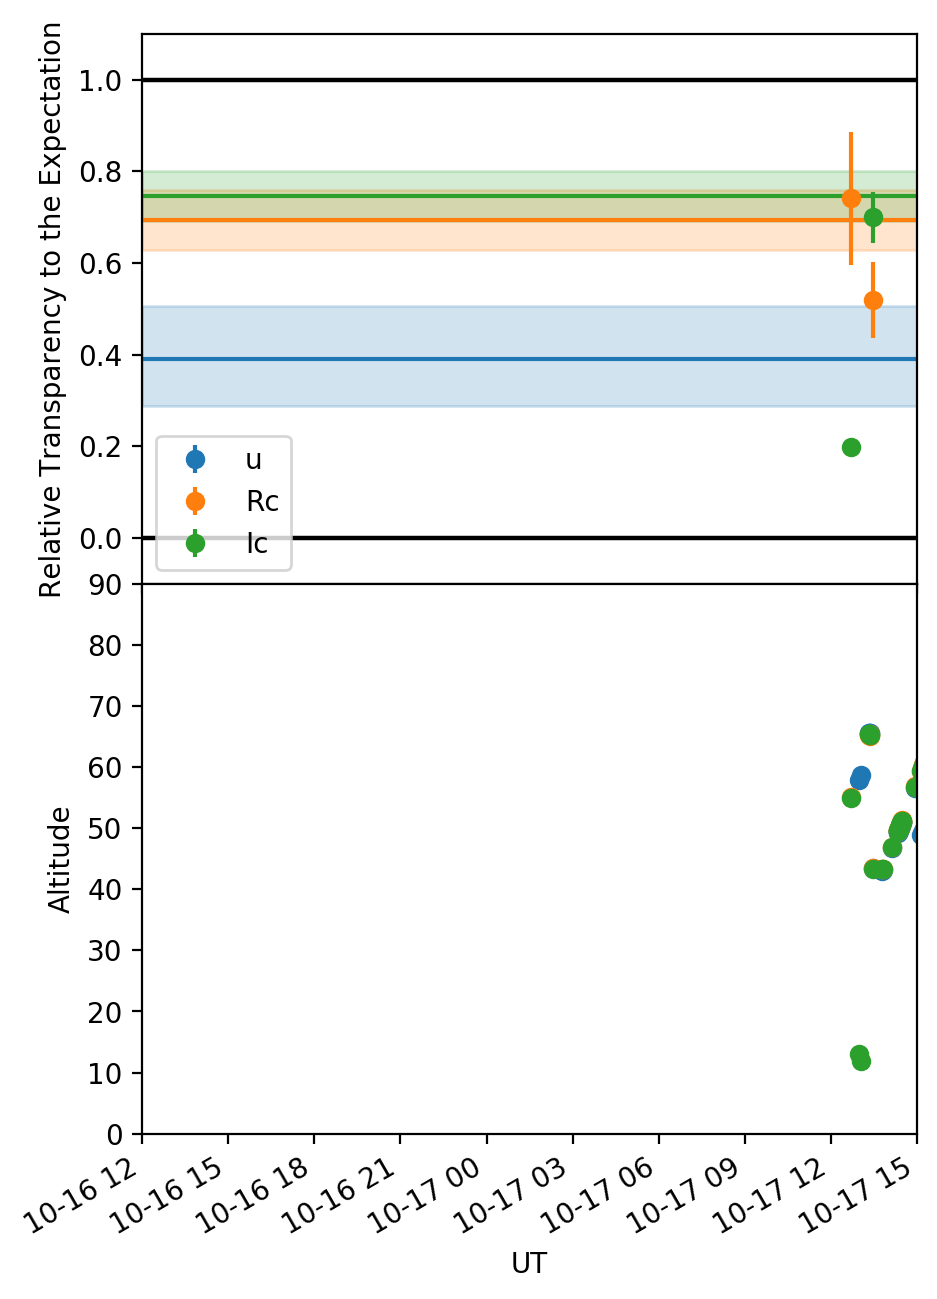

In [16]:
Ali = EarthLocation.from_geodetic(lat=32.31373, lon=80.030018, height=5100)
mkplot(result20181017, Ali, target, 6 )
for ax in (pylab.gcf().axes):
    ax.set_xlim(parse("20181016 12:00 UT"),parse("20181017 15:00 UT"))


# Hiroshima data

In [17]:
target = "hiroshima/object*-2/object*.new"
offset = [9.4,60.2]

In [18]:
Hresult = loopover(target,offset)

0/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.859293035  26.7552611413  
CRPIX : 1329.98977661  637.075813293  
CD1_1 CD1_2  : 0.000182839857234  4.6966737741e-05  
CD2_1 CD2_2  : -4.74463661656e-05  0.000181238369845  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920115633-2/object20140920115633-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 15.963002235247004 15.161346028308262 
{'median': nan, 'std': nan, 'limitmag': 15.963002235247004}
0/32
None [9.4, 60.2]
hiroshima/object20140920115633-1/object20140920115633-1.new
0/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.859293035  26.7552611413  
CRPIX : 1320.58977661  576.87581329  
PC1_1 PC1_2  : 0.000182839857234  4.6966737741e-05  
PC2_1 PC2_2  : -4.74463661656e-05  0.000181238369845  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920115633-0.fits


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 8, in preprocess
    data = fh[0].data[:header["MaxImgRows"], :header["MaxImgCols"]]
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/header.py", line 148, in __getitem__
    card = self._cards[self._cardindex(key)]
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/header.py", line 1702, in _cardindex
    raise KeyError(f"Keyword {keyword!r} not found.")
KeyError: "Keyword 'MAXIMGROWS' not found."


FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 13.485045748170366 12.842787129293704 
{'median': nan, 'std': nan, 'limitmag': 13.485045748170366}
1/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829840538  26.4692911877  
CRPIX : 940.980690002  1238.87361145  
CD1_1 CD1_2  : 0.000181165198079  5.3158568584e-05  
CD2_1 CD2_2  : -5.36535744709e-05  0.00017943345243  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120001-2/object20140920120001-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 15.962151250303156 15.405796545858724 
{'median': nan, 'std': nan, 'limitmag': 15.962151250303156}
1/32
None [9.4, 60.2]
hiroshima/object20140920120001-1/object20140920120001-1.new
1/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829840538  26.4692911877  
CRPIX : 931.58069  1178.67361145  
PC1_1 PC1_2  : 0.000181165198079  5.3158568584e-05  
PC2_1 PC2_2  : -5.36535744709e-05  0.00017943345243  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120001-0.fits


Traceback (most recent call last):
  File "<ipython-input-8-afd3da021b99>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-7-d67ba0acff26>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-61bf3e674179>", line 8, in preprocess
    data = fh[0].data[:header["MaxImgRows"], :header["MaxImgCols"]]
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/header.py", line 148, in __getitem__
    card = self._cards[self._cardindex(key)]
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/header.py", line 1702, in _cardindex
    raise KeyError(f"Keyword {keyword!r} not found.")
KeyError: "Keyword 'MAXIMGROWS' not found."


FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.489123430189515 12.836291665931414 
{'median': 0.39284317015325687, 'std': 0.0, 'limitmag': 13.489123430189515}
2/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.795182198  26.4330717199  
CRPIX : 782.564094543  974.006072998  
CD1_1 CD1_2  : 0.000179675232663  5.78527249852e-05  
CD2_1 CD2_2  : -5.83881512608e-05  0.000178075015338  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120500-2/object20140920120500-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 18.326930150818054 16.862055193654758 
{'median': nan, 'std': nan, 'limitmag': 18.326930150818054}
2/32
None [9.4, 60.2]
hiroshima/object20140920120500-1/object20140920120500-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.467777329785132 17.227087467418485 
{'median': 0.16887639463338544, 'std': 0.0, 'limitmag': 18.467777329785132}
2/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.795182198  26.4330717199  
CRPIX : 773.164094543  913.806072998  
PC1_1 PC1_2  : 0.000179675232663  5.78527249852e-05  
PC2_1 PC2_2  : -5.83881512608e-05  0.000178075015338  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120500-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in u = 13.785109323396362 13.340780648723971 
{'median': nan, 'std': nan, 'limitmag': 13.785109323396362}
3/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829827303  26.4692718802  
CRPIX : 843.171981812  1188.73033142  
CD1_1 CD1_2  : 0.00017869731816  6.09299388781e-05  
CD2_1 CD2_2  : -6.14631257044e-05  0.000177033777795  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120807-2/object20140920120807-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.96620041961962 16.038303560941173 
{'median': nan, 'std': nan, 'limitmag': 17.96620041961962}
3/32
None [9.4, 60.2]
hiroshima/object20140920120807-1/object20140920120807-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.265276640271445 16.272207679520314 
{'median': 0.4701966225587444, 'std': 0.0, 'limitmag': 18.265276640271445}
3/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829827303  26.4692718802  
CRPIX : 833.77198181  1128.53033142  
PC1_1 PC1_2  : 0.00017869731816  6.09299388781e-05  
PC2_1 PC2_2  : -6.14631257044e-05  0.000177033777795  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120807-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.772110690002746 13.304497183294696 
{'median': 0.3747975227789777, 'std': 0.0, 'limitmag': 13.772110690002746}
4/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829826016  26.4692783665  
CRPIX : 834.087013245  1184.00598145  
CD1_1 CD1_2  : 0.000178466743384  6.15974578649e-05  
CD2_1 CD2_2  : -6.21449535609e-05  0.000176790499684  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120845-2/object20140920120845-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.958853130578806 16.250328224296744 
{'median': nan, 'std': nan, 'limitmag': 17.958853130578806}
4/32
None [9.4, 60.2]
hiroshima/object20140920120845-1/object20140920120845-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.257932859914135 16.505051627118515 
{'median': 0.3636885979853498, 'std': 0.0, 'limitmag': 18.257932859914135}
4/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829826016  26.4692783665  
CRPIX : 824.68701325  1123.80598145  
PC1_1 PC1_2  : 0.000178466743384  6.15974578649e-05  
PC2_1 PC2_2  : -6.21449535609e-05  0.000176790499684  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120845-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.773592488633813 13.30635955992588 
{'median': 0.2943563074789591, 'std': 0.0, 'limitmag': 13.773592488633813}
5/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829825552  26.4692801654  
CRPIX : 828.55065918  1180.70562744  
CD1_1 CD1_2  : 0.000178305155641  6.20831717902e-05  
CD2_1 CD2_2  : -6.26292852364e-05  0.000176623992019  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120911-2/object20140920120911-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.941828874803466 16.58876220537062 
{'median': nan, 'std': nan, 'limitmag': 17.941828874803466}
5/32
None [9.4, 60.2]
hiroshima/object20140920120911-1/object20140920120911-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.24615003569982 16.909924941875055 
{'median': 0.21836101164939015, 'std': 0.0, 'limitmag': 18.24615003569982}
5/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829825552  26.4692801654  
CRPIX : 819.15065918  1120.50562744  
PC1_1 PC1_2  : 0.000178305155641  6.20831717902e-05  
PC2_1 PC2_2  : -6.26292852364e-05  0.000176623992019  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120911-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.77531991650308 13.308024360166051 
{'median': 0.16878747334270205, 'std': 0.0, 'limitmag': 13.77531991650308}
6/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621875553  28.8728405204  
CRPIX : 659.670463562  1012.76145935  
CD1_1 CD1_2  : 0.000181929767721  5.03760989295e-05  
CD2_1 CD2_2  : -5.08725625885e-05  0.000180322270452  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121217-2/object20140920121217-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 17.957872510458387 14.781405456116106 
{'median': 0.370784954152894, 'std': 0.0, 'limitmag': 17.957872510458387}
6/32
None [9.4, 60.2]
hiroshima/object20140920121217-1/object20140920121217-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 18.257499765534355 15.090409540530702 
{'median': nan, 'std': nan, 'limitmag': 18.257499765534355}
6/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621875553  28.8728405204  
CRPIX : 650.270463562  952.56145935  
PC1_1 PC1_2  : 0.000181929767721  5.03760989295e-05  
PC2_1 PC2_2  : -5.08725625885e-05  0.000180322270452  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121217-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.778686782474596 13.311214821289305 
{'median': 0.27636718953280603, 'std': 0.0, 'limitmag': 13.778686782474596}
7/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654942418  28.8930940869  
CRPIX : 1114.81517029  658.117660522  
CD1_1 CD1_2  : -0.000150018864748  0.000113705582776  
CD2_1 CD2_2  : -0.000114746539038  -0.000148688619326  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920142558-2/object20140920142558-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 17.468283417339766 14.308336011810336 
{'median': 0.4949024834426077, 'std': 0.0, 'limitmag': 17.468283417339766}
7/32
None [9.4, 60.2]
hiroshima/object20140920142558-1/object20140920142558-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 17.89490452108642 14.609735032965949 
{'median': 0.606916581954461, 'std': 0.0, 'limitmag': 17.89490452108642}
7/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654942418  28.8930940869  
CRPIX : 1105.41517029  597.91766052  
PC1_1 PC1_2  : -0.000150018864748  0.000113705582776  
PC2_1 PC2_2  : -0.000114746539038  -0.000148688619326  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920142558-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.745458707054619 13.270228809502587 
{'median': 0.3452553525041533, 'std': 0.0, 'limitmag': 13.745458707054619}
8/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654918215  28.8930785543  
CRPIX : 1112.45500183  655.803936005  
CD1_1 CD1_2  : -0.000150216691204  0.000113462044382  
CD2_1 CD2_2  : -0.00011447013943  -0.000148894548395  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920142653-2/object20140920142653-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 17.46902154318777 14.321810791365643 
{'median': 0.5039448747293326, 'std': 0.0, 'limitmag': 17.46902154318777}
8/32
None [9.4, 60.2]
hiroshima/object20140920142653-1/object20140920142653-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 17.89479692226002 14.588111722573885 
{'median': 0.49835487204437134, 'std': 0.0, 'limitmag': 17.89479692226002}
8/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654918215  28.8930785543  
CRPIX : 1103.05500183  595.603936  
PC1_1 PC1_2  : -0.000150216691204  0.000113462044382  
PC2_1 PC2_2  : -0.00011447013943  -0.000148894548395  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920142653-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.744775381332408 13.26838637619594 
{'median': 0.3568465516056072, 'std': 0.0, 'limitmag': 13.744775381332408}
9/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654918727  28.8930744256  
CRPIX : 1111.36418152  655.322937012  
CD1_1 CD1_2  : -0.000150284379102  0.000113383656971  
CD2_1 CD2_2  : -0.000114368793812  -0.000148975970162  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920142712-2/object20140920142712-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.46947620691049 14.312665412363426 
{'median': nan, 'std': nan, 'limitmag': 17.46947620691049}
9/32
None [9.4, 60.2]
hiroshima/object20140920142712-1/object20140920142712-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 17.893977907391672 14.612646875572485 
{'median': nan, 'std': nan, 'limitmag': 17.893977907391672}
9/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654918727  28.8930744256  
CRPIX : 1101.96418152  595.12293701  
PC1_1 PC1_2  : -0.000150284379102  0.000113383656971  
PC2_1 PC2_2  : -0.000114368793812  -0.000148975970162  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920142712-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.74464396513395 13.269048032410291 
{'median': 0.3475729482205565, 'std': 0.0, 'limitmag': 13.74464396513395}
10/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654912417  28.8930907898  
CRPIX : 1100.59382629  647.629123688  
CD1_1 CD1_2  : -0.000151246238785  0.000112110988623  
CD2_1 CD2_2  : -0.000113088645122  -0.000149906471407  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143156-2/object20140920143156-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 17.962284773552483 14.596516715184398 
{'median': 0.49551256349820116, 'std': 0.0, 'limitmag': 17.962284773552483}
10/32
None [9.4, 60.2]
hiroshima/object20140920143156-1/object20140920143156-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.275624472873083 14.88269922238388 
{'median': 0.6020510200311993, 'std': 0.0, 'limitmag': 18.275624472873083}
10/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654912417  28.8930907898  
CRPIX : 1091.19382629  587.42912369  
PC1_1 PC1_2  : -0.000151246238785  0.000112110988623  
PC2_1 PC2_2  : -0.000113088645122  -0.000149906471407  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143156-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.777293422268288 13.309450257238279 
{'median': 0.3639265377840046, 'std': 0.0, 'limitmag': 13.777293422268288}
11/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654915208  28.8930989097  
CRPIX : 1098.80174255  646.038059235  
CD1_1 CD1_2  : -0.000151492141244  0.000111803585574  
CD2_1 CD2_2  : -0.000112759196939  -0.00015013193223  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143315-2/object20140920143315-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 17.962676326740738 14.634776326062934 
{'median': 0.4752853828980958, 'std': 0.0, 'limitmag': 17.962676326740738}
11/32
None [9.4, 60.2]
hiroshima/object20140920143315-1/object20140920143315-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.278083626130734 14.91998200357462 
{'median': 0.5201969685991079, 'std': 0.04828875870892402, 'limitmag': 18.278083626130734}
11/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654915208  28.8930989097  
CRPIX : 1089.40174255  585.83805923  
PC1_1 PC1_2  : -0.000151492141244  0.000111803585574  
PC2_1 PC2_2  : -0.000112759196939  -0.00015013193223  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143315-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.778144140166388 13.310638048152585 
{'median': 0.3414094161814938, 'std': 0.0, 'limitmag': 13.778144140166388}
12/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654906226  28.8931045427  
CRPIX : 1095.60987854  644.036769867  
CD1_1 CD1_2  : -0.000151771152872  0.000111437014607  
CD2_1 CD2_2  : -0.000112386359412  -0.000150426068811  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143448-2/object20140920143448-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 18.388636288479784 14.938819758227215 
{'median': 0.4692160651825583, 'std': 0.0, 'limitmag': 18.388636288479784}
12/32
None [9.4, 60.2]
hiroshima/object20140920143448-1/object20140920143448-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.513307343687895 15.229207790408001 
{'median': 0.5077340815341476, 'std': 0.04684726162619751, 'limitmag': 18.513307343687895}
12/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654906226  28.8931045427  
CRPIX : 1086.20987854  583.83676987  
PC1_1 PC1_2  : -0.000151771152872  0.000111437014607  
PC2_1 PC2_2  : -0.000112386359412  -0.000150426068811  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143448-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.793446131622733 13.331335157286626 
{'median': 0.32989794554834917, 'std': 0.0, 'limitmag': 13.793446131622733}
13/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941298767  26.4305843241  
CRPIX : 862.596069336  1369.99714661  
CD1_1 CD1_2  : -0.00013815418368  0.000127768749818  
CD2_1 CD2_2  : -0.000128845162284  -0.000136784329883  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143819-2/object20140920143819-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.480404241755064 15.903387011386034 
{'median': nan, 'std': nan, 'limitmag': 17.480404241755064}
13/32
None [9.4, 60.2]
hiroshima/object20140920143819-1/object20140920143819-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 17.898864884504313 16.150667067918658 
{'median': nan, 'std': nan, 'limitmag': 17.898864884504313}
13/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941298767  26.4305843241  
CRPIX : 853.19606934  1309.79714661  
PC1_1 PC1_2  : -0.00013815418368  0.000127768749818  
PC2_1 PC2_2  : -0.000128845162284  -0.000136784329883  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143819-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.749502176330585 13.273865400145882 
{'median': 0.34920193558870566, 'std': 0.0, 'limitmag': 13.749502176330585}
14/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941300307  26.4305923303  
CRPIX : 859.839385986  1368.4455719  
CD1_1 CD1_2  : -0.000138286107082  0.000127632640464  
CD2_1 CD2_2  : -0.000128680821201  -0.000136949924701  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143840-2/object20140920143840-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.971872322882945 15.943298248928201 
{'median': nan, 'std': nan, 'limitmag': 17.971872322882945}
14/32
None [9.4, 60.2]
hiroshima/object20140920143840-1/object20140920143840-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 18.285121246068357 16.168341701288263 
{'median': nan, 'std': nan, 'limitmag': 18.285121246068357}
14/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941300307  26.4305923303  
CRPIX : 850.43938599  1308.2455719  
PC1_1 PC1_2  : -0.000138286107082  0.000127632640464  
PC2_1 PC2_2  : -0.000128680821201  -0.000136949924701  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143840-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.779045964342899 13.310221251526881 
{'median': 0.35355133368116126, 'std': 0.0, 'limitmag': 13.779045964342899}
15/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941303864  26.4305897054  
CRPIX : 857.345809937  1366.88667297  
CD1_1 CD1_2  : -0.000138416782055  0.000127463296625  
CD2_1 CD2_2  : -0.000128532313649  -0.000137074423344  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143905-2/object20140920143905-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.97259633549243 15.997869477176339 
{'median': nan, 'std': nan, 'limitmag': 17.97259633549243}
15/32
None [9.4, 60.2]
hiroshima/object20140920143905-1/object20140920143905-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 18.286826956837913 16.238806825426764 
{'median': nan, 'std': nan, 'limitmag': 18.286826956837913}
15/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941303864  26.4305897054  
CRPIX : 847.94580994  1306.68667297  
PC1_1 PC1_2  : -0.000138416782055  0.000127463296625  
PC2_1 PC2_2  : -0.000128532313649  -0.000137074423344  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143905-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.778734510031004 13.31035234522452 
{'median': 0.33240406316687904, 'std': 0.0, 'limitmag': 13.778734510031004}
16/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.79521348  26.4331376175  
CRPIX : 1348.22584534  878.111068726  
CD1_1 CD1_2  : -0.000138773219459  0.000127030300558  
CD2_1 CD2_2  : -0.000128239668396  -0.000137479839647  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920144030-2/object20140920144030-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 18.40818411656264 15.917175428621395 
{'median': nan, 'std': nan, 'limitmag': 18.40818411656264}
16/32
None [9.4, 60.2]
hiroshima/object20140920144030-1/object20140920144030-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 18.521537794042985 16.149780470663778 
{'median': nan, 'std': nan, 'limitmag': 18.521537794042985}
16/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.79521348  26.4331376175  
CRPIX : 1338.82584534  817.91106873  
PC1_1 PC1_2  : -0.000138773219459  0.000127030300558  
PC2_1 PC2_2  : -0.000128239668396  -0.000137479839647  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920144030-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.790923299592212 13.34352154555589 
{'median': 0.37045581968468116, 'std': 0.0, 'limitmag': 13.790923299592212}
17/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941310753  26.4305823936  
CRPIX : 845.758071899  1360.6408844  
CD1_1 CD1_2  : -0.000139146019823  0.000126721440238  
CD2_1 CD2_2  : -0.00012775133771  -0.000137857611834  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920144103-2/object20140920144103-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 18.400764301488653 15.93500374934629 
{'median': nan, 'std': nan, 'limitmag': 18.400764301488653}
17/32
None [9.4, 60.2]
hiroshima/object20140920144103-1/object20140920144103-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 18.522594583524434 16.169636663349962 
{'median': nan, 'std': nan, 'limitmag': 18.522594583524434}
17/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941310753  26.4305823936  
CRPIX : 836.3580719  1300.4408844  
PC1_1 PC1_2  : -0.000139146019823  0.000126721440238  
PC2_1 PC2_2  : -0.00012775133771  -0.000137857611834  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920144103-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.790148173649555 13.34284668380005 
{'median': 0.35608261940091923, 'std': 0.0, 'limitmag': 13.790148173649555}
18/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829835082  26.4692858286  
CRPIX : 870.452663422  1204.2563324  
CD1_1 CD1_2  : 0.000179435295732  5.86472336084e-05  
CD2_1 CD2_2  : -5.91726321756e-05  0.00017778079004  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120547-2/object20140920120547-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 18.33485582494571 16.563142039875288 
{'median': nan, 'std': nan, 'limitmag': 18.33485582494571}
18/32
None [9.4, 60.2]
hiroshima/object20140920120547-1/object20140920120547-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.492510149906167 16.830868474746094 
{'median': 0.28803497141503537, 'std': 0.009670820487142628, 'limitmag': 18.492510149906167}
18/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829835082  26.4692858286  
CRPIX : 861.05266342  1144.0563324  
PC1_1 PC1_2  : 0.000179435295732  5.86472336084e-05  
PC2_1 PC2_2  : -5.91726321756e-05  0.00017778079004  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120547-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.785757318563816 13.340795697241932 
{'median': 0.20649738606764995, 'std': 0.0, 'limitmag': 13.785757318563816}
19/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.795179379  26.4330761825  
CRPIX : 809.360534668  991.127502441  
CD1_1 CD1_2  : 0.000180425261011  5.55043750316e-05  
CD2_1 CD2_2  : -5.59857185973e-05  0.00017881586396  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120231-2/object20140920120231-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 18.373349879956667 16.164896766574234 
{'median': nan, 'std': nan, 'limitmag': 18.373349879956667}
19/32
None [9.4, 60.2]
hiroshima/object20140920120231-1/object20140920120231-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.503689508469222 16.36619907705639 
{'median': 0.4919767876550962, 'std': 0.0, 'limitmag': 18.503689508469222}
19/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.795179379  26.4330761825  
CRPIX : 799.960534668  930.927502441  
PC1_1 PC1_2  : 0.000180425261011  5.55043750316e-05  
PC2_1 PC2_2  : -5.59857185973e-05  0.00017881586396  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120231-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.7878681469974 13.34165241251074 
{'median': 0.34846027715696704, 'std': 0.0, 'limitmag': 13.7878681469974}
20/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.658833372  28.952704987  
CRPIX : 737.565658569  1484.5736084  
CD1_1 CD1_2  : 0.000182471702744  4.85195060572e-05  
CD2_1 CD2_2  : -4.9072991575e-05  0.000180820250636  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121047-2/object20140920121047-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.962074587163706 14.690775278526981 
{'median': nan, 'std': nan, 'limitmag': 17.962074587163706}
20/32
None [9.4, 60.2]
hiroshima/object20140920121047-1/object20140920121047-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.26095542404001 15.015223468193117 
{'median': 0.45509596675659403, 'std': 0.04402430162918011, 'limitmag': 18.26095542404001}
20/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.658833372  28.952704987  
CRPIX : 728.16565857  1424.3736084  
PC1_1 PC1_2  : 0.000182471702744  4.85195060572e-05  
PC2_1 PC2_2  : -4.9072991575e-05  0.000180820250636  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121047-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.776109384413582 13.30922386932722 
{'median': 0.3011956469182075, 'std': 0.0, 'limitmag': 13.776109384413582}
21/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.658827111  28.9527033357  
CRPIX : 718.21660614  1473.74998474  
CD1_1 CD1_2  : 0.000182060606433  4.98728615829e-05  
CD2_1 CD2_2  : -5.04582590945e-05  0.000180444424581  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121154-2/object20140920121154-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 17.961651341167105 14.700467756456717 
{'median': 0.40960480750881456, 'std': 0.0, 'limitmag': 17.961651341167105}
21/32
None [9.4, 60.2]
hiroshima/object20140920121154-1/object20140920121154-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.26077305689023 15.010936159747299 
{'median': 0.44058616576151904, 'std': 0.044596781865173574, 'limitmag': 18.26077305689023}
21/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.658827111  28.9527033357  
CRPIX : 708.81660614  1413.54998474  
PC1_1 PC1_2  : 0.000182060606433  4.98728615829e-05  
PC2_1 PC2_2  : -5.04582590945e-05  0.000180444424581  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121154-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.777812450142875 13.310690324146544 
{'median': 0.29356552062366903, 'std': 0.0, 'limitmag': 13.777812450142875}
22/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621901182  28.8728673928  
CRPIX : 649.84866333  1006.13569641  
CD1_1 CD1_2  : 0.000181723560366  5.12591753425e-05  
CD2_1 CD2_2  : -5.17023479008e-05  0.000180105086595  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121250-2/object20140920121250-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 18.36295073350951 15.061155329313706 
{'median': 0.35587132719337294, 'std': 0.0, 'limitmag': 18.36295073350951}
22/32
None [9.4, 60.2]
hiroshima/object20140920121250-1/object20140920121250-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.49751043659603 15.387334030267096 
{'median': 0.3480509905773634, 'std': 0.0, 'limitmag': 18.49751043659603}
22/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621901182  28.8728673928  
CRPIX : 640.44866333  945.93569641  
PC1_1 PC1_2  : 0.000181723560366  5.12591753425e-05  
PC2_1 PC2_2  : -5.17023479008e-05  0.000180105086595  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121250-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.792055575406945 13.346367112780488 
{'median': 0.26105720363644097, 'std': 0.0, 'limitmag': 13.792055575406945}
23/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.62190413  28.8728727848  
CRPIX : 635.964408875  996.522781372  
CD1_1 CD1_2  : 0.000181386477649  5.24877758417e-05  
CD2_1 CD2_2  : -5.29505277399e-05  0.000179761592178  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121346-2/object20140920121346-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 18.358351631244716 15.030991287841308 
{'median': 0.3721665142196157, 'std': 0.0, 'limitmag': 18.358351631244716}
23/32
None [9.4, 60.2]
hiroshima/object20140920121346-1/object20140920121346-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.495143698161 15.352621368021548 
{'median': 0.3607366778843597, 'std': 0.0, 'limitmag': 18.495143698161}
23/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.62190413  28.8728727848  
CRPIX : 626.564408875  936.322781372  
PC1_1 PC1_2  : 0.000181386477649  5.24877758417e-05  
PC2_1 PC2_2  : -5.29505277399e-05  0.000179761592178  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121346-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.790263347356461 13.345185686806207 
{'median': 0.28171652167107636, 'std': 0.0, 'limitmag': 13.790263347356461}
24/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621892489  28.8728494797  
CRPIX : 613.044868469  981.596115112  
CD1_1 CD1_2  : 0.000180755352109  5.4420323125e-05  
CD2_1 CD2_2  : -5.48999531627e-05  0.000179170112683  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121510-2/object20140920121510-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 18.327083711911275 15.254180829709014 
{'median': 0.2786688462410021, 'std': 0.0, 'limitmag': 18.327083711911275}
24/32
None [9.4, 60.2]
hiroshima/object20140920121510-1/object20140920121510-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 18.473664314302397 15.567510903855435 
{'median': nan, 'std': nan, 'limitmag': 18.473664314302397}
24/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621892489  28.8728494797  
CRPIX : 603.644868469  921.396115112  
PC1_1 PC1_2  : 0.000180755352109  5.4420323125e-05  
PC2_1 PC2_2  : -5.48999531627e-05  0.000179170112683  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121510-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.786925742362175 13.341201460688083 
{'median': 0.22708225022007264, 'std': 0.0, 'limitmag': 13.786925742362175}
25/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654905693  28.8930945817  
CRPIX : 1099.21044922  646.575241089  
CD1_1 CD1_2  : -0.000151413696979  0.000111909691477  
CD2_1 CD2_2  : -0.000112886838455  -0.000150061931521  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143247-2/object20140920143247-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.965179337548133 14.624673587395097 
{'median': nan, 'std': nan, 'limitmag': 17.965179337548133}
25/32
None [9.4, 60.2]
hiroshima/object20140920143247-1/object20140920143247-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.275546980859836 14.905848380070935 
{'median': 0.5739296059898021, 'std': 0.0, 'limitmag': 18.275546980859836}
25/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654905693  28.8930945817  
CRPIX : 1089.81044922  586.37524109  
PC1_1 PC1_2  : -0.000151413696979  0.000111909691477  
PC2_1 PC2_2  : -0.000112886838455  -0.000150061931521  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143247-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.778160217955342 13.31036057437485 
{'median': 0.34879885687807166, 'std': 0.0, 'limitmag': 13.778160217955342}
26/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654902925  28.8931033374  
CRPIX : 1097.4936676  645.580097198  
CD1_1 CD1_2  : -0.000151588032843  0.000111677659776  
CD2_1 CD2_2  : -0.000112633984769  -0.000150224252273  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143341-2/object20140920143341-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 18.383866910824732 14.90929701694924 
{'median': 0.4851573159232539, 'std': 0.0, 'limitmag': 18.383866910824732}
26/32
None [9.4, 60.2]
hiroshima/object20140920143341-1/object20140920143341-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.513120715130963 15.198649235836738 
{'median': 0.5339728058322035, 'std': 0.05050453265946833, 'limitmag': 18.513120715130963}
26/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654902925  28.8931033374  
CRPIX : 1088.0936676  585.3800972  
PC1_1 PC1_2  : -0.000151588032843  0.000111677659776  
PC2_1 PC2_2  : -0.000112633984769  -0.000150224252273  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143341-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.792836977308822 13.347011185758788 
{'median': 0.3539724643076277, 'std': 0.0, 'limitmag': 13.792836977308822}
27/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654906895  28.8931028962  
CRPIX : 1096.7122345  644.262443542  
CD1_1 CD1_2  : -0.000151674542898  0.000111552768193  
CD2_1 CD2_2  : -0.000112501300292  -0.000150319792086  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143415-2/object20140920143415-2.new
FLUX_I


2" ap 10 sigma limiting magnitude in Ic = 18.389079402241777 14.906287280506465 
{'median': 0.48855742897646337, 'std': 0.0, 'limitmag': 18.389079402241777}
27/32
None [9.4, 60.2]
hiroshima/object20140920143415-1/object20140920143415-1.new
FLUX_R


2" ap 10 sigma limiting magnitude in Rc = 18.51443724480105 15.190678172280448 
{'median': 0.536840530724762, 'std': 0.050887920787593605, 'limitmag': 18.51443724480105}
27/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654906895  28.8931028962  
CRPIX : 1087.3122345  584.06244354  
PC1_1 PC1_2  : -0.000151674542898  0.000111552768193  
PC2_1 PC2_2  : -0.000112501300292  -0.000150319792086  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143415-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.793901224320122 13.347320305423816 
{'median': 0.3599735181498128, 'std': 0.0, 'limitmag': 13.793901224320122}
28/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941298508  26.4305985567  
CRPIX : 874.251556396  1376.40873718  
CD1_1 CD1_2  : -0.000137475772635  0.000128522392813  
CD2_1 CD2_2  : -0.000129567466338  -0.000136129270186  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143628-2/object20140920143628-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.47580168879659 15.995003119082858 
{'median': nan, 'std': nan, 'limitmag': 17.47580168879659}
28/32
None [9.4, 60.2]
hiroshima/object20140920143628-1/object20140920143628-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 17.893740382241525 16.24918340627705 
{'median': nan, 'std': nan, 'limitmag': 17.893740382241525}
28/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941298508  26.4305985567  
CRPIX : 864.8515564  1316.20873718  
PC1_1 PC1_2  : -0.000137475772635  0.000128522392813  
PC2_1 PC2_2  : -0.000129567466338  -0.000136129270186  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143628-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.748982522997924 13.273304918905836 
{'median': 0.3328986145866825, 'std': 0.0, 'limitmag': 13.748982522997924}
29/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941302716  26.4305942249  
CRPIX : 865.060119629  1370.24397278  
CD1_1 CD1_2  : -0.000138032340359  0.000127908044633  
CD2_1 CD2_2  : -0.000128990043351  -0.000136679197463  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143759-2/object20140920143759-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.47828186083918 15.796725595016204 
{'median': nan, 'std': nan, 'limitmag': 17.47828186083918}
29/32
None [9.4, 60.2]
hiroshima/object20140920143759-1/object20140920143759-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 17.899963034100782 16.045477782500935 
{'median': nan, 'std': nan, 'limitmag': 17.899963034100782}
29/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941302716  26.4305942249  
CRPIX : 855.66011963  1310.04397278  
PC1_1 PC1_2  : -0.000138032340359  0.000127908044633  
PC2_1 PC2_2  : -0.000128990043351  -0.000136679197463  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143759-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.749608415610332 13.273289131008772 
{'median': 0.368311971058741, 'std': 0.0, 'limitmag': 13.749608415610332}
30/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941296382  26.4305964488  
CRPIX : 854.955535889  1366.1072998  
CD1_1 CD1_2  : -0.000138577832128  0.000127302645255  
CD2_1 CD2_2  : -0.000128385910122  -0.000137250131411  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143931-2/object20140920143931-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 17.97413880493903 15.815855161019917 
{'median': nan, 'std': nan, 'limitmag': 17.97413880493903}
30/32
None [9.4, 60.2]
hiroshima/object20140920143931-1/object20140920143931-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 18.288562776790446 16.041741120048943 
{'median': nan, 'std': nan, 'limitmag': 18.288562776790446}
30/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941296382  26.4305964488  
CRPIX : 845.55553589  1305.9072998  
PC1_1 PC1_2  : -0.000138577832128  0.000127302645255  
PC2_1 PC2_2  : -0.000128385910122  -0.000137250131411  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143931-0.fits
FLUX_U


2" ap 10 sigma limiting magnitude in u = 13.77872863203308 13.308688467718055 
{'median': 0.371698485438296, 'std': 0.0, 'limitmag': 13.77872863203308}
31/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941304221  26.4305935007  
CRPIX : 851.707122803  1363.96255493  
CD1_1 CD1_2  : -0.00013876408194  0.000127110255838  
CD2_1 CD2_2  : -0.000128189166382  -0.000137434709386  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143956-2/object20140920143956-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Ic = 18.40761543566038 15.90170022443026 
{'median': nan, 'std': nan, 'limitmag': 18.40761543566038}
31/32
None [9.4, 60.2]
hiroshima/object20140920143956-1/object20140920143956-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

2" ap 10 sigma limiting magnitude in Rc = 18.52198099241396 16.12949587984889 
{'median': nan, 'std': nan, 'limitmag': 18.52198099241396}
31/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941304221  26.4305935007  
CRPIX : 842.3071228  1303.76255493  
PC1_1 PC1_2  : -0.00013876408194  0.000127110255838  
PC2_1 PC2_2  : -0.000128189166382  -0.000137434709386  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143956-0.fits
FLUX_U
2" ap 10 sigma limiting magnitude in u = 13.791201907321629 13.344287326121702 
{'median': 0.37297773903582704, 'std': 0.0, 'limitmag': 13.791201907321629}


/home/utsumi/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname UT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/uts

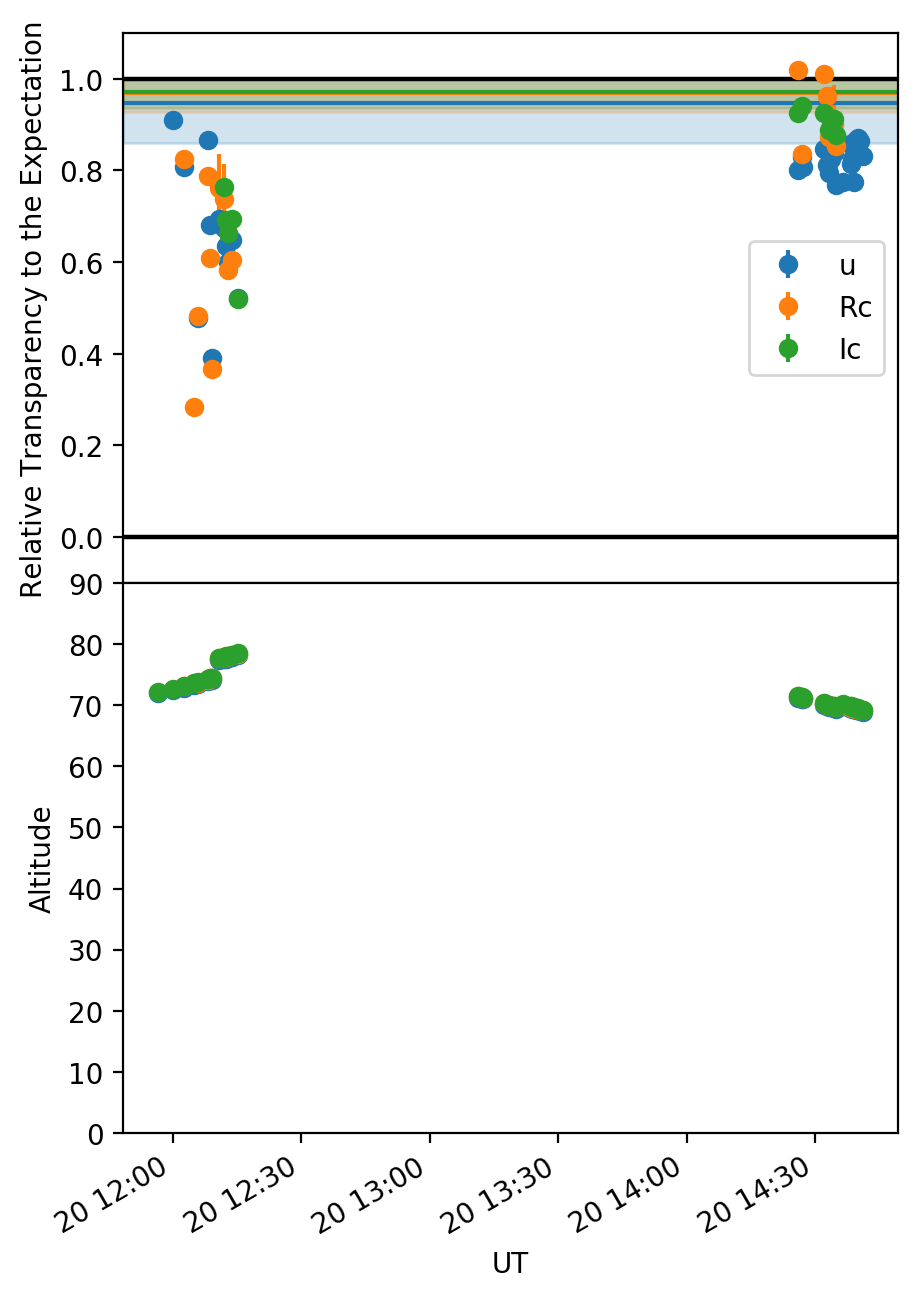

In [19]:
target = "hiroshima/object*-2/object*.new"
Hiroshima = EarthLocation.from_geodetic(lat=34.3775, lon=132.7767, height=510)
surface = {"u": 1.43, "Rc": 1.03, "Ic": 1.03}
mkplot(Hresult, Hiroshima, target, 1, corr=surface )

# Playground

In [20]:
# arXiv:astro-ph/9907229
def acfregister(path,refpath):
    data, header=preprocess(path)
    refdata, refheader=preprocess(refpath)

    catalogs = []
    for img in [data, refdata]:
        mean, median, std = sigma_clipped_stats(img, sigma=3.0)  
        daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std, brightest=100)
        sources=daofind(img-median)
        # define positions where we measure
        positions = numpy.transpose([sources["xcentroid"], sources["ycentroid"]])
        catalogs.append(positions)
    return catalogs
    
catalogs = acfregister("HT0000405-0.fits","HT0000405-2/HT0000405-2.new")

FileNotFoundError: [Errno 2] No such file or directory: 'HT0000405-0.fits'

In [ ]:
catalogs[0].shape, catalogs[1].shape

In [ ]:
from scipy.signal import correlate2d
def getscalerot( catalogs, plot=False ):
    # determine scale and rotation
    if plot:
        fig = pylab.figure(figsize=(5,5),dpi=200)
    Harr = []
    for i in range(2):
        d = []
        phi = []
        # calculate d and phi for all possible pairs
        for a in catalogs[i]:
            for b in catalogs[i]:
                d.append( numpy.linalg.norm(a-b) )
                phi.append( numpy.arctan2(*(a-b)) )
        d = numpy.array(d)
        phi = numpy.array(phi)
        ld = numpy.log(d)
        X = numpy.arange(3,9,0.05)
        Y = numpy.arange(-numpy.pi,numpy.pi,0.05)
        # make a 2D histogram
        H, xedges, yedges = numpy.histogram2d(ld,phi,bins=[X,Y])
        Harr.append(H)
        if plot:
            pylab.subplot("13{}".format(i+1))
            pylab.imshow(H,origin="lower",extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
            pylab.ylabel(r"$\log(d)$")
            pylab.xlabel(r"$\phi$")
    # correlate them
    corr = correlate2d(Harr[0],Harr[1], boundary='symm', mode='same')
    y, x = numpy.unravel_index(numpy.argmax(corr), corr.shape)
    cy,cx = (numpy.array(2*yedges[-1],2*xedges[-1])/(numpy.array(corr.shape))*(numpy.array([y,x])+0.5)+numpy.array(-yedges[-1],-xedges[-1]))
    if plot:
        pylab.subplot(133)
        pylab.imshow(corr,origin="lower",extent=[-yedges[-1], yedges[-1], -xedges[-1], xedges[-1]])
#        pylab.scatter(cx,cy,marker="x",alpha=0.5)
        pylab.ylabel(r"$\log(d)$")
        pylab.xlabel(r"$\phi$")
    return cx,numpy.exp(cy)

In [ ]:
phi, scale = getscalerot([catalogs[0],catalogs[1]],plot=True)
print(phi,scale)

In [ ]:
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import coordinates as coord
fig = pylab.figure(figsize=(5,5),dpi=150)

Ali = EarthLocation.from_geodetic(lat=32.31373, lon=80.030018, height=5100)
files = glob.glob("fwhm/HT*-2/HT*.new")[:-1]
obstime = []
ra = []
dec = []
for afile in files:
    with fits.open(afile) as fh:
        header = fh[0].header
        obstime.append(parse("{}T{} UT ".format(header["DATE-OBS"],header["UT"])))
        ra  = header["RA"]
        dec = header["DEC"]

aa_frame = coord.AltAz(
    obstime=obstime,
    location=Ali)
ret = SkyCoord(ra,dec,unit=("hour","deg")).transform_to(aa_frame)
pylab.plot_date(ret.obstime.value, ret.alt)
fig.autofmt_xdate()
pylab.tight_layout()
#print (ret.obstime, ret.az, ret.alt)

In [ ]:
pylab.plot(1/numpy.cos((90-ret.alt.degree)/180*numpy.pi), result["Ic"]["median"],"o")
pylab.ylim(0.3,0.4)